## Initialization

In [ ]:
# Numpy and Pandas and Math
import numpy as np
import pandas as pd
import math
from matplotlib import pyplot

# Import Statsmodels
import statsmodels.api as sm
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt, VARMAX

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Count time
import time

# Garbage collection
import gc
gc.enable()

# To clear all the unnecessary value warnings when implementing the demand models
import warnings
warnings.filterwarnings("ignore")

print("Setup Complete")

demand_rawdata = pd.read_csv("C:\\Users\\renal\\Documents\\HEC Supervised Project\\Historical_Product_Demand.csv")
print("Data Loaded")

Setup Complete
Data Loaded


## Data preprocessing

In [ ]:
#Parse Date
demand_rawdata["Date"] = pd.to_datetime(demand_rawdata["Date"], format="%Y/%m/%d")

#Target Feature - Order_Demand
#Removing () from the target feature.
demand_rawdata['Order_Demand'] = demand_rawdata['Order_Demand'].str.replace('(',"")
demand_rawdata['Order_Demand'] = demand_rawdata['Order_Demand'].str.replace(')',"")

#Change Order_Demand column to numeric data
demand_rawdata["Order_Demand"] = pd.to_numeric(demand_rawdata["Order_Demand"], downcast="float")

#Drop rows with missing dates
demand_rawdata.dropna(subset=["Date"], inplace=True)

In [ ]:
demand_rawdata.describe(include="all")

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
count,1037336,1037336,1037336,1037336,1.037336e+06
unique,2160,4,33,1729,NaN
top,Product_1359,Whse_J,Category_019,2013-09-27 00:00:00,NaN
freq,16936,764447,470266,2075,NaN
first,NaN,NaN,NaN,2011-01-08 00:00:00,NaN
last,NaN,NaN,NaN,2017-01-09 00:00:00,NaN
mean,NaN,NaN,NaN,NaN,4.951970e+03
std,NaN,NaN,NaN,NaN,2.897482e+04
min,NaN,NaN,NaN,NaN,0.000000e+00
25%,NaN,NaN,NaN,NaN,2.000000e+01


In [ ]:
# Return the list of warehouse
warehouse_list = demand_rawdata.Warehouse.unique().tolist()
print("Warehouse List:", warehouse_list)

# Return the list of product categories
category_list = demand_rawdata.Product_Category.unique().tolist()
print("Categories List:", category_list)

# Return the list of unique products
product_list = demand_rawdata.Product_Code.unique().tolist()
print("Product List:", product_list)

Warehouse List: ['Whse_J', 'Whse_S', 'Whse_C', 'Whse_A']
Categories List: ['Category_028', 'Category_006', 'Category_001', 'Category_019', 'Category_005', 'Category_030', 'Category_032', 'Category_011', 'Category_033', 'Category_007', 'Category_015', 'Category_021', 'Category_024', 'Category_026', 'Category_023', 'Category_022', 'Category_009', 'Category_003', 'Category_004', 'Category_018', 'Category_020', 'Category_013', 'Category_008', 'Category_017', 'Category_031', 'Category_025', 'Category_010', 'Category_029', 'Category_012', 'Category_002', 'Category_014', 'Category_027', 'Category_016']
Product List: ['Product_0993', 'Product_0979', 'Product_1159', 'Product_1938', 'Product_1157', 'Product_1234', 'Product_1451', 'Product_1274', 'Product_1512', 'Product_1970', 'Product_1372', 'Product_1994', 'Product_0558', 'Product_0560', 'Product_0561', 'Product_1183', 'Product_1184', 'Product_1150', 'Product_1173', 'Product_1900', 'Product_1248', 'Product_1278', 'Product_1359', 'Product_1270'

In [ ]:
# Dictionary of product to sliced dataframe
products_dataframe = {}

for product in product_list:
  products_dataframe[product] = demand_rawdata.loc[demand_rawdata["Product_Code"] == product].sort_values(by=["Date", "Warehouse"]).reset_index(drop=True)

In [ ]:
# Dictionary of product to demand data grouped weekly
products_dataframe_weekly = {}

for product in products_dataframe:
  df1 = products_dataframe[product]
  df1 = df1[["Date", "Order_Demand"]]
  df1 = df1.groupby([pd.Grouper(key="Date", freq="W")]).sum().reset_index()
  df1 = df1.set_index("Date")
  products_dataframe_weekly[product] = df1

# Dictionary of product to demand data grouped monthly
products_dataframe_monthly = {}

for product in products_dataframe:
  df1 = products_dataframe[product]
  df1 = df1[["Date", "Order_Demand"]]
  df1 = df1.groupby([pd.Grouper(key="Date", freq="M")]).sum().reset_index()
  df1 = df1.set_index("Date")
  products_dataframe_monthly[product] = df1

In [ ]:
#Parameters
zero_percentage = 0.05 #Upper threshold of % of missing data in weekly dataset
min_months = 48 #Minimum number of months for a dataset to be used

significant_product_list = []
for i in product_list:
  df1 = products_dataframe_monthly[i]
  df2 = products_dataframe_weekly[i]

  # No Missing months
  # Datacount of missing weeks < 5%
  # Dataset must have a minimum date range of 4 years
  if len(df1[df1["Order_Demand"] == 0]) == 0 and len(df2[df2["Order_Demand"] == 0])/len(df2) <= zero_percentage and len(df1) >= min_months:
    significant_product_list.append(i)

print("Products to be analysed:", significant_product_list)

Products to be analysed: ['Product_0979', 'Product_1938', 'Product_1451', 'Product_1274', 'Product_1512', 'Product_1970', 'Product_1372', 'Product_1248', 'Product_1278', 'Product_1359', 'Product_1270', 'Product_1581', 'Product_2004', 'Product_0071', 'Product_1570', 'Product_0083', 'Product_1502', 'Product_1241', 'Product_0639', 'Product_1431', 'Product_1246', 'Product_1263', 'Product_1432', 'Product_1480', 'Product_0664', 'Product_0031', 'Product_1262', 'Product_1430', 'Product_1469', 'Product_1250', 'Product_1316', 'Product_1410', 'Product_1315', 'Product_1371', 'Product_1470', 'Product_1286', 'Product_1294', 'Product_1377', 'Product_1452', 'Product_1381', 'Product_1361', 'Product_1158', 'Product_0940', 'Product_1312', 'Product_0613', 'Product_2001', 'Product_2010', 'Product_1427', 'Product_1350', 'Product_1513', 'Product_2006', 'Product_0981', 'Product_0984', 'Product_1360', 'Product_0033', 'Product_0011', 'Product_2039', 'Product_1023', 'Product_1886', 'Product_1017', 'Product_0215'

## Workflow 1

In [ ]:
import pickle
with open('C:\\Users\\renal\\Documents\\HEC Supervised Project\\workflow1.pkl', "rb") as f:
  [products_dataframe,
  product_ARIMA_dict, forecast_errors_ARIMA,
  product_SARIMA_dict, forecast_errors_SARIMA,
  causality_test_df1, predictors_dict,
  VAR_model_dict, forecast_errors_VAR,
  VMA_model_dict, forecast_errors_VMA,
  VARMA_model_dict, forecast_errors_VARMA] = pickle.load(f)

In [ ]:
# Returns the minimum and maximum of intersecting dates
# This is necessary because VAR, VMA and VARMA assumes that the products influence one another. Thus, they have to be within the same timeframe
min_date = products_dataframe[significant_product_list[0]].Date.min()
max_date = products_dataframe[significant_product_list[0]].Date.max()

for product in significant_product_list:
  df1 = products_dataframe[product]
  df1_min_date = df1.Date.min()
  df1_max_date = df1.Date.max()
  if df1_min_date > min_date:
    min_date = df1_min_date
  if df1_max_date < max_date:
    max_date = df1_max_date

# Make a new dataframe dictionary and Group products monthly again based on the date intersection
dataframe_transformed = {}
monthly_data_transformed = {}

for product in significant_product_list:
  df1 = products_dataframe[product]
  df1 = df1.loc[df1["Date"] >= min_date]
  df1 = df1.loc[df1["Date"] <= max_date]
  df1 = df1[["Date", "Order_Demand"]]

  dataframe_transformed[product] = df1.set_index("Date")

  df1 = df1.groupby([pd.Grouper(key="Date", freq="M")]).sum().reset_index()
  df1 = df1.set_index("Date")
  monthly_data_transformed[product] = df1

In [ ]:
# Combined them into one dataframe
df1_combined_monthly = pd.DataFrame(index=df1.index)

for product in significant_product_list:
  df1_combined_monthly[product] = monthly_data_transformed[product].Order_Demand.tolist()

In [ ]:
train_percentage = 0.7 # Percentage of train dataset

# Train dataset
df1_combined_monthly_train = df1_combined_monthly[:int(train_percentage*len(df1_combined_monthly))]

# Test dataset
df1_combined_monthly_test = df1_combined_monthly[int(train_percentage*len(df1_combined_monthly)):]

### Simple Average

In [ ]:
# Function to calculate Mean Absolute Percentage Error (MAPE)
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Function to calculate Mean Percentage Error (MPE). To identify forecast bias
def mean_percentage_error(y_true, y_pred):
  y_true, y_pred = np.array(y_true), np.array(y_pred)
  return np.mean((y_true - y_pred) / y_true) * 100

# Function to calculate Root Mean Square Error (RMSE)
def root_mean_square_error(y_true, y_pred):
  y_true, y_pred = np.array(y_true), np.array(y_pred)
  return sm.tools.eval_measures.rmse(y_true, y_pred)

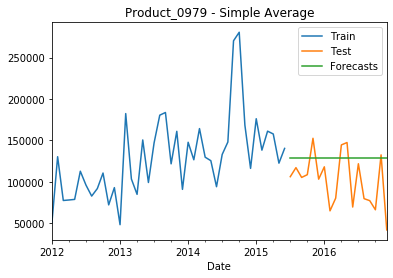

MAPE:  46.18269543160347 MPE:  -41.674027596498625 RMSE:  41128.57508118433


In [ ]:
# Preview
df1_train = df1_combined_monthly_train[["Product_0979"]]
df1_test = df1_combined_monthly_test[["Product_0979"]]
df1_forecasts = pd.DataFrame(index=df1_test.index, columns=["Product_0979"])
df1_forecasts["Product_0979"] = [df1_train.Product_0979.mean() for i in range(len(df1_test))]

plt.figure()
plt.title("Product_0979 - Simple Average")
df1_train.Product_0979.plot(label="Train")
df1_test.Product_0979.plot(label="Test")
df1_forecasts.Product_0979.plot(label="Forecasts")
plt.legend()
plt.savefig('C:\\Users\\renal\\Documents\\HEC Supervised Project\\simple_avg.jpg')
plt.show()

print("MAPE: ", mean_absolute_percentage_error(df1_test, df1_train.mean()),
      "MPE: ", mean_percentage_error(df1_test, df1_train.mean()),
      "RMSE: ", root_mean_square_error(df1_test, df1_train.mean())[0])

In [ ]:
# Create Dataframe for each product with Product_Name as index
forecast_errors_simple_avg = pd.DataFrame(columns=["Product", "MAPE", "MPE", "RMSE"])
forecast_errors_simple_avg["Product"] = significant_product_list

MAPE_list = []
MPE_list = []
RMSE_list = []
for product in significant_product_list:
  df1_train = df1_combined_monthly_train[[product]]
  df1_test = df1_combined_monthly_test[[product]]

  # Insert the forecast errors to the dataframe
  MAPE_list.append(mean_absolute_percentage_error(df1_test, df1_train.mean()))
  MPE_list.append(mean_percentage_error(df1_test, df1_train.mean()))
  RMSE_list.append(root_mean_square_error(df1_test, df1_train.mean())[0])

forecast_errors_simple_avg["MAPE"] = MAPE_list
forecast_errors_simple_avg["MPE"] = MPE_list
forecast_errors_simple_avg["RMSE"] = RMSE_list
forecast_errors_simple_avg.head()

,Product,MAPE,MPE,RMSE
0,Product_0979,46.182695,-41.674028,41128.575081
1,Product_1938,40.830318,15.588299,43.398355
2,Product_1451,22.021587,-9.165722,325015.857221
3,Product_1274,19.886233,-17.097127,296453.324013
4,Product_1512,26.212972,-9.500292,54882.652592


In [ ]:
forecast_errors_simple_avg.MAPE.mean()

77.22707661186799

### Moving Average (n=3)

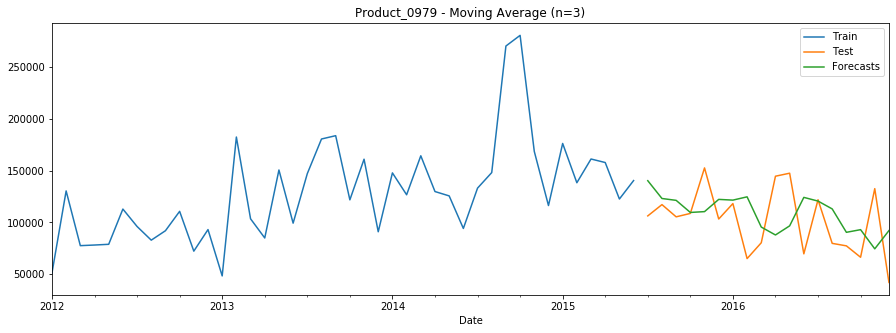

MAPE:  34.79015256171481 MPE:  -18.55218060797816 RMSE:  36510.614894849416


In [ ]:
# Preview
smoothed_values = [0,0,0]
df1 = df1_combined_monthly[["Product_0979"]]
for i in range(3, len(df1)):
  smoothed_values.append((df1.iloc[i-3, 0]+
                          df1.iloc[i-2, 0]+
                          df1.iloc[i-1, 0])/3)
df1["forecasts"] = smoothed_values
df1_forecasts = df1[int(train_percentage * len(df1)):][["forecasts"]]

plt.figure(figsize=(15,5))
plt.title("Product_0979 - Moving Average (n=3)")
df1_combined_monthly_train["Product_0979"].plot(label="Train")
df1_combined_monthly_test["Product_0979"].plot(label="Test")
df1_forecasts["forecasts"].plot(label="Forecasts")
plt.legend()
plt.savefig('C:\\Users\\renal\\Documents\\HEC Supervised Project\\moving_avg.jpg')
plt.show()

print("MAPE: ", mean_absolute_percentage_error(df1_combined_monthly_test[["Product_0979"]], df1_forecasts),
      "MPE: ", mean_percentage_error(df1_combined_monthly_test[["Product_0979"]], df1_forecasts),
      "RMSE: ", root_mean_square_error(df1_combined_monthly_test[["Product_0979"]], df1_forecasts)[0])

In [ ]:
# Create Dataframe for each product with Product_Name as index
forecast_errors_moving_average = pd.DataFrame(columns=["Product", "MAPE", "MPE", "RMSE"])
MAPE_list = []
MPE_list = []
RMSE_list = []

n = 3
train_percentage = 0.7
for product in significant_product_list:
  smoothed_values = [0,0,0]
  df1 = df1_combined_monthly[[product]]
  for i in range(3, len(df1)):
    smoothed_values.append((df1.iloc[i-3, 0]+
                            df1.iloc[i-2, 0]+
                            df1.iloc[i-1, 0])/3)
  df1["forecasts"] = smoothed_values
  train_len = int(train_percentage * len(df1))
  df2 = df1[train_len:]
  MAPE_list.append(mean_absolute_percentage_error(df2[[product]], df2[["forecasts"]]))
  MPE_list.append(mean_percentage_error(df2[[product]], df2[["forecasts"]]))
  RMSE_list.append(root_mean_square_error(df2[[product]], df2[["forecasts"]])[0])

forecast_errors_moving_average["Product"] = significant_product_list
forecast_errors_moving_average["RMSE"] = RMSE_list
forecast_errors_moving_average["MAPE"] = MAPE_list
forecast_errors_moving_average["MPE"] = MPE_list

forecast_errors_moving_average.head()

,Product,MAPE,MPE,RMSE
0,Product_0979,34.790153,-18.552181,36510.614895
1,Product_1938,51.805161,-24.767963,39.166864
2,Product_1451,27.568071,-14.922699,381402.763363
3,Product_1274,17.414737,-6.633146,291848.387834
4,Product_1512,29.678868,-10.803453,61513.385074


In [ ]:
forecast_errors_moving_average.MAPE.mean()

61.431375161265706

### Simple Exponential Smoothing

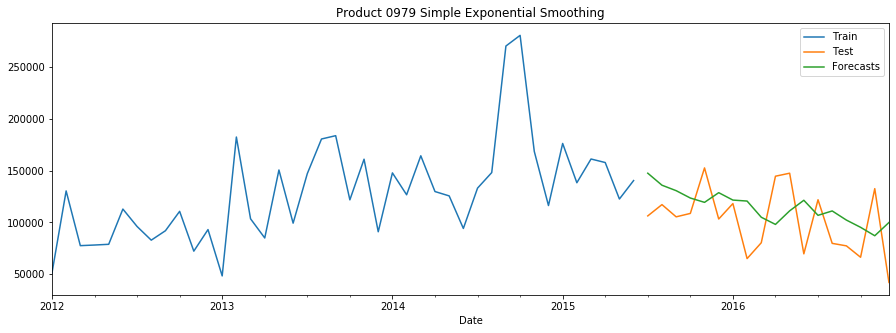

MAPE:  38.18197339295139 MPE:  -24.271702309135655 RMSE:  35417.9792759854


In [ ]:
# Preview
df1_train = df1_combined_monthly_train[["Product_0979"]]
df1 = df1_combined_monthly[["Product_0979"]]
mod = SimpleExpSmoothing(df1_train)
res = mod.fit(optimized=True)

mod_df1 = SimpleExpSmoothing(df1)
res_df1 = mod_df1.fit(optimized=False, smoothing_level=res.params["smoothing_level"], initial_level=res.params["initial_level"])

forecasts = res_df1.fittedvalues[train_len:] # Fitted values at time t equals to forecast of t-1

plt.figure(figsize=(15,5))
plt.title("Product 0979 Simple Exponential Smoothing")
df1_combined_monthly_train["Product_0979"].plot(label="Train")
df1_combined_monthly_test["Product_0979"].plot(label="Test")
forecasts.plot(label="Forecasts")
plt.legend()
plt.savefig('C:\\Users\\renal\\Documents\\HEC Supervised Project\\SES.jpg')
plt.show()

print("MAPE: ", mean_absolute_percentage_error(df1_combined_monthly_test["Product_0979"], forecasts),
      "MPE: ", mean_percentage_error(df1_combined_monthly_test["Product_0979"], forecasts),
      "RMSE: ", root_mean_square_error(df1_combined_monthly_test["Product_0979"], forecasts))

In [ ]:
forecast_errors_expsmoothing = pd.DataFrame(columns=["Product", "MAPE", "MPE", "RMSE"])
MAPE = []
MPE = []
RMSE = []

for product in significant_product_list:

  df1_train = df1_combined_monthly_train[[product]]
  df1 = df1_combined_monthly[[product]]
  mod = SimpleExpSmoothing(df1_train)
  res = mod.fit(optimized=True)
  
  mod_df1 = SimpleExpSmoothing(df1)
  res_df1 = mod_df1.fit(optimized=False, smoothing_level=res.params["smoothing_level"], initial_level=res.params["initial_level"])

  forecasts = res_df1.fittedvalues[train_len:]
  MAPE.append(mean_absolute_percentage_error(df1_combined_monthly_test[product], forecasts))
  MPE.append(mean_percentage_error(df1_combined_monthly_test[product], forecasts))
  RMSE.append(root_mean_square_error(df1_combined_monthly_test[product], forecasts))

forecast_errors_expsmoothing["Product"] = significant_product_list
forecast_errors_expsmoothing["MAPE"] = MAPE
forecast_errors_expsmoothing["MPE"] = MPE
forecast_errors_expsmoothing["RMSE"] = RMSE

forecast_errors_expsmoothing.head()

,Product,MAPE,MPE,RMSE
0,Product_0979,38.181973,-24.271702,35417.979276
1,Product_1938,49.253265,-25.045705,36.869114
2,Product_1451,26.625016,-15.226477,376525.905818
3,Product_1274,16.237251,-7.206841,274159.285149
4,Product_1512,30.155354,-10.697436,62654.290179


In [ ]:
forecast_errors_expsmoothing.MAPE.mean()

63.50768949864662

### Holt's

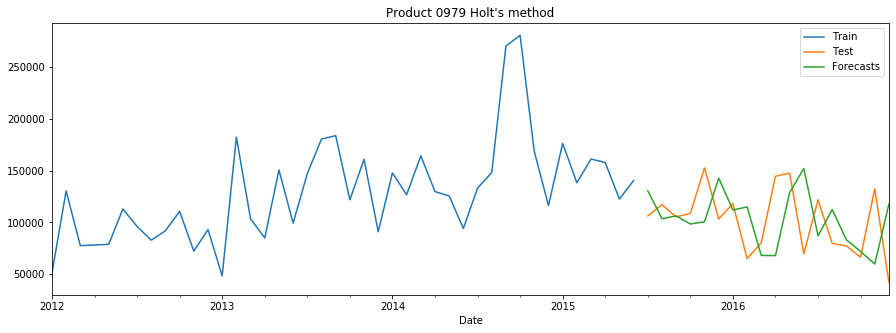

MAPE:  39.89510672187617 MPE:  -14.941234148269613 RMSE:  43574.46863494688


In [ ]:
# Preview

df1_train = df1_combined_monthly_train[["Product_0979"]]
df1 = df1_combined_monthly[["Product_0979"]]
mod = Holt(df1_train)
res = mod.fit(optimized=True)

mod_df1 = Holt(df1)
res_df1 = mod_df1.fit(optimized=False, 
                      smoothing_level=res.params["smoothing_level"],
                      smoothing_trend=res.params["smoothing_trend"],
                      initial_level=res.params["initial_level"],
                      initial_trend=res.params["initial_trend"])

forecasts = res_df1.fittedvalues[train_len:]

plt.figure(figsize=(15,5))
plt.title("Product 0979 Holt's method")
df1_combined_monthly_train["Product_0979"].plot(label="Train")
df1_combined_monthly_test["Product_0979"].plot(label="Test")
forecasts.plot(label="Forecasts")
plt.legend()
plt.savefig('C:\\Users\\renal\\Documents\\HEC Supervised Project\\Holt.jpg')
plt.show()

print("MAPE: ", mean_absolute_percentage_error(df1_combined_monthly_test["Product_0979"], forecasts),
      "MPE: ", mean_percentage_error(df1_combined_monthly_test["Product_0979"], forecasts),
      "RMSE: ", root_mean_square_error(df1_combined_monthly_test["Product_0979"], forecasts))

In [ ]:
forecast_errors_Holt = pd.DataFrame(columns=["Product", "MAPE", "MPE", "RMSE"])
MAPE = []
MPE = []
RMSE = []
for product in significant_product_list:

  df1_train = df1_combined_monthly_train[[product]]
  df1 = df1_combined_monthly[[product]]
  mod = Holt(df1_train)
  res = mod.fit(optimized=True)
  
  mod_df1 = Holt(df1)
  res_df1 = mod_df1.fit(optimized=False, 
                        smoothing_level=res.params["smoothing_level"],
                        smoothing_trend=res.params["smoothing_trend"],
                        initial_level=res.params["initial_level"],
                        initial_trend=res.params["initial_trend"])

  forecasts = res_df1.fittedvalues[train_len:]
  MAPE.append(mean_absolute_percentage_error(df1_combined_monthly_test[product], forecasts))
  MPE.append(mean_percentage_error(df1_combined_monthly_test[product], forecasts))
  RMSE.append(root_mean_square_error(df1_combined_monthly_test[product], forecasts))

forecast_errors_Holt["Product"] = significant_product_list
forecast_errors_Holt["MAPE"] = MAPE
forecast_errors_Holt["MPE"] = MPE
forecast_errors_Holt["RMSE"] = RMSE

In [ ]:
forecast_errors_Holt.head()

,Product,MAPE,MPE,RMSE
0,Product_0979,39.895107,-14.941234,43574.468635
1,Product_1938,54.213531,-34.890105,37.104595
2,Product_1451,32.677917,-17.491151,454740.969639
3,Product_1274,22.684154,-8.591409,366578.236935
4,Product_1512,39.232688,-14.694363,81811.069725


### Holt-Winter's (S=12)

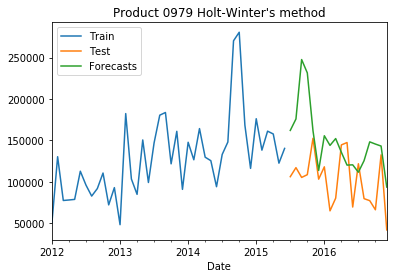

MAPE:  61.89014326461274 MPE:  -58.22932342852756 RMSE:  64351.620393881596


In [ ]:
# Preview

df1_train = df1_combined_monthly_train[["Product_0979"]]
df1 = df1_combined_monthly[["Product_0979"]]
mod = ExponentialSmoothing(df1_train, trend="add", seasonal_periods=12, seasonal="add")
res = mod.fit(optimized=True)

mod_df1 = ExponentialSmoothing(df1, trend="add", seasonal_periods=12, seasonal="add",
                                initialization_method="known",
                                initial_level=res.params["initial_level"],
                                initial_trend=res.params["initial_trend"],
                                initial_seasonal=res.params["initial_seasons"])
res_df1 = mod_df1.fit(smoothing_level=res.params["smoothing_level"],
                      smoothing_trend=res.params["smoothing_trend"],
                      smoothing_seasonal=res.params["smoothing_seasonal"])

forecasts = res_df1.fittedvalues[train_len:]

plt.figure()
plt.title("Product 0979 Holt-Winter's method")
df1_combined_monthly_train["Product_0979"].plot(label="Train")
df1_combined_monthly_test["Product_0979"].plot(label="Test")
forecasts.plot(label="Forecasts")
plt.legend()
plt.savefig('C:\\Users\\renal\\Documents\\HEC Supervised Project\\HW.jpg')
plt.show()

print("MAPE: ", mean_absolute_percentage_error(df1_combined_monthly_test["Product_0979"], forecasts),
      "MPE: ", mean_percentage_error(df1_combined_monthly_test["Product_0979"], forecasts),
      "RMSE: ", root_mean_square_error(df1_combined_monthly_test["Product_0979"], forecasts))

In [ ]:
forecast_errors_HoltWinters = pd.DataFrame(columns=["Product", "MAPE", "MPE", "RMSE"])
MAPE = []
MPE = []
RMSE = []
for product in significant_product_list:

  df1_train = df1_combined_monthly_train[[product]]
  df1 = df1_combined_monthly[[product]]
  mod = ExponentialSmoothing(df1_train, trend="add", seasonal_periods=12, seasonal="add")
  res = mod.fit(optimized=True)
  
  mod_df1 = ExponentialSmoothing(df1, trend="add", seasonal_periods=12, seasonal="add",
                                 initialization_method="known",
                                 initial_level=res.params["initial_level"],
                                 initial_trend=res.params["initial_trend"],
                                 initial_seasonal=res.params["initial_seasons"])
  res_df1 = mod_df1.fit(smoothing_level=res.params["smoothing_level"],
                        smoothing_trend=res.params["smoothing_trend"],
                        smoothing_seasonal=res.params["smoothing_seasonal"])

  forecasts = res_df1.fittedvalues[train_len:]
  MAPE.append(mean_absolute_percentage_error(df1_combined_monthly_test[product], forecasts))
  MPE.append(mean_percentage_error(df1_combined_monthly_test[product], forecasts))
  RMSE.append(sm.tools.eval_measures.rmse(df1_combined_monthly_test[product], forecasts))

forecast_errors_HoltWinters["Product"] = significant_product_list
forecast_errors_HoltWinters["MAPE"] = MAPE
forecast_errors_HoltWinters["MPE"] = MPE
forecast_errors_HoltWinters["RMSE"] = RMSE

forecast_errors_HoltWinters.head()

,Product,MAPE,MPE,RMSE
0,Product_0979,61.890143,-58.229323,64351.620394
1,Product_1938,41.732734,-20.234892,31.115118
2,Product_1451,24.020188,-16.201703,339006.227000
3,Product_1274,13.154734,-6.971291,226257.061255
4,Product_1512,25.514550,-8.638945,54279.780790


### ARIMA

In [ ]:
# This the ARIMA function. It returns the dictionary of each product to its:
  # Best model Order based on minimum AIC
  # The train AIC
  # Fitted values of the train data
  # The generated Forecasts
  # The prediction intervals

from statsmodels.tsa.arima.model import ARIMA

def arima_func(product, dataframe, return_dict):
    
    # Assign the endogenous model
    endog = dataframe

    # Setup forecasts
    nforecasts = 1
    forecasts = {}

    # Get the number of initial training observations
    train_percentage = 0.7
    nobs = len(endog)
    n_init_training = int(nobs * train_percentage)

    # Dictionary of model order to the fitted model and its corresponding statistics
    ARIMA_model_dict = {}
    aic = 99999999
    
    # Create model for initial training sample, fit parameters
    training_endog = endog.iloc[:n_init_training]
    for p in range(0,4):
      for d in range(0,4):
        for q in range(0,4):    
          try:         
            mod = ARIMA(training_endog, order=(p,d,q))
            res = mod.fit()

            if res.aic < aic:
                aic = res.aic

                ARIMA_model_dict["Model_Order"] = (p,d,q)
                ARIMA_model_dict["train_AIC"] = aic
                ARIMA_model_dict["train_fittedvalues"] = res.fittedvalues

                # Initial forecast and prediction interval DataFrame
                df_forecast = res.get_forecast(steps=1).predicted_mean
                df_prediction_interval = res.get_forecast(steps=1).conf_int(alpha=0.05)

                # Iterate through the rest of the sample
                for t in range(n_init_training, nobs):
                    # Update the results by appending the next observation
                    updated_endog = endog.iloc[t:t+1]
                    res = res.append(updated_endog, refit=False)

                    # Save the new set of forecasts and prediction intervals
                    forecast_object = res.get_forecast(1)
                    df_forecast = df_forecast.append(forecast_object.predicted_mean)
                    df_prediction_interval = df_prediction_interval.append(forecast_object.conf_int(alpha=0.05))

                ARIMA_model_dict["forecasts"] = df_forecast
                ARIMA_model_dict["prediction_intervals"] = df_prediction_interval
          except:
            print(product, "Model Order", (p,d,q), "could not be fitted")

    return_dict[product] = ARIMA_model_dict

    return

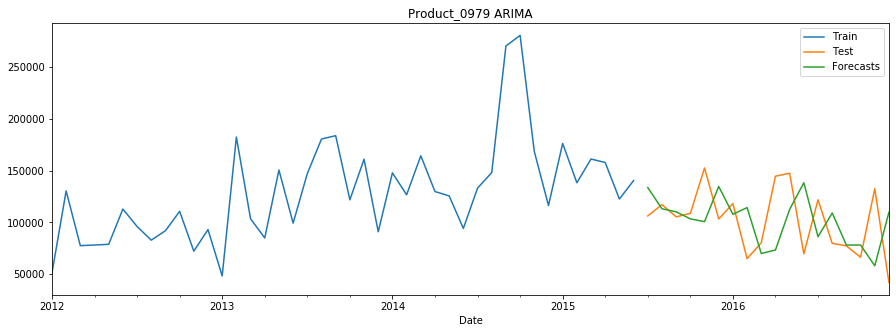

MAPE:  37.40728867501184 MPE:  -12.724700310706272 RMSE:  41174.36100107913


In [ ]:
# Preview
arima_func("Product_0979", df1_combined_monthly[["Product_0979"]], product_ARIMA_dict)

plt.figure(figsize=(15,5))
plt.title("Product_0979 ARIMA")
df1_combined_monthly_train["Product_0979"].plot(label="Train")
df1_combined_monthly_test["Product_0979"].plot(label="Test")
product_ARIMA_dict["Product_0979"]["forecasts"][:-1].plot(label="Forecasts") # The last datapoint is not counted as it's the forecast outside the test dataset
plt.legend()
plt.savefig('C:\\Users\\renal\\Documents\\HEC Supervised Project\\ARIMA.jpg')
plt.show()

print("MAPE: ", mean_absolute_percentage_error(df1_combined_monthly_test["Product_0979"], product_ARIMA_dict["Product_0979"]["forecasts"][:-1]),
      "MPE: ", mean_percentage_error(df1_combined_monthly_test["Product_0979"], product_ARIMA_dict["Product_0979"]["forecasts"][:-1]),
      "RMSE: ", root_mean_square_error(df1_combined_monthly_test["Product_0979"], product_ARIMA_dict["Product_0979"]["forecasts"][:-1]))

In [ ]:
import time
starttime = time.time()
countup = 0
countdown = len(significant_product_list)

product_ARIMA_dict = {}
for product in significant_product_list:
  arima_func(product, df1_combined_monthly[[product]], product_ARIMA_dict)
  time_elapsed = time.time() - starttime
  countup += 1
  countdown -= 1
  time_left = time_elapsed/countup*countdown
  print("Products evaluated:", countup,
        "Products left to evaluate:", countdown,
        "Time elapsed (seconds):", time_elapsed,
        "Expected Time left (seconds):", time_left)
  
print("ARIMA modelling complete")

Products evaluated: 1 Products left to evaluate: 240 Time elapsed (seconds): 14.667933225631714 Expected Time left (seconds): 3520.3039741516113
Products evaluated: 2 Products left to evaluate: 239 Time elapsed (seconds): 27.64005208015442 Expected Time left (seconds): 3302.986223578453
Products evaluated: 3 Products left to evaluate: 238 Time elapsed (seconds): 41.63980746269226 Expected Time left (seconds): 3303.424725373586
Products evaluated: 4 Products left to evaluate: 237 Time elapsed (seconds): 56.27574324607849 Expected Time left (seconds): 3334.3377873301506
Products evaluated: 5 Products left to evaluate: 236 Time elapsed (seconds): 69.66197538375854 Expected Time left (seconds): 3288.0452381134032
Products evaluated: 6 Products left to evaluate: 235 Time elapsed (seconds): 81.63186836242676 Expected Time left (seconds): 3197.2481775283813
Products evaluated: 7 Products left to evaluate: 234 Time elapsed (seconds): 96.21718907356262 Expected Time left (seconds): 3216.4031776

In [ ]:
forecast_errors_ARIMA = pd.DataFrame(columns=["Product", "MAPE", "MPE", "RMSE"])
mape_list = []
mpe_list = []
rmse_list = []

for product in product_ARIMA_dict:
  mape = mean_absolute_percentage_error(df1_combined_monthly_test[product],
                                        product_ARIMA_dict[product]["forecasts"][:-1])
  mpe = mean_percentage_error(df1_combined_monthly_test[product],
                              product_ARIMA_dict[product]["forecasts"][:-1])
  rmse = root_mean_square_error(df1_combined_monthly_test[product],
                                product_ARIMA_dict[product]["forecasts"][:-1])
  
  mape_list.append(mape)
  mpe_list.append(mpe)
  rmse_list.append(rmse)

forecast_errors_ARIMA["Product"] = significant_product_list
forecast_errors_ARIMA["MAPE"] = mape_list
forecast_errors_ARIMA["MPE"] = mpe_list
forecast_errors_ARIMA["RMSE"] = rmse_list

forecast_errors_ARIMA.head()

,Product,MAPE,MPE,RMSE
0,Product_0979,37.407289,-12.724700,41174.361001
1,Product_1938,56.173673,-37.355946,37.553967
2,Product_1451,32.766431,-17.293336,456450.734998
3,Product_1274,22.142079,-7.633593,362677.645145
4,Product_1512,35.258136,-15.578315,71577.815140


### SARIMA

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

def sarima_func(product, dataframe, return_dict):
    
    # Assign the endogenous model
    endog = dataframe

    # Setup forecasts
    nforecasts = 1
    forecasts = {}

    # Get the number of initial training observations
    train_percentage = 0.7
    nobs = len(endog)
    n_init_training = int(nobs * train_percentage)

    # Dictionary of model order to the fitted model and its corresponding statistics
    SARIMA_model_dict = {}
    aic = 99999999
    
    # Create model for initial training sample, fit parameters
    training_endog = endog.iloc[:n_init_training]
    for p in range(0,2):
      for d in range(0,2):
        for q in range(0,2):
          for P in range(0,2):
            for D in range(0,2):
              for Q in range(0,2):
                try:             
                  mod = SARIMAX(training_endog, order=(p,d,q), seasonal_order=(P,D,Q,12))
                  res = mod.fit()

                  if res.aic < aic:
                      aic = res.aic

                      SARIMA_model_dict["Model_Order"] = ((p,d,q),(P,D,Q))
                      SARIMA_model_dict["train_AIC"] = aic
                      SARIMA_model_dict["train_fittedvalues"] = res.fittedvalues

                      # Initial forecast and prediction interval DataFrame
                      df_forecast = res.get_forecast(steps=1).predicted_mean
                      df_prediction_interval = res.get_forecast(steps=1).conf_int(alpha=0.05)

                      # Iterate through the rest of the sample
                      for t in range(n_init_training, nobs):
                          # Update the results by appending the next observation
                          updated_endog = endog.iloc[t:t+1]
                          res = res.append(updated_endog, refit=False)

                          # Save the new set of forecasts and prediction intervals
                          forecast_object = res.get_forecast(1)
                          df_forecast = df_forecast.append(forecast_object.predicted_mean)
                          df_prediction_interval = df_prediction_interval.append(forecast_object.conf_int(alpha=0.05))

                      SARIMA_model_dict["forecasts"] = df_forecast
                      SARIMA_model_dict["prediction_intervals"] = df_prediction_interval

                except:
                  print(product, "Model Order", (p,d,q), (P,D,Q), "could not be fitted")

    return_dict[product] = SARIMA_model_dict

    return

In [ ]:
import time
starttime = time.time()
countup = 0
countdown = len(significant_product_list)

product_SARIMA_dict = {}
for product in significant_product_list:
  sarima_func(product, df1_combined_monthly[[product]], product_SARIMA_dict)
  
  time_elapsed = time.time() - starttime
  countup += 1
  countdown -= 1
  time_left = time_elapsed/countup*countdown
  print("Products evaluated:", countup,
        "Products left to evaluate:", countdown,
        "Time elapsed (seconds):", time_elapsed,
        "Expected Time left (seconds):", time_left)
  
print("SARIMA modelling complete")

Products evaluated: 1 Products left to evaluate: 240 Time elapsed (seconds): 14.9839506149292 Expected Time left (seconds): 3596.148147583008
Products evaluated: 2 Products left to evaluate: 239 Time elapsed (seconds): 34.41619324684143 Expected Time left (seconds): 4112.735092997551
Products evaluated: 3 Products left to evaluate: 238 Time elapsed (seconds): 49.304383277893066 Expected Time left (seconds): 3911.4810733795166
Products evaluated: 4 Products left to evaluate: 237 Time elapsed (seconds): 66.68501663208008 Expected Time left (seconds): 3951.0872354507446
Products evaluated: 5 Products left to evaluate: 236 Time elapsed (seconds): 81.44941186904907 Expected Time left (seconds): 3844.412240219116
Products evaluated: 6 Products left to evaluate: 235 Time elapsed (seconds): 95.58969783782959 Expected Time left (seconds): 3743.929831981659
Products evaluated: 7 Products left to evaluate: 234 Time elapsed (seconds): 107.77638578414917 Expected Time left (seconds): 3602.810610498

In [ ]:
forecast_errors_SARIMA = pd.DataFrame(columns=["Product", "MAPE", "MPE", "RMSE"])
mape_list = []
mpe_list = []
rmse_list = []

for product in product_SARIMA_dict:
  mape = mean_absolute_percentage_error(df1_combined_monthly_test[product],
                                        product_SARIMA_dict[product]["forecasts"][:-1])
  mpe = mean_percentage_error(df1_combined_monthly_test[product],
                              product_SARIMA_dict[product]["forecasts"][:-1])
  rmse = root_mean_square_error(df1_combined_monthly_test[product],
                                product_SARIMA_dict[product]["forecasts"][:-1])
  
  mape_list.append(mape)
  mpe_list.append(mpe)
  rmse_list.append(rmse)

forecast_errors_SARIMA["Product"] = significant_product_list
forecast_errors_SARIMA["MAPE"] = mape_list
forecast_errors_SARIMA["MPE"] = mpe_list
forecast_errors_SARIMA["RMSE"] = rmse_list

forecast_errors_SARIMA.head()

,Product,MAPE,MPE,RMSE
0,Product_0979,47.552768,-30.865721,65809.197733
1,Product_1938,57.453023,-37.065623,41.823819
2,Product_1451,41.458248,-19.953110,573634.945663
3,Product_1274,17.046418,-8.566229,305367.438750
4,Product_1512,22.375494,-6.405410,48793.079992


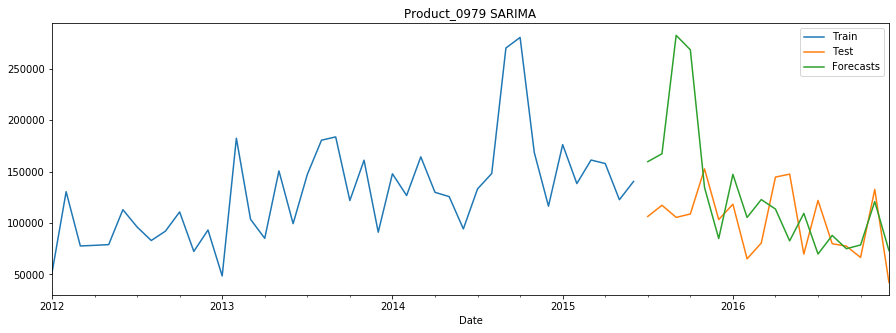

MAPE:  47.55276782905616 MPE:  -30.86572072862342 RMSE:  65809.19773284308


In [ ]:
# Preview
sarima_func("Product_0979", df1_combined_monthly[["Product_0979"]], product_ARIMA_dict)

plt.figure(figsize=(15,5))
plt.title("Product_0979 SARIMA")
df1_combined_monthly_train["Product_0979"].plot(label="Train")
df1_combined_monthly_test["Product_0979"].plot(label="Test")
product_ARIMA_dict["Product_0979"]["forecasts"][:-1].plot(label="Forecasts") # The last datapoint is not counted as it's the forecast outside the test dataset
plt.legend()
plt.savefig('C:\\Users\\renal\\Documents\\HEC Supervised Project\\SARIMA.jpg')
plt.show()

print("MAPE: ", mean_absolute_percentage_error(df1_combined_monthly_test["Product_0979"], product_SARIMA_dict["Product_0979"]["forecasts"][:-1]),
      "MPE: ", mean_percentage_error(df1_combined_monthly_test["Product_0979"], product_SARIMA_dict["Product_0979"]["forecasts"][:-1]),
      "RMSE: ", root_mean_square_error(df1_combined_monthly_test["Product_0979"], product_SARIMA_dict["Product_0979"]["forecasts"][:-1]))

### Causality Test

In [ ]:
# Start Time Count
import time
start_time = time.time()

from statsmodels.tsa.stattools import grangercausalitytests
maxlag=3
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    counter = 0
    products_left = len(data.columns)
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value

        # Count time elapsed
        counter += 1
        products_left -= 1
        elapsed_time = time.time() - start_time
        print("Time elapsed: ", elapsed_time, "Expected Time Left:", elapsed_time/counter*products_left) # CPU seconds elapsed (floating point)

    df.columns = [var for var in variables]
    df.index = [var for var in variables]
    return df

causality_test_df1 = grangers_causation_matrix(df1_combined_monthly, variables = df1_combined_monthly.columns)
print(causality_test_df1.head())
print("Columns are predictors, Rows are response variables")

# Count time elapsed
elapsed_time = time.time() - start_time
print("Time elapsed: ", elapsed_time) # CPU seconds elapsed (floating point)

# Sound Checkpoint
import winsound
duration = 10000  # milliseconds
freq = 777  # Hz
winsound.Beep(freq, duration)

Time elapsed:  2.2317299842834473 Expected Time Left: 535.6151962280273
Time elapsed:  4.311516284942627 Expected Time Left: 515.2261960506439
Time elapsed:  6.298383712768555 Expected Time Left: 499.6717745463053
Time elapsed:  8.349200963973999 Expected Time Left: 494.69015711545944
Time elapsed:  10.406015872955322 Expected Time Left: 491.16394920349126
Time elapsed:  12.373879194259644 Expected Time Left: 484.6436017751694
Time elapsed:  14.404708862304688 Expected Time Left: 481.5288391113281
Time elapsed:  16.41854691505432 Expected Time Left: 478.1901789009571
Time elapsed:  18.4343843460083 Expected Time Left: 475.1974631415473
Time elapsed:  20.461214303970337 Expected Time Left: 472.6540504217148
Time elapsed:  22.49783992767334 Expected Time Left: 470.40938030589706
Time elapsed:  24.49268889427185 Expected Time Left: 467.40214639902115
Time elapsed:  26.5085129737854 Expected Time Left: 464.91853523254395
Time elapsed:  28.53935432434082 Expected Time Left: 462.745245116097

In [ ]:
causality_test_df1

,Product_0979,Product_1938,Product_1451,Product_1274,Product_1512,Product_1970,Product_1372,Product_1248,Product_1278,Product_1359,...,Product_1954,Product_1526,Product_1388,Product_1276,Product_0123,Product_1423,Product_1422,Product_0361,Product_0139,Product_1519
Product_0979,1.0000,0.8319,0.3088,0.5263,0.0977,0.0036,0.6780,0.8142,0.5863,0.1926,...,0.9588,0.7131,0.9198,0.7347,0.2344,0.4552,0.5404,0.0806,0.3626,0.2500
Product_1938,0.8405,1.0000,0.6867,0.0299,0.8285,0.7792,0.6946,0.7631,0.1826,0.0860,...,0.1224,0.6857,0.3287,0.4938,0.0171,0.5439,0.9172,0.8451,0.1316,0.6456
Product_1451,0.1277,0.8461,1.0000,0.0667,0.1037,0.0581,0.6459,0.5953,0.6271,0.1393,...,0.7627,0.6906,0.6851,0.6559,0.8080,0.1349,0.4110,0.5589,0.5481,0.8418
Product_1274,0.3112,0.0024,0.0226,1.0000,0.9219,0.9655,0.7027,0.1555,0.7511,0.3585,...,0.0755,0.0400,0.2035,0.6969,0.0857,0.1409,0.3843,0.6578,0.4439,0.1705
Product_1512,0.9268,0.7567,0.2343,0.6129,1.0000,0.5962,0.4776,0.8847,0.0521,0.1774,...,0.4261,0.3517,0.5691,0.3800,0.9780,0.3058,0.3004,0.5327,0.9484,0.9846
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Product_1423,0.2105,0.4822,0.1843,0.2236,0.2321,0.6248,0.6331,0.1348,0.6574,0.7827,...,0.5443,0.5537,0.9569,0.5432,0.8108,1.0000,0.6928,0.6931,0.2638,0.8518
Product_1422,0.3269,0.2272,0.5093,0.9123,0.8461,0.1592,0.3496,0.2004,0.3888,0.0296,...,0.4240,0.9309,0.3084,0.1665,0.0364,0.6771,1.0000,0.6269,0.1833,0.2789
Product_0361,0.9054,0.8399,0.9353,0.8306,0.9368,0.1701,0.8013,0.9178,0.6055,0.1585,...,0.8407,0.7755,0.7741,0.6207,0.9345,0.2731,0.3947,1.0000,0.4746,0.2278
Product_0139,0.4778,0.4169,0.6984,0.6555,0.5704,0.2855,0.1765,0.2235,0.5426,0.9630,...,0.2504,0.7188,0.4505,0.0686,0.3962,0.0636,0.6732,0.5399,1.0000,0.2627


In [ ]:
# Make a dictionary of a list of predictors for each product with p-value < 0.05 
predictors_dict = {}
predictors_dict_filtered = {}

for index in causality_test_df1.index:
  predictors_dict[index] = []
  for columns in causality_test_df1.columns:
    if causality_test_df1.loc[index, columns] < 0.05:
      predictors_dict[index].append(columns)
  
  # Filters the dictionary further to the top 2 predictors based on p-value because of computational limitations 

  df1 = causality_test_df1.loc[[index]]
  predictors_dict[index] = df1.sort_values(by=index, axis=1).columns.tolist()[:2]

In [ ]:
predictors_dict

{'Product_0979': ['Product_1825', 'Product_1823'],
 'Product_1938': ['Product_0011', 'Product_1392'],
 'Product_1451': ['Product_1450', 'Product_1349'],
 'Product_1274': ['Product_0677', 'Product_1470'],
 'Product_1512': ['Product_0209', 'Product_1766'],
 'Product_1970': ['Product_1286', 'Product_1287'],
 'Product_1372': ['Product_0979', 'Product_1570'],
 'Product_1248': ['Product_2027', 'Product_1360'],
 'Product_1278': ['Product_0409', 'Product_0407'],
 'Product_1359': ['Product_0677', 'Product_2132'],
 'Product_1270': ['Product_1158', 'Product_1519'],
 'Product_1581': ['Product_1512', 'Product_1195'],
 'Product_2004': ['Product_0779', 'Product_1371'],
 'Product_0071': ['Product_1454', 'Product_1401'],
 'Product_1570': ['Product_0981', 'Product_0984'],
 'Product_0083': ['Product_0408', 'Product_0905'],
 'Product_1502': ['Product_1981', 'Product_1134'],
 'Product_1241': ['Product_0981', 'Product_0643'],
 'Product_0639': ['Product_2132', 'Product_1886'],
 'Product_1431': ['Product_0083

### VAR

In [ ]:
import time
import multiprocessing
from multiprocessing import Process, Queue, Manager
from statsmodels.tsa.statespace.varmax import VARMAX

import varma_func

batch_size = len(significant_product_list)/4
batched_lists = []
for i in range(0,4):
  batched_lists.append(significant_product_list[int(i*batch_size):int((i+1)*batch_size)])

VAR_model_dict = {}

for batched_list in batched_lists:
  dataframes_list = []
  for product in batched_list:  
    dataframes_list.append((product, df1_combined_monthly[[product] + predictors_dict[product]].astype("float")))

  if __name__ == '__main__':
      manager = multiprocessing.Manager()
      return_dict = manager.dict()

      starttime = time.time()
      processes = []

      for product, dataframe in dataframes_list:
          p = Process(target=varma_func.var_func, args=(product, dataframe, return_dict))
          processes.append(p)
          p.start()
          
      for process in processes:
          process.join()
      
      print('Batch processed. Time elapsed: {} seconds'.format(time.time() - starttime))

  for product in return_dict:
    VAR_model_dict[product] = return_dict[product]

# Sound Checkpoint
import winsound
duration = 10000  # milliseconds
freq = 777  # Hz
winsound.Beep(freq, duration)

Batch processed. Time elapsed: 2648.945695400238 seconds
Batch processed. Time elapsed: 2896.8131124973297 seconds
Batch processed. Time elapsed: 2668.904656648636 seconds
Batch processed. Time elapsed: 2752.2436740398407 seconds


In [ ]:
forecast_errors_VAR = pd.DataFrame(columns=["Product", "MAPE", "MPE", "RMSE"])
mape_list = []
mpe_list = []
rmse_list = []

for product in VAR_model_dict:
  mape = mean_absolute_percentage_error(df1_combined_monthly_test[product],
                                        VAR_model_dict[product]["forecasts"][product][:-1])
  mpe = mean_percentage_error(df1_combined_monthly_test[product],
                              VAR_model_dict[product]["forecasts"][product][:-1])
  rmse = root_mean_square_error(df1_combined_monthly_test[product],
                                VAR_model_dict[product]["forecasts"][product][:-1])
  
  mape_list.append(mape)
  mpe_list.append(mpe)
  rmse_list.append(rmse)

forecast_errors_VAR["Product"] = significant_product_list
forecast_errors_VAR["MAPE"] = mape_list
forecast_errors_VAR["MPE"] = mpe_list
forecast_errors_VAR["RMSE"] = rmse_list

forecast_errors_VAR.head()

,Product,MAPE,MPE,RMSE
0,Product_0979,25.880553,-10.360041,28532.170151
1,Product_1938,20.072871,13.314819,51931.498852
2,Product_1451,18.920420,5.364334,14106.118009
3,Product_1274,25.959568,-8.118262,83754.689073
4,Product_1512,10.547112,5.115734,242465.257945


In [ ]:
forecast_errors_VAR.MAPE.mean()

67.30199620412715

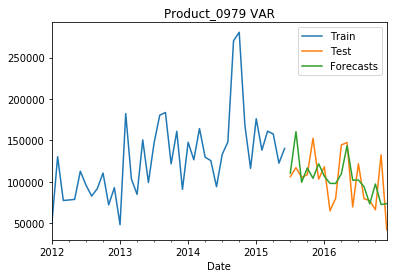

MAPE:  25.880552860344945 MPE:  -10.360041056761318 RMSE:  28532.170151141934


In [ ]:
# Preview

plt.figure()
plt.title("Product_0979 VAR")
df1_combined_monthly_train["Product_0979"].plot(label="Train")
df1_combined_monthly_test["Product_0979"].plot(label="Test")
VAR_model_dict["Product_0979"]["forecasts"]["Product_0979"][:-1].plot(label="Forecasts") # The last datapoint is not counted as it's the forecast outside the test dataset
plt.legend()
plt.savefig('C:\\Users\\renal\\Documents\\HEC Supervised Project\\VAR.jpg')
plt.show()

print("MAPE: ", mean_absolute_percentage_error(df1_combined_monthly_test["Product_0979"], VAR_model_dict["Product_0979"]["forecasts"]["Product_0979"][:-1]),
      "MPE: ", mean_percentage_error(df1_combined_monthly_test["Product_0979"], VAR_model_dict["Product_0979"]["forecasts"]["Product_0979"][:-1]),
      "RMSE: ", root_mean_square_error(df1_combined_monthly_test["Product_0979"], VAR_model_dict["Product_0979"]["forecasts"]["Product_0979"][:-1]))

### VMA

In [ ]:
import time
import multiprocessing
from multiprocessing import Process, Queue, Manager
from statsmodels.tsa.statespace.varmax import VARMAX

import varma_func

batch_size = len(significant_product_list)/4
batched_lists = []
for i in range(0,4):
  batched_lists.append(significant_product_list[int(i*batch_size):int((i+1)*batch_size)])

VMA_model_dict = {}

for batched_list in batched_lists:
  dataframes_list = []
  for product in batched_list:  
    dataframes_list.append((product, df1_combined_monthly[[product] + predictors_dict[product]].astype("float")))

  if __name__ == '__main__':
      manager = multiprocessing.Manager()
      return_dict = manager.dict()

      starttime = time.time()
      processes = []

      for product, dataframe in dataframes_list:
          p = Process(target=varma_func.vma_func, args=(product, dataframe, return_dict))
          processes.append(p)
          p.start()
          
      for process in processes:
          process.join()
      
      print('That took {} seconds'.format(time.time() - starttime))

  for product in return_dict:
    VMA_model_dict[product] = return_dict[product]

# Sound Checkpoint
import winsound
duration = 10000  # milliseconds
freq = 777  # Hz
winsound.Beep(freq, duration)

That took 2453.406848192215 seconds
That took 2283.823737382889 seconds
That took 2319.823005437851 seconds
That took 2338.201750278473 seconds


In [ ]:
forecast_errors_VMA = pd.DataFrame(columns=["Product", "MAPE", "MPE", "RMSE"])
mape_list = []
mpe_list = []
rmse_list = []

for product in VMA_model_dict:
  mape = mean_absolute_percentage_error(df1_combined_monthly_test[product],
                                        VMA_model_dict[product]["forecasts"][product][:-1])
  mpe = mean_percentage_error(df1_combined_monthly_test[product],
                              VMA_model_dict[product]["forecasts"][product][:-1])
  rmse = root_mean_square_error(df1_combined_monthly_test[product],
                                VMA_model_dict[product]["forecasts"][product][:-1])
  
  mape_list.append(mape)
  mpe_list.append(mpe)
  rmse_list.append(rmse)

forecast_errors_VMA["Product"] = significant_product_list
forecast_errors_VMA["MAPE"] = mape_list
forecast_errors_VMA["MPE"] = mpe_list
forecast_errors_VMA["RMSE"] = rmse_list

forecast_errors_VMA.head()

,Product,MAPE,MPE,RMSE
0,Product_0979,30.680508,-14.712491,33112.612531
1,Product_1938,26.063584,-15.375576,51565.331109
2,Product_1451,89.987795,-16.472526,252943.755684
3,Product_1274,31.179943,28.382272,365987.696352
4,Product_1512,12.041425,1.444108,222995.389860


In [ ]:
forecast_errors_VMA.MAPE.mean()

131.78017177712204

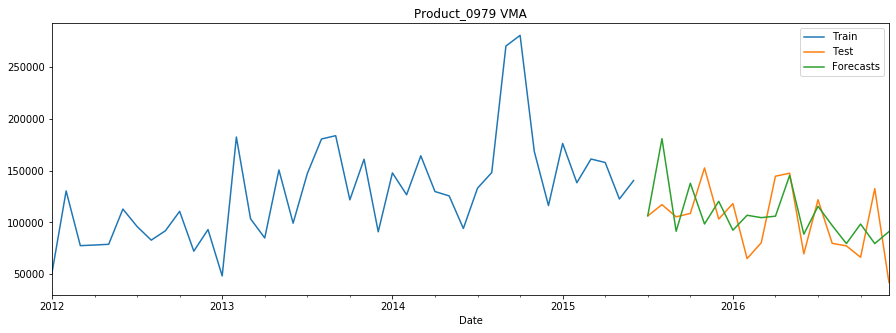

MAPE:  30.680508348101238 MPE:  -14.712490604072359 RMSE:  33112.612530856895


In [ ]:
# Preview

plt.figure(figsize=(15,5))
plt.title("Product_0979 VMA")
df1_combined_monthly_train["Product_0979"].plot(label="Train")
df1_combined_monthly_test["Product_0979"].plot(label="Test")
VMA_model_dict["Product_0979"]["forecasts"]["Product_0979"][:-1].plot(label="Forecasts") # The last datapoint is not counted as it's the forecast outside the test dataset
plt.legend()
plt.savefig('C:\\Users\\renal\\Documents\\HEC Supervised Project\\VMA.jpg')
plt.show()

print("MAPE: ", mean_absolute_percentage_error(df1_combined_monthly_test["Product_0979"], VMA_model_dict["Product_0979"]["forecasts"]["Product_0979"][:-1]),
      "MPE: ", mean_percentage_error(df1_combined_monthly_test["Product_0979"], VMA_model_dict["Product_0979"]["forecasts"]["Product_0979"][:-1]),
      "RMSE: ", root_mean_square_error(df1_combined_monthly_test["Product_0979"], VMA_model_dict["Product_0979"]["forecasts"]["Product_0979"][:-1]))

### VARMA

In [ ]:
import time
import multiprocessing
from multiprocessing import Process, Queue, Manager
from statsmodels.tsa.statespace.varmax import VARMAX

import varma_func

batch_size = len(significant_product_list)/4
batched_lists = []
for i in range(0,4):
  batched_lists.append(significant_product_list[int(i*batch_size):int((i+1)*batch_size)])

VARMA_model_dict = {}

for batched_list in batched_lists:
  dataframes_list = []
  for product in batched_list:  
    dataframes_list.append((product, df1_combined_monthly[[product] + predictors_dict[product]].astype("float")))

  if __name__ == '__main__':
      manager = multiprocessing.Manager()
      return_dict = manager.dict()

      starttime = time.time()
      processes = []

      for product, dataframe in dataframes_list:
          p = Process(target=varma_func.varma_func, args=(product, dataframe, return_dict))
          processes.append(p)
          p.start()
          
      for process in processes:
          process.join()
      
      print('That took {} seconds'.format(time.time() - starttime))

  for product in return_dict:
    VARMA_model_dict[product] = return_dict[product]

# Sound Checkpoint
import winsound
duration = 10000  # milliseconds
freq = 777  # Hz
winsound.Beep(freq, duration)

That took 699.6466193199158 seconds
That took 740.6751546859741 seconds
That took 653.7680196762085 seconds
That took 706.8953485488892 seconds


In [ ]:
forecast_errors_VARMA = pd.DataFrame(columns=["Product", "MAPE", "MPE", "RMSE"])
mape_list = []
mpe_list = []
rmse_list = []

for product in VARMA_model_dict:
  mape = mean_absolute_percentage_error(df1_combined_monthly_test[product],
                                        VARMA_model_dict[product]["forecasts"][product][:-1])
  mpe = mean_percentage_error(df1_combined_monthly_test[product],
                              VARMA_model_dict[product]["forecasts"][product][:-1])
  rmse = root_mean_square_error(df1_combined_monthly_test[product],
                                VARMA_model_dict[product]["forecasts"][product][:-1])
  
  mape_list.append(mape)
  mpe_list.append(mpe)
  rmse_list.append(rmse)

forecast_errors_VARMA["Product"] = significant_product_list
forecast_errors_VARMA["MAPE"] = mape_list
forecast_errors_VARMA["MPE"] = mpe_list
forecast_errors_VARMA["RMSE"] = rmse_list

forecast_errors_VARMA.head()

,Product,MAPE,MPE,RMSE
0,Product_0979,12.823971,0.021588,232081.752741
1,Product_1938,21.471296,-15.791512,320734.945255
2,Product_1451,100.521936,-98.103760,92045.697245
3,Product_1274,54.566538,-26.954812,40.894449
4,Product_1512,81.885721,-46.324327,173749.418155


In [ ]:
forecast_errors_VARMA.MAPE.mean()

129.49714819675788

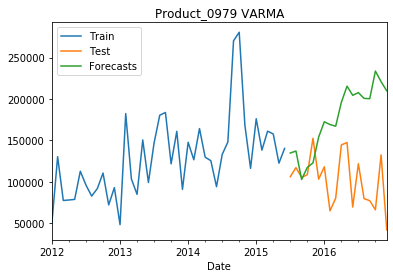

MAPE:  100.52193569362322 MPE:  -98.1037602287465 RMSE:  92045.69724459194


In [ ]:
# Preview

plt.figure()
plt.title("Product_0979 VARMA")
df1_combined_monthly_train["Product_0979"].plot(label="Train")
df1_combined_monthly_test["Product_0979"].plot(label="Test")
VARMA_model_dict["Product_0979"]["forecasts"]["Product_0979"][:-1].plot(label="Forecasts") # The last datapoint is not counted as it's the forecast outside the test dataset
plt.legend()
plt.savefig('C:\\Users\\renal\\Documents\\HEC Supervised Project\\VARMA.jpg')
plt.show()

print("MAPE: ", mean_absolute_percentage_error(df1_combined_monthly_test["Product_0979"], VARMA_model_dict["Product_0979"]["forecasts"]["Product_0979"][:-1]),
      "MPE: ", mean_percentage_error(df1_combined_monthly_test["Product_0979"], VARMA_model_dict["Product_0979"]["forecasts"]["Product_0979"][:-1]),
      "RMSE: ", root_mean_square_error(df1_combined_monthly_test["Product_0979"], VARMA_model_dict["Product_0979"]["forecasts"]["Product_0979"][:-1]))

### Pickle

In [ ]:
import pickle

# Function of the code below is to save the dictionary/dataframes above
variables_list = [products_dataframe,
                  product_ARIMA_dict, forecast_errors_ARIMA,
                  product_SARIMA_dict, forecast_errors_SARIMA,
                  causality_test_df1, predictors_dict,
                  VAR_model_dict, forecast_errors_VAR,
                  VMA_model_dict, forecast_errors_VMA,
                  VARMA_model_dict, forecast_errors_VARMA]

with open('C:\\Users\\renal\\Documents\\HEC Supervised Project\\workflow1.pkl', 'wb') as f:
    pickle.dump(variables_list, f)

## Workflow 2

### Isolation Forest

In [ ]:
import pickle

with open('C:\\Users\\renal\\Documents\\HEC Supervised Project\\workflow2_isoforest.pkl', 'rb') as f:
  [products_dataframe_isoforest, monthly_data_isoforest,
  product_isoforest_ARIMA_dict, forecast_errors_isoforest_ARIMA,
  product_isoforest_SARIMA_dict, forecast_errors_isoforest_SARIMA,
  product_isoforest_VAR_dict, forecast_errors_isoforest_VAR,
  product_isoforest_VMA_dict, forecast_errors_isoforest_VMA,
  product_isoforest_VARMA_dict, forecast_errors_isoforest_VARMA] = pickle.load(f)

#### Data Transformation

In [ ]:
from sklearn.ensemble import IsolationForest

products_dataframe_isoforest = {}
monthly_data_isoforest = {}

start_time = time.time()
countdown = len(significant_product_list)
for product in significant_product_list:

  train_date_indexes = df1_combined_monthly_train.index
  test_date_indexes = df1_combined_monthly_test.index

  df1 = products_dataframe[product][["Date", "Order_Demand"]]
  df1 = df1.loc[df1["Date"] <= test_date_indexes[-1]]
  df1_train = df1.loc[df1["Date"] <= train_date_indexes[-1]]

  #IsolationForest does not accept DateTime as input. Therefore, we have to change the dates into scalar values
  scalar_dates = [0] #The first order is the beginning point
  for i in range(1,len(df1_train)):
    delta = df1_train.loc[i,"Date"] - df1_train.loc[0,"Date"]
    scalar_dates.append(delta/np.timedelta64(1,'D'))

  df1_train["scalar_date"] = scalar_dates

  model = IsolationForest(contamination=0.01)
  anomalies_bool_array = model.fit_predict(df1_train[["scalar_date", "Order_Demand"]])

  # Anomalies for the train data has been identified.
  # Now, we recursively identify anomalies of the test data, going forward one month at a time

  counter = len(df1_train)
  for datetime in test_date_indexes:
    
    df1_train = df1.loc[df1["Date"] <= datetime] # This returns the data up until that month

    scalar_dates = [0] #The first order is the beginning point    
    for i in range(1, len(df1_train)):
      delta = df1_train.loc[i,"Date"] - df1_train.loc[0,"Date"]
      scalar_dates.append(delta/np.timedelta64(1,'D'))

    df1_train["scalar_date"] = scalar_dates

    model = IsolationForest(contamination=0.01)
    anomalies_bool_array = np.append(anomalies_bool_array, 
                                     model.fit_predict(df1_train[["scalar_date", "Order_Demand"]])[counter:]) # Obtain only the last month
    counter = len(df1_train)

  df1["anomalies"] = anomalies_bool_array
  df1["corrected_values"] = df1.Order_Demand

  for index in df1[2:].index:
    if df1.loc[index, "anomalies"] == -1: # If the order demand is identified to be an anomaly
      df1.loc[index, "corrected_values"] = df1[(index-3):index]["Order_Demand"].mean() # Corrected values is the average of the last 3 orders

  products_dataframe_isoforest[product] = df1

  # Next, we group them again monthly based on the timeframe intersection already found
  df1 = df1.loc[df1["Date"] >= min_date]
  df1 = df1.loc[df1["Date"] <= max_date]
  df1 = df1[["Date", "corrected_values"]]
  df1 = df1.groupby([pd.Grouper(key="Date", freq="M")]).sum().reset_index()
  df1 = df1.set_index("Date")
  monthly_data_isoforest[product] = df1

  time_elapsed = time.time() - start_time
  countdown -= 1
  print("Time Elapsed", time_elapsed, countdown, "Products left to evaluate")

Time Elapsed 18.21527671813965 240 Products left to evaluate
Time Elapsed 28.145355939865112 239 Products left to evaluate
Time Elapsed 46.5684928894043 238 Products left to evaluate
Time Elapsed 68.7447018623352 237 Products left to evaluate
Time Elapsed 84.43964838981628 236 Products left to evaluate
Time Elapsed 98.76807308197021 235 Products left to evaluate
Time Elapsed 108.43035054206848 234 Products left to evaluate
Time Elapsed 130.15885472297668 233 Products left to evaluate
Time Elapsed 142.50274872779846 232 Products left to evaluate
Time Elapsed 188.51421093940735 231 Products left to evaluate
Time Elapsed 198.06268978118896 230 Products left to evaluate
Time Elapsed 209.06235718727112 229 Products left to evaluate
Time Elapsed 217.64740633964539 228 Products left to evaluate
Time Elapsed 225.6747763156891 227 Products left to evaluate
Time Elapsed 235.80693221092224 226 Products left to evaluate
Time Elapsed 247.9739019870758 225 Products left to evaluate
Time Elapsed 257.

In [ ]:
# Combine them into one dataframe
df1_combined_monthly_isoforest = pd.DataFrame(index=df1_combined_monthly.index)

for product in significant_product_list:
  df1_combined_monthly_isoforest[product] = monthly_data_isoforest[product].corrected_values.tolist()

In [ ]:
train_percentage = 0.7 # Percentage of train dataset

# Train dataset
df1_combined_monthly_isoforest_train = df1_combined_monthly_isoforest[:int(train_percentage*len(df1_combined_monthly_isoforest))]

# Test dataset
df1_combined_monthly_isoforest_test = df1_combined_monthly_isoforest[int(train_percentage*len(df1_combined_monthly_isoforest)):]

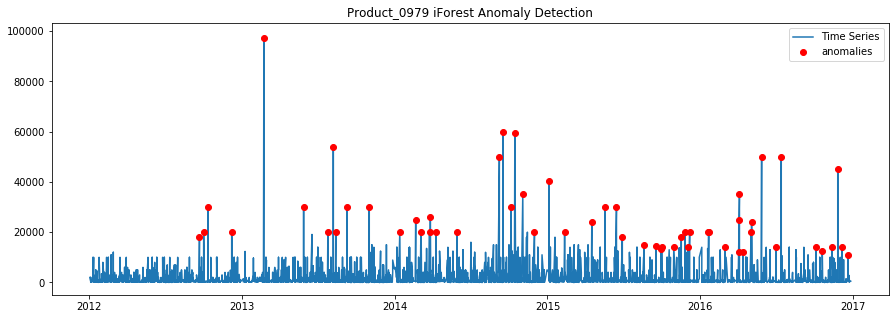

In [ ]:
# Preview of Anomaly Detection
plt.figure(figsize=(15,5))
plt.title("Product_0979 iForest Anomaly Detection")
plt.plot(products_dataframe["Product_0979"].Date, 
         products_dataframe["Product_0979"].Order_Demand,
         zorder=1,
         label="Time Series")

df1_anomalies = products_dataframe_isoforest["Product_0979"]
df1_anomalies = df1_anomalies.loc[df1_anomalies["anomalies"] == -1]

plt.scatter(df1_anomalies.Date, 
            df1_anomalies.Order_Demand,
            color="red", 
            zorder=2,
            label="anomalies")

plt.legend()
plt.show()

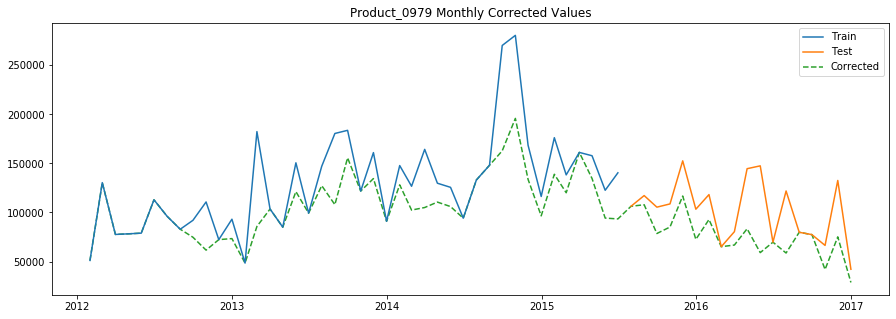

In [ ]:
# Preview of corrected values

plt.figure(figsize=(15,5))
plt.title("Product_0979 Monthly Corrected Values")
df1_train = df1_combined_monthly_train[["Product_0979"]]
df1_test = df1_combined_monthly_test[["Product_0979"]]
df1_corrected = monthly_data_isoforest["Product_0979"]

plt.plot(df1_train, label="Train", zorder = 1)
plt.plot(df1_test, label="Test", zorder=1)
plt.plot(df1_corrected, label="Corrected", zorder = -1, linestyle= "--")

plt.legend()
plt.show()

#### Simple Average

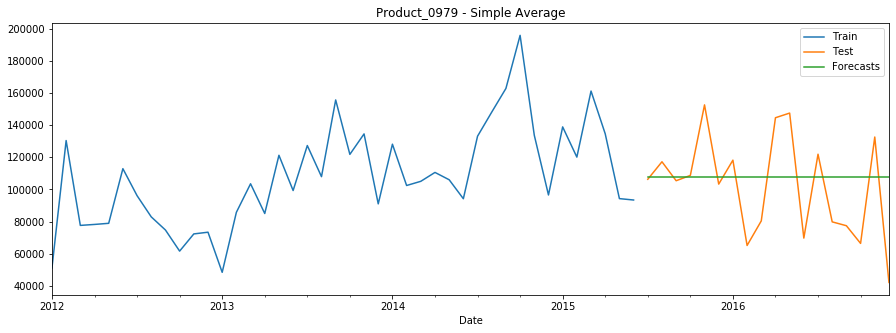

MAPE:  32.515839548369506 MPE:  -18.158623994967762 RMSE:  31406.80970175423


In [ ]:
# Preview
df1_train = df1_combined_monthly_isoforest_train[["Product_0979"]]
df1_test = df1_combined_monthly_test[["Product_0979"]]
df1_forecasts = pd.DataFrame(index=df1_test.index, columns=["Product_0979"])
df1_forecasts["Product_0979"] = [df1_train.Product_0979.mean() for i in range(len(df1_test))]

plt.figure(figsize=(15,5))
plt.title("Product_0979 - Simple Average")
df1_train.Product_0979.plot(label="Train")
df1_test.Product_0979.plot(label="Test")
df1_forecasts.Product_0979.plot(label="Forecasts")
plt.legend()
plt.show()

print("MAPE: ", mean_absolute_percentage_error(df1_test, df1_train.mean()),
      "MPE: ", mean_percentage_error(df1_test, df1_train.mean()),
      "RMSE: ", root_mean_square_error(df1_test, df1_train.mean())[0])

In [ ]:
# Create Dataframe for each product with Product_Name as index
forecast_errors_isoforest_simple_avg = pd.DataFrame(columns=["Product", "MAPE", "MPE", "RMSE"])
forecast_errors_isoforest_simple_avg["Product"] = significant_product_list

MAPE_list = []
MPE_list = []
RMSE_list = []
for product in significant_product_list:
  df1_train = df1_combined_monthly_isoforest_train[[product]]
  df1_test = df1_combined_monthly_test[[product]]

  # Insert the forecast errors to the dataframe
  MAPE_list.append(mean_absolute_percentage_error(df1_test, df1_train.mean()))
  MPE_list.append(mean_percentage_error(df1_test, df1_train.mean()))
  RMSE_list.append(root_mean_square_error(df1_test, df1_train.mean())[0])

forecast_errors_isoforest_simple_avg["MAPE"] = MAPE_list
forecast_errors_isoforest_simple_avg["MPE"] = MPE_list
forecast_errors_isoforest_simple_avg["RMSE"] = RMSE_list
forecast_errors_isoforest_simple_avg.head()

,Product,MAPE,MPE,RMSE
0,Product_0979,32.515840,-18.158624,31406.809702
1,Product_1938,42.042394,19.548354,45.125625
2,Product_1451,21.642356,-3.183881,336825.895179
3,Product_1274,14.257550,-8.589363,244784.586837
4,Product_1512,26.593981,6.617359,61926.122920


#### Moving Average (n=3)

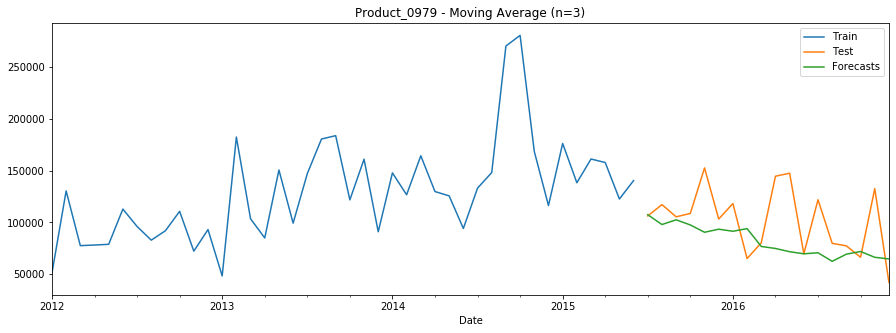

MAPE:  24.334305249111882 MPE:  12.352872383810496 RMSE:  36916.89349174592


In [ ]:
# Preview
smoothed_values = [0,0,0]
df1 = df1_combined_monthly_isoforest[["Product_0979"]]
for i in range(3, len(df1)):
  smoothed_values.append((df1.iloc[i-3, 0]+
                          df1.iloc[i-2, 0]+
                          df1.iloc[i-1, 0])/3)
df1["forecasts"] = smoothed_values
df1_forecasts = df1[int(train_percentage * len(df1)):][["forecasts"]]

plt.figure(figsize=(15,5))
plt.title("Product_0979 - Moving Average (n=3)")
df1_combined_monthly_train["Product_0979"].plot(label="Train")
df1_combined_monthly_test["Product_0979"].plot(label="Test")
df1_forecasts["forecasts"].plot(label="Forecasts")
plt.legend()
plt.show()

print("MAPE: ", mean_absolute_percentage_error(df1_combined_monthly_test[["Product_0979"]], df1_forecasts),
      "MPE: ", mean_percentage_error(df1_combined_monthly_test[["Product_0979"]], df1_forecasts),
      "RMSE: ", root_mean_square_error(df1_combined_monthly_test[["Product_0979"]], df1_forecasts)[0])

In [ ]:
# Create Dataframe for each product with Product_Name as index
forecast_errors_isoforest_moving_average = pd.DataFrame(columns=["Product", "MAPE", "MPE", "RMSE"])
MAPE_list = []
MPE_list = []
RMSE_list = []

n = 3
train_percentage = 0.7
for product in significant_product_list:
  smoothed_values = [0,0,0]
  df1 = df1_combined_monthly_isoforest[[product]]
  for i in range(3, len(df1)):
    smoothed_values.append((df1.iloc[i-3, 0]+
                            df1.iloc[i-2, 0]+
                            df1.iloc[i-1, 0])/3)
  df1["forecasts"] = smoothed_values
  train_len = int(train_percentage * len(df1))
  df2 = df1[train_len:]
  MAPE_list.append(mean_absolute_percentage_error(df2[[product]], df2[["forecasts"]]))
  MPE_list.append(mean_percentage_error(df2[[product]], df2[["forecasts"]]))
  RMSE_list.append(root_mean_square_error(df2[[product]], df2[["forecasts"]])[0])

forecast_errors_isoforest_moving_average["Product"] = significant_product_list
forecast_errors_isoforest_moving_average["RMSE"] = RMSE_list
forecast_errors_isoforest_moving_average["MAPE"] = MAPE_list
forecast_errors_isoforest_moving_average["MPE"] = MPE_list

forecast_errors_isoforest_moving_average.head()

,Product,MAPE,MPE,RMSE
0,Product_0979,25.626746,-15.971395,18136.673340
1,Product_1938,39.786802,-17.607210,26.573602
2,Product_1451,24.238584,-14.400268,249632.243759
3,Product_1274,22.077024,-7.309938,275314.616439
4,Product_1512,19.175783,-6.331385,27097.274150


#### Simple Exponential Smoothing

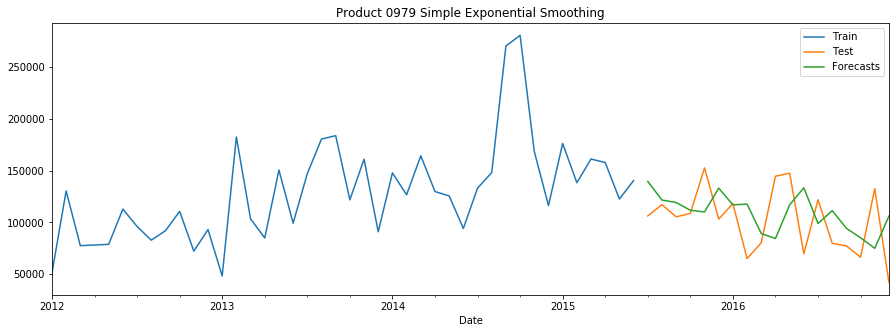

MAPE:  36.562573691768364 MPE:  -19.523592254424983 RMSE:  37300.46021266886


In [ ]:
# Preview
df1_train = df1_combined_monthly_isoforest_train[["Product_0979"]]
df1 = df1_combined_monthly[["Product_0979"]]
mod = SimpleExpSmoothing(df1_train)
res = mod.fit(optimized=True)

mod_df1 = SimpleExpSmoothing(df1)
res_df1 = mod_df1.fit(optimized=False, smoothing_level=res.params["smoothing_level"], initial_level=res.params["initial_level"])

forecasts = res_df1.fittedvalues[train_len:] # Fitted values at time t equals to forecast of t-1

plt.figure(figsize=(15,5))
plt.title("Product 0979 Simple Exponential Smoothing")
df1_combined_monthly_train["Product_0979"].plot(label="Train")
df1_combined_monthly_test["Product_0979"].plot(label="Test")
forecasts.plot(label="Forecasts")
plt.legend()
plt.show()

print("MAPE: ", mean_absolute_percentage_error(df1_combined_monthly_test["Product_0979"], forecasts),
      "MPE: ", mean_percentage_error(df1_combined_monthly_test["Product_0979"], forecasts),
      "RMSE: ", root_mean_square_error(df1_combined_monthly_test["Product_0979"], forecasts))

In [ ]:
forecast_errors_isoforest_expsmoothing = pd.DataFrame(columns=["Product", "MAPE", "MPE", "RMSE"])
MAPE = []
MPE = []
RMSE = []

for product in significant_product_list:

  df1_train = df1_combined_monthly_isoforest_train[[product]]
  df1 = df1_combined_monthly_isoforest[[product]]
  mod = SimpleExpSmoothing(df1_train)
  res = mod.fit(optimized=True)
  
  mod_df1 = SimpleExpSmoothing(df1)
  res_df1 = mod_df1.fit(optimized=False, smoothing_level=res.params["smoothing_level"], initial_level=res.params["initial_level"])

  forecasts = res_df1.fittedvalues[train_len:]
  MAPE.append(mean_absolute_percentage_error(df1_combined_monthly_test[product], forecasts))
  MPE.append(mean_percentage_error(df1_combined_monthly_test[product], forecasts))
  RMSE.append(root_mean_square_error(df1_combined_monthly_test[product], forecasts))

forecast_errors_isoforest_expsmoothing["Product"] = significant_product_list
forecast_errors_isoforest_expsmoothing["MAPE"] = MAPE
forecast_errors_isoforest_expsmoothing["MPE"] = MPE
forecast_errors_isoforest_expsmoothing["RMSE"] = RMSE

forecast_errors_isoforest_expsmoothing.head()

,Product,MAPE,MPE,RMSE
0,Product_0979,24.604287,12.234225,37999.779752
1,Product_1938,36.028953,-3.887528,37.137613
2,Product_1451,29.345686,16.913241,486210.812313
3,Product_1274,26.591734,16.577438,406036.503515
4,Product_1512,38.126541,30.497661,89714.980034


#### Holt's

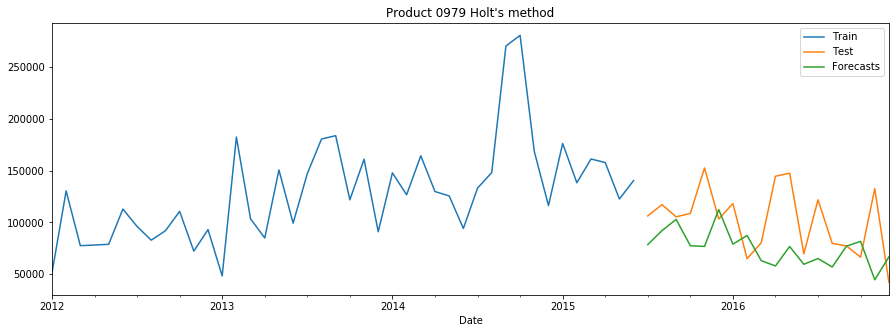

MAPE:  31.76779697602758 MPE:  17.891988303876534 RMSE:  44372.24221238041


In [ ]:
# Preview

df1_train = df1_combined_monthly_isoforest_train[["Product_0979"]]
df1 = df1_combined_monthly_isoforest[["Product_0979"]]
mod = Holt(df1_train)
res = mod.fit(optimized=True)

mod_df1 = Holt(df1)
res_df1 = mod_df1.fit(optimized=False, 
                      smoothing_level=res.params["smoothing_level"],
                      smoothing_trend=res.params["smoothing_trend"],
                      initial_level=res.params["initial_level"],
                      initial_trend=res.params["initial_trend"])

forecasts = res_df1.fittedvalues[train_len:]

plt.figure(figsize=(15,5))
plt.title("Product 0979 Holt's method")
df1_combined_monthly_train["Product_0979"].plot(label="Train")
df1_combined_monthly_test["Product_0979"].plot(label="Test")
forecasts.plot(label="Forecasts")
plt.legend()
plt.show()

print("MAPE: ", mean_absolute_percentage_error(df1_combined_monthly_test["Product_0979"], forecasts),
      "MPE: ", mean_percentage_error(df1_combined_monthly_test["Product_0979"], forecasts),
      "RMSE: ", root_mean_square_error(df1_combined_monthly_test["Product_0979"], forecasts))

In [ ]:
forecast_errors_isoforest_Holt = pd.DataFrame(columns=["Product", "MAPE", "MPE", "RMSE"])
MAPE = []
MPE = []
RMSE = []
for product in significant_product_list:

  df1_train = df1_combined_monthly_isoforest_train[[product]]
  df1 = df1_combined_monthly_isoforest[[product]]
  mod = Holt(df1_train)
  res = mod.fit(optimized=True)
  
  mod_df1 = Holt(df1)
  res_df1 = mod_df1.fit(optimized=False, 
                        smoothing_level=res.params["smoothing_level"],
                        smoothing_trend=res.params["smoothing_trend"],
                        initial_level=res.params["initial_level"],
                        initial_trend=res.params["initial_trend"])

  forecasts = res_df1.fittedvalues[train_len:]
  MAPE.append(mean_absolute_percentage_error(df1_combined_monthly_test[product], forecasts))
  MPE.append(mean_percentage_error(df1_combined_monthly_test[product], forecasts))
  RMSE.append(root_mean_square_error(df1_combined_monthly_test[product], forecasts))

forecast_errors_isoforest_Holt["Product"] = significant_product_list
forecast_errors_isoforest_Holt["MAPE"] = MAPE
forecast_errors_isoforest_Holt["MPE"] = MPE
forecast_errors_isoforest_Holt["RMSE"] = RMSE

forecast_errors_isoforest_Holt.head()

,Product,MAPE,MPE,RMSE
0,Product_0979,31.767797,17.891988,44372.242212
1,Product_1938,44.284190,-19.220510,36.172895
2,Product_1451,33.641527,20.971949,561857.507961
3,Product_1274,30.645761,16.549561,466381.882189
4,Product_1512,44.547511,35.453594,102897.518297


#### Holt-Winter's (S=12)

In [ ]:
forecast_errors_isoforest_HoltWinters = pd.DataFrame(columns=["Product", "MAPE", "MPE", "RMSE"])
MAPE = []
MPE = []
RMSE = []
for product in significant_product_list:

  df1_train = df1_combined_monthly_isoforest_train[[product]]
  df1 = df1_combined_monthly_isoforest[[product]]
  mod = ExponentialSmoothing(df1_train, trend="add", seasonal_periods=12, seasonal="add")
  res = mod.fit(optimized=True)
  
  mod_df1 = ExponentialSmoothing(df1, trend="add", seasonal_periods=12, seasonal="add",
                                 initialization_method="known",
                                 initial_level=res.params["initial_level"],
                                 initial_trend=res.params["initial_trend"],
                                 initial_seasonal=res.params["initial_seasons"])
  res_df1 = mod_df1.fit(smoothing_level=res.params["smoothing_level"],
                        smoothing_trend=res.params["smoothing_trend"],
                        smoothing_seasonal=res.params["smoothing_seasonal"])

  forecasts = res_df1.fittedvalues[train_len:]
  MAPE.append(mean_absolute_percentage_error(df1_combined_monthly_test[product], forecasts))
  MPE.append(mean_percentage_error(df1_combined_monthly_test[product], forecasts))
  RMSE.append(sm.tools.eval_measures.rmse(df1_combined_monthly_test[product], forecasts))

forecast_errors_isoforest_HoltWinters["Product"] = significant_product_list
forecast_errors_isoforest_HoltWinters["MAPE"] = MAPE
forecast_errors_isoforest_HoltWinters["MPE"] = MPE
forecast_errors_isoforest_HoltWinters["RMSE"] = RMSE

forecast_errors_isoforest_HoltWinters.head()

,Product,MAPE,MPE,RMSE
0,Product_0979,33.372904,-20.973686,37255.019380
1,Product_1938,39.148725,-1.667448,35.610757
2,Product_1451,22.862461,7.711424,375028.170579
3,Product_1274,24.186556,15.596561,394439.579607
4,Product_1512,33.839414,27.338832,78555.340935


#### ARIMA

In [ ]:
# This the ARIMA function. It returns the dictionary of each product to its:
  # Best model Order based on minimum AIC
  # The train AIC
  # Fitted values of the train data
  # The generated Forecasts
  # The prediction intervals

from statsmodels.tsa.arima.model import ARIMA

def arima_func(product, dataframe, return_dict):
    
    # Assign the endogenous model
    endog = dataframe

    # Setup forecasts
    nforecasts = 1
    forecasts = {}

    # Get the number of initial training observations
    train_percentage = 0.7
    nobs = len(endog)
    n_init_training = int(nobs * train_percentage)

    # Dictionary of model order to the fitted model and its corresponding statistics
    ARIMA_model_dict = {}
    aic = 99999999
    
    # Create model for initial training sample, fit parameters
    training_endog = endog.iloc[:n_init_training]
    for p in range(0,4):
      for d in range(0,4):
        for q in range(0,4):
          try:             
            mod = ARIMA(training_endog, order=(p,d,q))
            res = mod.fit()

            if res.aic < aic:
                aic = res.aic

                ARIMA_model_dict["Model_Order"] = (p,d,q)
                ARIMA_model_dict["train_AIC"] = aic
                ARIMA_model_dict["train_fittedvalues"] = res.fittedvalues

                # Initial forecast and prediction interval DataFrame
                df_forecast = res.get_forecast(steps=1).predicted_mean
                df_prediction_interval = res.get_forecast(steps=1).conf_int(alpha=0.05)

                # Iterate through the rest of the sample
                for t in range(n_init_training, nobs):
                    # Update the results by appending the next observation
                    updated_endog = endog.iloc[t:t+1]
                    res = res.append(updated_endog, refit=False)

                    # Save the new set of forecasts and prediction intervals
                    forecast_object = res.get_forecast(1)
                    df_forecast = df_forecast.append(forecast_object.predicted_mean)
                    df_prediction_interval = df_prediction_interval.append(forecast_object.conf_int(alpha=0.05))

                ARIMA_model_dict["forecasts"] = df_forecast
                ARIMA_model_dict["prediction_intervals"] = df_prediction_interval
          except:
            print(product, "Model Order", (p,d,q), "could not be fitted")

    return_dict[product] = ARIMA_model_dict

    return

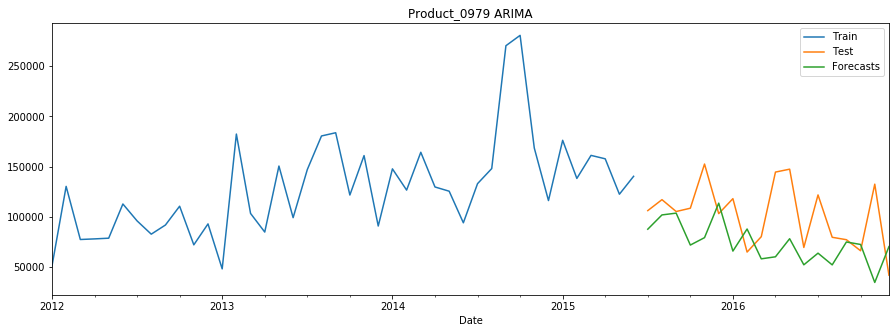

MAPE:  33.0854549660786 MPE:  19.498882003097492 RMSE:  45805.02178122307


In [ ]:
# Preview
product_isoforest_ARIMA_dict = {}
arima_func("Product_0979", df1_combined_monthly_isoforest[["Product_0979"]], product_isoforest_ARIMA_dict)

plt.figure(figsize=(15,5))
plt.title("Product_0979 ARIMA")
df1_combined_monthly_train["Product_0979"].plot(label="Train")
df1_combined_monthly_test["Product_0979"].plot(label="Test")
product_isoforest_ARIMA_dict["Product_0979"]["forecasts"][:-1].plot(label="Forecasts") # The last datapoint is not counted as it's the forecast outside the test dataset
plt.legend()
plt.show()

print("MAPE: ", mean_absolute_percentage_error(df1_combined_monthly_test["Product_0979"], product_isoforest_ARIMA_dict["Product_0979"]["forecasts"][:-1]),
      "MPE: ", mean_percentage_error(df1_combined_monthly_test["Product_0979"], product_isoforest_ARIMA_dict["Product_0979"]["forecasts"][:-1]),
      "RMSE: ", root_mean_square_error(df1_combined_monthly_test["Product_0979"], product_isoforest_ARIMA_dict["Product_0979"]["forecasts"][:-1]))

In [ ]:
for product in significant_product_list:
  arima_func(product, df1_combined_monthly_isoforest[[product]], product_isoforest_ARIMA_dict)

# Sound Ding when done
import winsound
duration = 10000  # milliseconds
freq = 777  # Hz
winsound.Beep(freq, duration)

Product_1450 Model Order (3, 3, 2) could not be fitted
Product_0361 Model Order (3, 0, 2) could not be fitted


In [ ]:
forecast_errors_isoforest_ARIMA = pd.DataFrame(columns=["Product", "MAPE", "MPE", "RMSE"])
mape_list = []
mpe_list = []
rmse_list = []

for product in product_isoforest_ARIMA_dict:
  mape = mean_absolute_percentage_error(df1_combined_monthly_test[product],
                                        product_isoforest_ARIMA_dict[product]["forecasts"][:-1])
  mpe = mean_percentage_error(df1_combined_monthly_test[product],
                              product_isoforest_ARIMA_dict[product]["forecasts"][:-1])
  rmse = root_mean_square_error(df1_combined_monthly_test[product],
                                product_isoforest_ARIMA_dict[product]["forecasts"][:-1])
  
  mape_list.append(mape)
  mpe_list.append(mpe)
  rmse_list.append(rmse)

forecast_errors_isoforest_ARIMA["Product"] = significant_product_list
forecast_errors_isoforest_ARIMA["MAPE"] = mape_list
forecast_errors_isoforest_ARIMA["MPE"] = mpe_list
forecast_errors_isoforest_ARIMA["RMSE"] = rmse_list

forecast_errors_isoforest_ARIMA.head()

,Product,MAPE,MPE,RMSE
0,Product_0979,33.085455,19.498882,45805.021781
1,Product_1938,37.487475,-9.369896,35.839710
2,Product_1451,33.944313,21.428664,568335.530393
3,Product_1274,31.551999,17.072834,474973.075863
4,Product_1512,44.020742,36.326549,102658.576360


#### SARIMA

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

def sarima_func(product, dataframe, return_dict):
    
    # Assign the endogenous model
    endog = dataframe

    # Setup forecasts
    nforecasts = 1
    forecasts = {}

    # Get the number of initial training observations
    train_percentage = 0.7
    nobs = len(endog)
    n_init_training = int(nobs * train_percentage)

    # Dictionary of model order to the fitted model and its corresponding statistics
    SARIMA_model_dict = {}
    aic = 99999999
    
    # Create model for initial training sample, fit parameters
    training_endog = endog.iloc[:n_init_training]
    for p in range(0,2):
      for d in range(0,2):
        for q in range(0,2):
          for P in range(0,2):
            for D in range(0,2):
              for Q in range(0,2):
                try:             
                  mod = SARIMAX(training_endog, order=(p,d,q), seasonal_order=(P,D,Q,12))
                  res = mod.fit()

                  if res.aic < aic:
                      aic = res.aic

                      SARIMA_model_dict["Model_Order"] = ((p,d,q),(P,D,Q))
                      SARIMA_model_dict["train_AIC"] = aic
                      SARIMA_model_dict["train_fittedvalues"] = res.fittedvalues

                      # Initial forecast and prediction interval DataFrame
                      df_forecast = res.get_forecast(steps=1).predicted_mean
                      df_prediction_interval = res.get_forecast(steps=1).conf_int(alpha=0.05)

                      # Iterate through the rest of the sample
                      for t in range(n_init_training, nobs):
                          # Update the results by appending the next observation
                          updated_endog = endog.iloc[t:t+1]
                          res = res.append(updated_endog, refit=False)

                          # Save the new set of forecasts and prediction intervals
                          forecast_object = res.get_forecast(1)
                          df_forecast = df_forecast.append(forecast_object.predicted_mean)
                          df_prediction_interval = df_prediction_interval.append(forecast_object.conf_int(alpha=0.05))

                      SARIMA_model_dict["forecasts"] = df_forecast
                      SARIMA_model_dict["prediction_intervals"] = df_prediction_interval

                except:
                  None

    return_dict[product] = SARIMA_model_dict

    return

In [ ]:
product_isoforest_SARIMA_dict = {}
for product in significant_product_list:
  sarima_func(product, df1_combined_monthly_isoforest[[product]], product_isoforest_SARIMA_dict)

# Sound Ding when done
import winsound
duration = 10000  # milliseconds
freq = 777  # Hz
winsound.Beep(freq, duration)

In [ ]:
forecast_errors_isoforest_SARIMA = pd.DataFrame(columns=["Product", "MAPE", "MPE", "RMSE"])
mape_list = []
mpe_list = []
rmse_list = []

for product in product_isoforest_SARIMA_dict:
  mape = mean_absolute_percentage_error(df1_combined_monthly_test[product],
                                        product_isoforest_SARIMA_dict[product]["forecasts"][:-1])
  mpe = mean_percentage_error(df1_combined_monthly_test[product],
                              product_isoforest_SARIMA_dict[product]["forecasts"][:-1])
  rmse = root_mean_square_error(df1_combined_monthly_test[product],
                                product_isoforest_SARIMA_dict[product]["forecasts"][:-1])
  
  mape_list.append(mape)
  mpe_list.append(mpe)
  rmse_list.append(rmse)

forecast_errors_isoforest_SARIMA["Product"] = significant_product_list
forecast_errors_isoforest_SARIMA["MAPE"] = mape_list
forecast_errors_isoforest_SARIMA["MPE"] = mpe_list
forecast_errors_isoforest_SARIMA["RMSE"] = rmse_list

forecast_errors_isoforest_SARIMA.head()

,Product,MAPE,MPE,RMSE
0,Product_0979,28.419107,16.115353,44060.929805
1,Product_1938,49.622106,-19.790290,39.676765
2,Product_1451,34.942218,18.991211,651250.528677
3,Product_1274,26.963333,14.171467,417931.909873
4,Product_1512,40.854999,34.938402,90678.900116


In [ ]:
forecast_errors_isoforest_SARIMA.MAPE.mean()

126.42285397935886

#### VAR

In [ ]:
import time
import multiprocessing
from multiprocessing import Process, Queue, Manager
from statsmodels.tsa.statespace.varmax import VARMAX

import varma_func

batch_size = len(significant_product_list)/4
batched_lists = []
for i in range(0,4):
  batched_lists.append(significant_product_list[int(i*batch_size):int((i+1)*batch_size)])

product_isoforest_VAR_dict = {}

for batched_list in batched_lists:
  dataframes_list = []
  for product in batched_list:  
    dataframes_list.append((product, df1_combined_monthly_isoforest[[product] + predictors_dict[product]].astype("float")))

  if __name__ == '__main__':
      manager = multiprocessing.Manager()
      return_dict = manager.dict()

      starttime = time.time()
      processes = []

      for product, dataframe in dataframes_list:
          p = Process(target=varma_func.var_func, args=(product, dataframe, return_dict))
          processes.append(p)
          p.start()
          
      for process in processes:
          process.join()
      
      print('Batch processed. Time elapsed: {} seconds'.format(time.time() - starttime))

  for product in return_dict:
    product_isoforest_VAR_dict[product] = return_dict[product]

# Sound Checkpoint
import winsound
duration = 10000  # milliseconds
freq = 777  # Hz
winsound.Beep(freq, duration)

Batch processed. Time elapsed: 2738.0058348178864 seconds
Batch processed. Time elapsed: 2786.0835933685303 seconds
Batch processed. Time elapsed: 2670.2191359996796 seconds
Batch processed. Time elapsed: 2774.536175251007 seconds


In [ ]:
forecast_errors_isoforest_VAR = pd.DataFrame(columns=["Product", "MAPE", "MPE", "RMSE"])
mape_list = []
mpe_list = []
rmse_list = []

for product in product_isoforest_VAR_dict:
  mape = mean_absolute_percentage_error(df1_combined_monthly_test[product],
                                        product_isoforest_VAR_dict[product]["forecasts"][product][:-1])
  mpe = mean_percentage_error(df1_combined_monthly_test[product],
                              product_isoforest_VAR_dict[product]["forecasts"][product][:-1])
  rmse = root_mean_square_error(df1_combined_monthly_test[product],
                                product_isoforest_VAR_dict[product]["forecasts"][product][:-1])
  
  mape_list.append(mape)
  mpe_list.append(mpe)
  rmse_list.append(rmse)

forecast_errors_isoforest_VAR["Product"] = significant_product_list
forecast_errors_isoforest_VAR["MAPE"] = mape_list
forecast_errors_isoforest_VAR["MPE"] = mpe_list
forecast_errors_isoforest_VAR["RMSE"] = rmse_list

forecast_errors_isoforest_VAR.head()

,Product,MAPE,MPE,RMSE
0,Product_0979,19.307208,12.769044,1.501908e+06
1,Product_1938,22.082148,1.364965,7.742977e+04
2,Product_1451,20.715587,5.547439,5.558526e+04
3,Product_1274,26.617819,5.201602,6.700901e+04
4,Product_1512,26.278839,9.555272,1.909624e+04


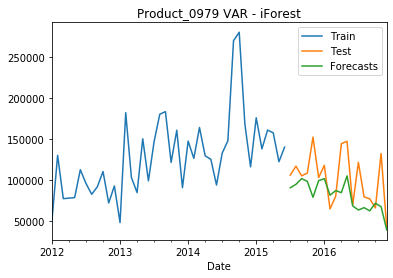

MAPE:  20.210596237557244 MPE:  15.444548128767236 RMSE:  33474.250774327054


In [ ]:
# Preview

plt.figure()
plt.title("Product_0979 VAR - iForest")
df1_combined_monthly_train["Product_0979"].plot(label="Train")
df1_combined_monthly_test["Product_0979"].plot(label="Test")
product_isoforest_VAR_dict["Product_0979"]["forecasts"]["Product_0979"][:-1].plot(label="Forecasts") # The last datapoint is not counted as it's the forecast outside the test dataset
plt.legend()
plt.savefig('C:\\Users\\renal\\Documents\\HEC Supervised Project\\VAR_isoforest.jpg')
plt.show()

print("MAPE: ", mean_absolute_percentage_error(df1_combined_monthly_test["Product_0979"], product_isoforest_VAR_dict["Product_0979"]["forecasts"]["Product_0979"][:-1]),
      "MPE: ", mean_percentage_error(df1_combined_monthly_test["Product_0979"], product_isoforest_VAR_dict["Product_0979"]["forecasts"]["Product_0979"][:-1]),
      "RMSE: ", root_mean_square_error(df1_combined_monthly_test["Product_0979"], product_isoforest_VAR_dict["Product_0979"]["forecasts"]["Product_0979"][:-1]))

#### VMA

In [ ]:
import time
import multiprocessing
from multiprocessing import Process, Queue, Manager
from statsmodels.tsa.statespace.varmax import VARMAX

import varma_func

batch_size = len(significant_product_list)/4
batched_lists = []
for i in range(0,4):
  batched_lists.append(significant_product_list[int(i*batch_size):int((i+1)*batch_size)])

product_isoforest_VMA_dict = {}

for batched_list in batched_lists:
  dataframes_list = []
  for product in batched_list:  
    dataframes_list.append((product, df1_combined_monthly_isoforest[[product] + predictors_dict[product]].astype("float")))

  if __name__ == '__main__':
      manager = multiprocessing.Manager()
      return_dict = manager.dict()

      starttime = time.time()
      processes = []

      for product, dataframe in dataframes_list:
          p = Process(target=varma_func.vma_func, args=(product, dataframe, return_dict))
          processes.append(p)
          p.start()
          
      for process in processes:
          process.join()
      
      print('That took {} seconds'.format(time.time() - starttime))

  for product in return_dict:
    product_isoforest_VMA_dict[product] = return_dict[product]

# Sound Checkpoint
import winsound
duration = 10000  # milliseconds
freq = 777  # Hz
winsound.Beep(freq, duration)

That took 2335.542656183243 seconds
That took 2327.1133346557617 seconds
That took 2208.208067893982 seconds
That took 2416.876040458679 seconds


In [ ]:
forecast_errors_isoforest_VMA = pd.DataFrame(columns=["Product", "MAPE", "MPE", "RMSE"])
mape_list = []
mpe_list = []
rmse_list = []

for product in product_isoforest_VMA_dict:
  mape = mean_absolute_percentage_error(df1_combined_monthly_test[product],
                                        product_isoforest_VMA_dict[product]["forecasts"][product][:-1])
  mpe = mean_percentage_error(df1_combined_monthly_test[product],
                              product_isoforest_VMA_dict[product]["forecasts"][product][:-1])
  rmse = root_mean_square_error(df1_combined_monthly_test[product],
                                product_isoforest_VMA_dict[product]["forecasts"][product][:-1])
  
  mape_list.append(mape)
  mpe_list.append(mpe)
  rmse_list.append(rmse)

forecast_errors_isoforest_VMA["Product"] = significant_product_list
forecast_errors_isoforest_VMA["MAPE"] = mape_list
forecast_errors_isoforest_VMA["MPE"] = mpe_list
forecast_errors_isoforest_VMA["RMSE"] = rmse_list

forecast_errors_isoforest_VMA.head()

,Product,MAPE,MPE,RMSE
0,Product_0979,19.960397,-0.620028,5.077007e+04
1,Product_1938,28.821387,-9.823662,8.820144e+04
2,Product_1451,16.192072,7.822787,1.314924e+06
3,Product_1274,35.397400,-16.785648,7.212187e+05
4,Product_1512,27.089932,9.515320,6.927026e+04


#### VARMA

In [ ]:
import time
import multiprocessing
from multiprocessing import Process, Queue, Manager
from statsmodels.tsa.statespace.varmax import VARMAX

import varma_func

batch_size = len(significant_product_list)/4
batched_lists = []
for i in range(0,4):
  batched_lists.append(significant_product_list[int(i*batch_size):int((i+1)*batch_size)])

product_isoforest_VARMA_dict = {}

for batched_list in batched_lists:
  dataframes_list = []
  for product in batched_list:  
    dataframes_list.append((product, df1_combined_monthly_isoforest[[product] + predictors_dict[product]].astype("float")))

  if __name__ == '__main__':
      manager = multiprocessing.Manager()
      return_dict = manager.dict()

      starttime = time.time()
      processes = []

      for product, dataframe in dataframes_list:
          p = Process(target=varma_func.varma_func, args=(product, dataframe, return_dict))
          processes.append(p)
          p.start()
          
      for process in processes:
          process.join()
      
      print('That took {} seconds'.format(time.time() - starttime))

  for product in return_dict:
    product_isoforest_VARMA_dict[product] = return_dict[product]

# Sound Checkpoint
import winsound
duration = 10000  # milliseconds
freq = 777  # Hz
winsound.Beep(freq, duration)

That took 741.0168642997742 seconds
That took 689.6619117259979 seconds
That took 733.3780288696289 seconds
That took 796.3148059844971 seconds


In [ ]:
forecast_errors_isoforest_VARMA = pd.DataFrame(columns=["Product", "MAPE", "MPE", "RMSE"])
mape_list = []
mpe_list = []
rmse_list = []

for product in product_isoforest_VARMA_dict:
  mape = mean_absolute_percentage_error(df1_combined_monthly_test[product],
                                        product_isoforest_VARMA_dict[product]["forecasts"][product][:-1])
  mpe = mean_percentage_error(df1_combined_monthly_test[product],
                              product_isoforest_VARMA_dict[product]["forecasts"][product][:-1])
  rmse = root_mean_square_error(df1_combined_monthly_test[product],
                                product_isoforest_VARMA_dict[product]["forecasts"][product][:-1])
  
  mape_list.append(mape)
  mpe_list.append(mpe)
  rmse_list.append(rmse)

forecast_errors_isoforest_VARMA["Product"] = significant_product_list
forecast_errors_isoforest_VARMA["MAPE"] = mape_list
forecast_errors_isoforest_VARMA["MPE"] = mpe_list
forecast_errors_isoforest_VARMA["RMSE"] = rmse_list

forecast_errors_isoforest_VARMA.head()

,Product,MAPE,MPE,RMSE
0,Product_0979,87.471796,-85.550041,80898.599826
1,Product_1938,19.586801,-2.685171,315569.695978
2,Product_1451,17.300047,10.224065,276874.996825
3,Product_1274,30.361443,-8.420798,712775.733597
4,Product_1512,50.466099,-45.110548,248981.550114


In [ ]:
forecast_errors_isoforest_VARMA.MAPE.mean()

91.61373232361328

#### Pickle

In [ ]:
import pickle

# Function of the code below is to save the dictionary/dataframes above
variables_list = [products_dataframe_isoforest, monthly_data_isoforest,
                  product_isoforest_ARIMA_dict, forecast_errors_isoforest_ARIMA,
                  product_isoforest_SARIMA_dict, forecast_errors_isoforest_SARIMA,
                  product_isoforest_VAR_dict, forecast_errors_isoforest_VAR,
                  product_isoforest_VMA_dict, forecast_errors_isoforest_VMA,
                  product_isoforest_VARMA_dict, forecast_errors_isoforest_VARMA]

with open('C:\\Users\\renal\\Documents\\HEC Supervised Project\\workflow2_isoforest.pkl', 'wb') as f:
    pickle.dump(variables_list, f)

### Gaussian

In [ ]:
import pickle

with open('C:\\Users\\renal\\Documents\\HEC Supervised Project\\workflow2_gaussian.pkl', 'rb') as f:
  [products_dataframe_gaussian, monthly_data_gaussian,
  product_gaussian_ARIMA_dict, forecast_errors_gaussian_ARIMA,
  product_gaussian_SARIMA_dict, forecast_errors_gaussian_SARIMA,
  product_gaussian_VAR_dict, forecast_errors_gaussian_VAR,
  product_gaussian_VMA_dict, forecast_errors_gaussian_VMA,
  product_gaussian_VARMA_dict, forecast_errors_gaussian_VARMA] = pickle.load(f)

#### Data Transformation

In [ ]:
from sklearn.covariance import EllipticEnvelope

products_dataframe_gaussian = {}
monthly_data_gaussian = {}

for product in significant_product_list:

  train_date_indexes = df1_combined_monthly_train.index
  test_date_indexes = df1_combined_monthly_test.index

  df1 = products_dataframe[product][["Date", "Order_Demand"]]
  df1 = df1.loc[df1["Date"] <= test_date_indexes[-1]]
  df1_train = df1.loc[df1["Date"] <= train_date_indexes[-1]]

  model = EllipticEnvelope(contamination=0.01, assume_centered=True)
  anomalies_bool_array = model.fit_predict(df1_train[["Order_Demand"]])

  # Anomalies for the train data has been identified.
  # Now, we recursively identify anomalies of the test data, going forward one month at a time

  counter = len(df1_train)
  for datetime in test_date_indexes:
    
    df1_train = df1.loc[df1["Date"] <= datetime] # This returns the data up until that month

    model = EllipticEnvelope(contamination=0.01, assume_centered=True)
    anomalies_bool_array = np.append(anomalies_bool_array, 
                                     model.fit_predict(df1_train[["Order_Demand"]])[counter:]) # Obtain only the last month
    counter = len(df1_train)

  df1["anomalies"] = anomalies_bool_array
  df1["corrected_values"] = df1.Order_Demand

  for index in df1[2:].index:
    if df1.loc[index, "anomalies"] == -1: # If the order demand is identified to be an anomaly
      df1.loc[index, "corrected_values"] = df1[(index-3):index]["Order_Demand"].mean() # Corrected values is the average of the last 3 orders

  products_dataframe_gaussian[product] = df1

  # Next, we group them again monthly based on the timeframe intersection already found
  df1 = df1.loc[df1["Date"] >= min_date]
  df1 = df1.loc[df1["Date"] <= max_date]
  df1 = df1[["Date", "corrected_values"]]
  df1 = df1.groupby([pd.Grouper(key="Date", freq="M")]).sum().reset_index()
  df1 = df1.set_index("Date")
  monthly_data_gaussian[product] = df1

In [ ]:
# Combine them into one dataframe
df1_combined_monthly_gaussian = pd.DataFrame(index=df1.index)

for product in significant_product_list:
  df1_combined_monthly_gaussian[product] = monthly_data_gaussian[product].corrected_values.tolist()

In [ ]:
train_percentage = 0.7 # Percentage of train dataset

# Train dataset
df1_combined_monthly_gaussian_train = df1_combined_monthly_gaussian[:int(train_percentage*len(df1_combined_monthly_gaussian))]

# Test dataset
df1_combined_monthly_gaussian_test = df1_combined_monthly_gaussian[int(train_percentage*len(df1_combined_monthly_gaussian)):]

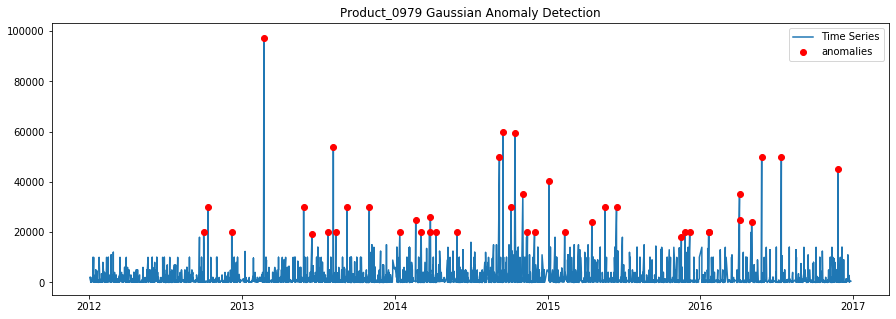

In [ ]:
# Preview of Anomaly Detection
plt.figure(figsize=(15,5))
plt.title("Product_0979 Gaussian Anomaly Detection")
plt.plot(products_dataframe["Product_0979"].Date, 
         products_dataframe["Product_0979"].Order_Demand,
         zorder=1,
         label="Time Series")

df1_anomalies = products_dataframe_gaussian["Product_0979"]
df1_anomalies = df1_anomalies.loc[df1_anomalies["anomalies"] == -1]

plt.scatter(df1_anomalies.Date, 
            df1_anomalies.Order_Demand,
            color="red", 
            zorder=2,
            label="anomalies")

plt.legend()
plt.show()

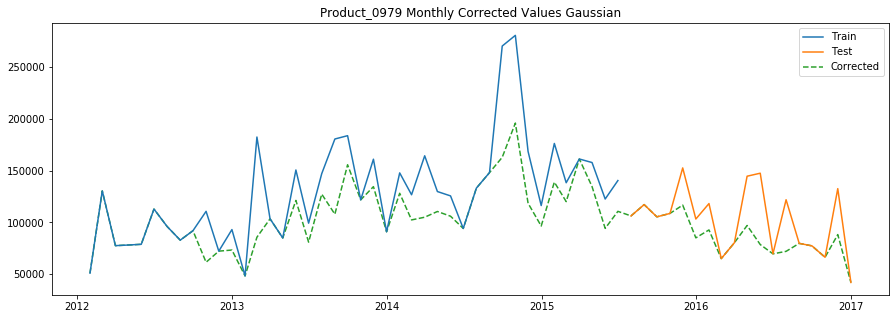

In [ ]:
# Preview of corrected values

plt.figure(figsize=(15,5))
plt.title("Product_0979 Monthly Corrected Values Gaussian")
df1_train = df1_combined_monthly_train[["Product_0979"]]
df1_test = df1_combined_monthly_test[["Product_0979"]]
df1_corrected = monthly_data_gaussian["Product_0979"]

plt.plot(df1_train, label="Train", zorder = 1)
plt.plot(df1_test, label="Test", zorder=1)
plt.plot(df1_corrected, label="Corrected", zorder = -1, linestyle= "--")

plt.legend()
plt.show()

#### Simple Average

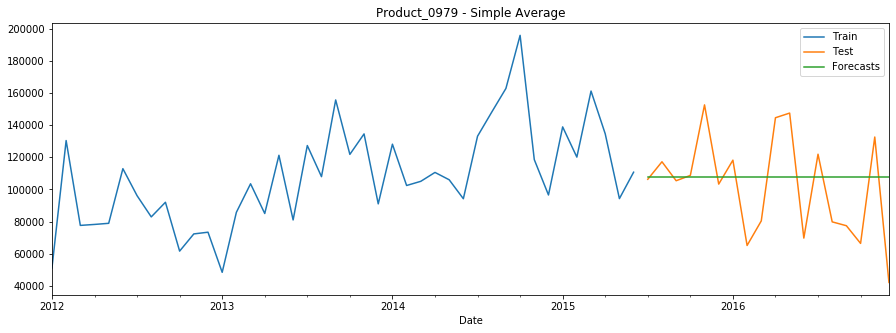

MAPE:  32.526432197895126 MPE:  -18.187312979035827 RMSE:  31411.565611440703


In [ ]:
# Preview
df1_train = df1_combined_monthly_gaussian_train[["Product_0979"]]
df1_test = df1_combined_monthly_test[["Product_0979"]]
df1_forecasts = pd.DataFrame(index=df1_test.index, columns=["Product_0979"])
df1_forecasts["Product_0979"] = [df1_train.Product_0979.mean() for i in range(len(df1_test))]

plt.figure(figsize=(15,5))
plt.title("Product_0979 - Simple Average")
df1_train.Product_0979.plot(label="Train")
df1_test.Product_0979.plot(label="Test")
df1_forecasts.Product_0979.plot(label="Forecasts")
plt.legend()
plt.show()

print("MAPE: ", mean_absolute_percentage_error(df1_test, df1_train.mean()),
      "MPE: ", mean_percentage_error(df1_test, df1_train.mean()),
      "RMSE: ", root_mean_square_error(df1_test, df1_train.mean())[0])

In [ ]:
# Create Dataframe for each product with Product_Name as index
forecast_errors_gaussian_simple_avg = pd.DataFrame(columns=["Product", "MAPE", "MPE", "RMSE"])
forecast_errors_gaussian_simple_avg["Product"] = significant_product_list

MAPE_list = []
MPE_list = []
RMSE_list = []
for product in significant_product_list:
  df1_train = df1_combined_monthly_gaussian_train[[product]]
  df1_test = df1_combined_monthly_test[[product]]

  # Insert the forecast errors to the dataframe
  MAPE_list.append(mean_absolute_percentage_error(df1_test, df1_train.mean()))
  MPE_list.append(mean_percentage_error(df1_test, df1_train.mean()))
  RMSE_list.append(root_mean_square_error(df1_test, df1_train.mean())[0])

forecast_errors_gaussian_simple_avg["MAPE"] = MAPE_list
forecast_errors_gaussian_simple_avg["MPE"] = MPE_list
forecast_errors_gaussian_simple_avg["RMSE"] = RMSE_list
forecast_errors_gaussian_simple_avg.head()

,Product,MAPE,MPE,RMSE
0,Product_0979,32.526432,-18.187313,31411.565611
1,Product_1938,42.198334,20.057835,45.354865
2,Product_1451,21.658623,-5.534054,329781.318859
3,Product_1274,14.015386,-1.046283,239262.777944
4,Product_1512,33.016982,28.463033,87254.951526


#### Moving Average (n=3)

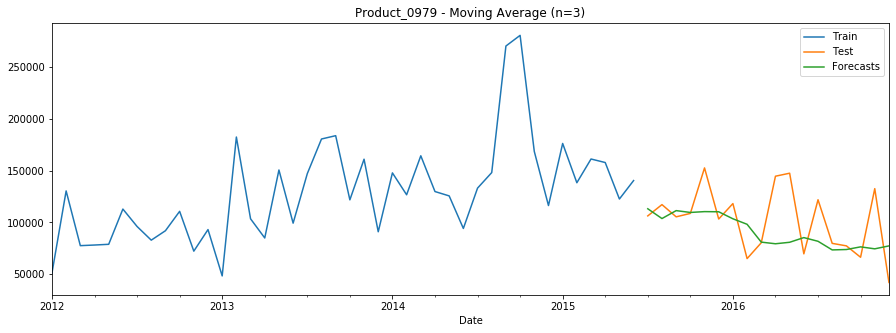

MAPE:  23.537261121029182 MPE:  2.121597146463262 RMSE:  32243.993430110844


In [ ]:
# Preview
smoothed_values = [0,0,0]
df1 = df1_combined_monthly_gaussian[["Product_0979"]]
for i in range(3, len(df1)):
  smoothed_values.append((df1.iloc[i-3, 0]+
                          df1.iloc[i-2, 0]+
                          df1.iloc[i-1, 0])/3)
df1["forecasts"] = smoothed_values
df1_forecasts = df1[int(train_percentage * len(df1)):][["forecasts"]]

plt.figure(figsize=(15,5))
plt.title("Product_0979 - Moving Average (n=3)")
df1_combined_monthly_train["Product_0979"].plot(label="Train")
df1_combined_monthly_test["Product_0979"].plot(label="Test")
df1_forecasts["forecasts"].plot(label="Forecasts")
plt.legend()
plt.show()

print("MAPE: ", mean_absolute_percentage_error(df1_combined_monthly_test[["Product_0979"]], df1_forecasts),
      "MPE: ", mean_percentage_error(df1_combined_monthly_test[["Product_0979"]], df1_forecasts),
      "RMSE: ", root_mean_square_error(df1_combined_monthly_test[["Product_0979"]], df1_forecasts)[0])

In [ ]:
# Create Dataframe for each product with Product_Name as index
forecast_errors_gaussian_moving_average = pd.DataFrame(columns=["Product", "MAPE", "MPE", "RMSE"])
MAPE_list = []
MPE_list = []
RMSE_list = []

n = 3
train_percentage = 0.7
for product in significant_product_list:
  smoothed_values = [0,0,0]
  df1 = df1_combined_monthly_gaussian[[product]]
  for i in range(3, len(df1)):
    smoothed_values.append((df1.iloc[i-3, 0]+
                            df1.iloc[i-2, 0]+
                            df1.iloc[i-1, 0])/3)
  df1["forecasts"] = smoothed_values
  train_len = int(train_percentage * len(df1))
  df2 = df1[train_len:]
  MAPE_list.append(mean_absolute_percentage_error(df2[[product]], df2[["forecasts"]]))
  MPE_list.append(mean_percentage_error(df2[[product]], df2[["forecasts"]]))
  RMSE_list.append(root_mean_square_error(df2[[product]], df2[["forecasts"]])[0])

forecast_errors_gaussian_moving_average["Product"] = significant_product_list
forecast_errors_gaussian_moving_average["RMSE"] = RMSE_list
forecast_errors_gaussian_moving_average["MAPE"] = MAPE_list
forecast_errors_gaussian_moving_average["MPE"] = MPE_list

forecast_errors_gaussian_moving_average.head()

,Product,MAPE,MPE,RMSE
0,Product_0979,17.024759,-10.016032,15617.224482
1,Product_1938,44.688221,-20.783327,30.663792
2,Product_1451,35.810311,-17.969282,445557.495945
3,Product_1274,19.700076,-5.869534,322738.542200
4,Product_1512,38.138385,-11.583122,67586.459211


#### Simple Exponential Smoothing

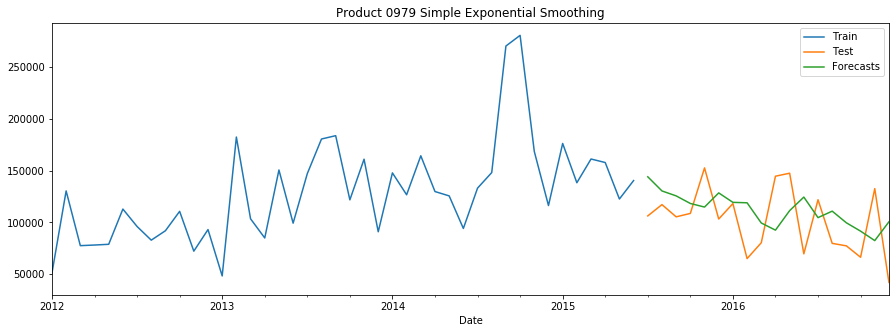

MAPE:  37.0519040525323 MPE:  -21.81040980568941 RMSE:  35562.78353142876


In [ ]:
# Preview
df1_train = df1_combined_monthly_gaussian_train[["Product_0979"]]
df1 = df1_combined_monthly[["Product_0979"]]
mod = SimpleExpSmoothing(df1_train)
res = mod.fit(optimized=True)

mod_df1 = SimpleExpSmoothing(df1)
res_df1 = mod_df1.fit(optimized=False, smoothing_level=res.params["smoothing_level"], initial_level=res.params["initial_level"])

forecasts = res_df1.fittedvalues[train_len:] # Fitted values at time t equals to forecast of t-1

plt.figure(figsize=(15,5))
plt.title("Product 0979 Simple Exponential Smoothing")
df1_combined_monthly_train["Product_0979"].plot(label="Train")
df1_combined_monthly_test["Product_0979"].plot(label="Test")
forecasts.plot(label="Forecasts")
plt.legend()
plt.show()

print("MAPE: ", mean_absolute_percentage_error(df1_combined_monthly_test["Product_0979"], forecasts),
      "MPE: ", mean_percentage_error(df1_combined_monthly_test["Product_0979"], forecasts),
      "RMSE: ", root_mean_square_error(df1_combined_monthly_test["Product_0979"], forecasts))

In [ ]:
forecast_errors_gaussian_expsmoothing = pd.DataFrame(columns=["Product", "MAPE", "MPE", "RMSE"])
MAPE = []
MPE = []
RMSE = []

for product in significant_product_list:

  df1_train = df1_combined_monthly_gaussian_train[[product]]
  df1 = df1_combined_monthly_gaussian[[product]]
  mod = SimpleExpSmoothing(df1_train)
  res = mod.fit(optimized=True)
  
  mod_df1 = SimpleExpSmoothing(df1)
  res_df1 = mod_df1.fit(optimized=False, smoothing_level=res.params["smoothing_level"], initial_level=res.params["initial_level"])

  forecasts = res_df1.fittedvalues[train_len:]
  MAPE.append(mean_absolute_percentage_error(df1_combined_monthly_test[product], forecasts))
  MPE.append(mean_percentage_error(df1_combined_monthly_test[product], forecasts))
  RMSE.append(root_mean_square_error(df1_combined_monthly_test[product], forecasts))

forecast_errors_gaussian_expsmoothing["Product"] = significant_product_list
forecast_errors_gaussian_expsmoothing["MAPE"] = MAPE
forecast_errors_gaussian_expsmoothing["MPE"] = MPE
forecast_errors_gaussian_expsmoothing["RMSE"] = RMSE

forecast_errors_gaussian_expsmoothing.head()

,Product,MAPE,MPE,RMSE
0,Product_0979,23.739974,-0.680888,31247.364549
1,Product_1938,38.609233,-9.718588,36.442669
2,Product_1451,27.103751,-1.881126,396526.849827
3,Product_1274,17.976929,-3.898597,298558.224976
4,Product_1512,27.836136,15.045791,76256.285232


#### Holt's

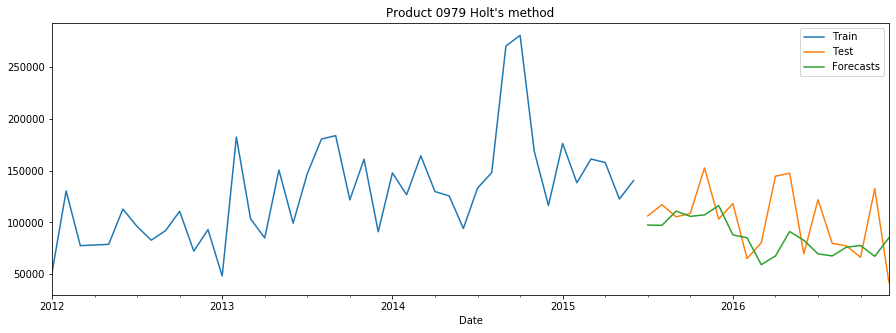

MAPE:  27.592900599353925 MPE:  6.837976229851677 RMSE:  35655.69211276994


In [ ]:
# Preview

df1_train = df1_combined_monthly_gaussian_train[["Product_0979"]]
df1 = df1_combined_monthly_gaussian[["Product_0979"]]
mod = Holt(df1_train)
res = mod.fit(optimized=True)

mod_df1 = Holt(df1)
res_df1 = mod_df1.fit(optimized=False, 
                      smoothing_level=res.params["smoothing_level"],
                      smoothing_trend=res.params["smoothing_trend"],
                      initial_level=res.params["initial_level"],
                      initial_trend=res.params["initial_trend"])

forecasts = res_df1.fittedvalues[train_len:]

plt.figure(figsize=(15,5))
plt.title("Product 0979 Holt's method")
df1_combined_monthly_train["Product_0979"].plot(label="Train")
df1_combined_monthly_test["Product_0979"].plot(label="Test")
forecasts.plot(label="Forecasts")
plt.legend()
plt.show()

print("MAPE: ", mean_absolute_percentage_error(df1_combined_monthly_test["Product_0979"], forecasts),
      "MPE: ", mean_percentage_error(df1_combined_monthly_test["Product_0979"], forecasts),
      "RMSE: ", root_mean_square_error(df1_combined_monthly_test["Product_0979"], forecasts))

In [ ]:
forecast_errors_gaussian_Holt = pd.DataFrame(columns=["Product", "MAPE", "MPE", "RMSE"])
MAPE = []
MPE = []
RMSE = []
for product in significant_product_list:

  df1_train = df1_combined_monthly_gaussian_train[[product]]
  df1 = df1_combined_monthly_gaussian[[product]]
  mod = Holt(df1_train)
  res = mod.fit(optimized=True)
  
  mod_df1 = Holt(df1)
  res_df1 = mod_df1.fit(optimized=False, 
                        smoothing_level=res.params["smoothing_level"],
                        smoothing_trend=res.params["smoothing_trend"],
                        initial_level=res.params["initial_level"],
                        initial_trend=res.params["initial_trend"])

  forecasts = res_df1.fittedvalues[train_len:]
  MAPE.append(mean_absolute_percentage_error(df1_combined_monthly_test[product], forecasts))
  MPE.append(mean_percentage_error(df1_combined_monthly_test[product], forecasts))
  RMSE.append(root_mean_square_error(df1_combined_monthly_test[product], forecasts))

forecast_errors_gaussian_Holt["Product"] = significant_product_list
forecast_errors_gaussian_Holt["MAPE"] = MAPE
forecast_errors_gaussian_Holt["MPE"] = MPE
forecast_errors_gaussian_Holt["RMSE"] = RMSE

forecast_errors_gaussian_Holt.head()

,Product,MAPE,MPE,RMSE
0,Product_0979,27.592901,6.837976,35655.692113
1,Product_1938,43.834015,-18.416717,36.223302
2,Product_1451,36.051612,-2.354710,511711.574147
3,Product_1274,24.228398,-7.182585,388551.068243
4,Product_1512,43.768370,7.815291,103234.218885


#### Holt-Winter's (S=12)

In [ ]:
forecast_errors_gaussian_HoltWinters = pd.DataFrame(columns=["Product", "MAPE", "MPE", "RMSE"])
MAPE = []
MPE = []
RMSE = []
for product in significant_product_list:

  df1_train = df1_combined_monthly_gaussian_train[[product]]
  df1 = df1_combined_monthly_gaussian[[product]]
  mod = ExponentialSmoothing(df1_train, trend="add", seasonal_periods=12, seasonal="add")
  res = mod.fit(optimized=True)
  
  mod_df1 = ExponentialSmoothing(df1, trend="add", seasonal_periods=12, seasonal="add",
                                 initialization_method="known",
                                 initial_level=res.params["initial_level"],
                                 initial_trend=res.params["initial_trend"],
                                 initial_seasonal=res.params["initial_seasons"])
  res_df1 = mod_df1.fit(smoothing_level=res.params["smoothing_level"],
                        smoothing_trend=res.params["smoothing_trend"],
                        smoothing_seasonal=res.params["smoothing_seasonal"])

  forecasts = res_df1.fittedvalues[train_len:]
  MAPE.append(mean_absolute_percentage_error(df1_combined_monthly_test[product], forecasts))
  MPE.append(mean_percentage_error(df1_combined_monthly_test[product], forecasts))
  RMSE.append(sm.tools.eval_measures.rmse(df1_combined_monthly_test[product], forecasts))

forecast_errors_gaussian_HoltWinters["Product"] = significant_product_list
forecast_errors_gaussian_HoltWinters["MAPE"] = MAPE
forecast_errors_gaussian_HoltWinters["MPE"] = MPE
forecast_errors_gaussian_HoltWinters["RMSE"] = RMSE

forecast_errors_gaussian_HoltWinters.head()

,Product,MAPE,MPE,RMSE
0,Product_0979,42.057209,-29.910194,40903.680384
1,Product_1938,40.024428,-6.347556,34.648715
2,Product_1451,23.601322,-8.926559,329276.920529
3,Product_1274,15.764820,-3.576307,255492.553244
4,Product_1512,27.269185,22.184623,76497.799811


#### ARIMA

In [ ]:
# This the ARIMA function. It returns the dictionary of each product to its:
  # Best model Order based on minimum AIC
  # The train AIC
  # Fitted values of the train data
  # The generated Forecasts
  # The prediction intervals

from statsmodels.tsa.arima.model import ARIMA

def arima_func(product, dataframe, return_dict):
    
    # Assign the endogenous model
    endog = dataframe

    # Setup forecasts
    nforecasts = 1
    forecasts = {}

    # Get the number of initial training observations
    train_percentage = 0.7
    nobs = len(endog)
    n_init_training = int(nobs * train_percentage)

    # Dictionary of model order to the fitted model and its corresponding statistics
    ARIMA_model_dict = {}
    aic = 99999999
    
    # Create model for initial training sample, fit parameters
    training_endog = endog.iloc[:n_init_training]
    for p in range(0,4):
      for d in range(0,4):
        for q in range(0,4):
          try:             
            mod = ARIMA(training_endog, order=(p,d,q))
            res = mod.fit()

            if res.aic < aic:
                aic = res.aic

                ARIMA_model_dict["Model_Order"] = (p,d,q)
                ARIMA_model_dict["train_AIC"] = aic
                ARIMA_model_dict["train_fittedvalues"] = res.fittedvalues

                # Initial forecast and prediction interval DataFrame
                df_forecast = res.get_forecast(steps=1).predicted_mean
                df_prediction_interval = res.get_forecast(steps=1).conf_int(alpha=0.05)

                # Iterate through the rest of the sample
                for t in range(n_init_training, nobs):
                    # Update the results by appending the next observation
                    updated_endog = endog.iloc[t:t+1]
                    res = res.append(updated_endog, refit=False)

                    # Save the new set of forecasts and prediction intervals
                    forecast_object = res.get_forecast(1)
                    df_forecast = df_forecast.append(forecast_object.predicted_mean)
                    df_prediction_interval = df_prediction_interval.append(forecast_object.conf_int(alpha=0.05))

                ARIMA_model_dict["forecasts"] = df_forecast
                ARIMA_model_dict["prediction_intervals"] = df_prediction_interval
          except:
            print(product, "Model Order", (p,d,q), "could not be fitted")

    return_dict[product] = ARIMA_model_dict

    return

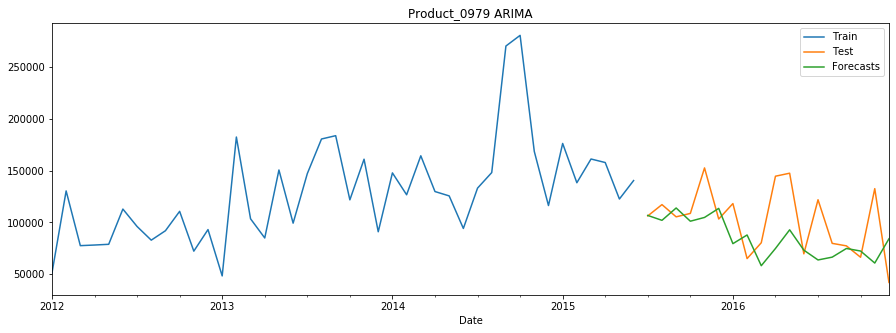

MAPE:  27.001511444425336 MPE:  8.377468941120396 RMSE:  36232.96886288692


In [ ]:
# Preview
product_gaussian_ARIMA_dict = {}
arima_func("Product_0979", df1_combined_monthly_gaussian[["Product_0979"]], product_gaussian_ARIMA_dict)

plt.figure(figsize=(15,5))
plt.title("Product_0979 ARIMA")
df1_combined_monthly_train["Product_0979"].plot(label="Train")
df1_combined_monthly_test["Product_0979"].plot(label="Test")
product_gaussian_ARIMA_dict["Product_0979"]["forecasts"][:-1].plot(label="Forecasts") # The last datapoint is not counted as it's the forecast outside the test dataset
plt.legend()
plt.show()

print("MAPE: ", mean_absolute_percentage_error(df1_combined_monthly_test["Product_0979"], product_gaussian_ARIMA_dict["Product_0979"]["forecasts"][:-1]),
      "MPE: ", mean_percentage_error(df1_combined_monthly_test["Product_0979"], product_gaussian_ARIMA_dict["Product_0979"]["forecasts"][:-1]),
      "RMSE: ", root_mean_square_error(df1_combined_monthly_test["Product_0979"], product_gaussian_ARIMA_dict["Product_0979"]["forecasts"][:-1]))

In [ ]:
for product in significant_product_list:
  arima_func(product, df1_combined_monthly_gaussian[[product]], product_gaussian_ARIMA_dict)

# Sound Ding when done
import winsound
duration = 10000  # milliseconds
freq = 777  # Hz
winsound.Beep(freq, duration)

Product_0214 Model Order (2, 3, 3) could not be fitted
Product_2132 Model Order (2, 2, 3) could not be fitted
Product_1216 Model Order (2, 2, 2) could not be fitted
Product_0250 Model Order (2, 3, 3) could not be fitted
Product_1541 Model Order (3, 3, 2) could not be fitted
Product_0019 Model Order (3, 3, 2) could not be fitted
Product_0905 Model Order (2, 1, 2) could not be fitted
Product_1908 Model Order (2, 3, 3) could not be fitted


In [ ]:
forecast_errors_gaussian_ARIMA = pd.DataFrame(columns=["Product", "MAPE", "MPE", "RMSE"])
mape_list = []
mpe_list = []
rmse_list = []

for product in product_gaussian_ARIMA_dict:
  mape = mean_absolute_percentage_error(df1_combined_monthly_test[product],
                                        product_gaussian_ARIMA_dict[product]["forecasts"][:-1])
  mpe = mean_percentage_error(df1_combined_monthly_test[product],
                              product_gaussian_ARIMA_dict[product]["forecasts"][:-1])
  rmse = root_mean_square_error(df1_combined_monthly_test[product],
                                product_gaussian_ARIMA_dict[product]["forecasts"][:-1])
  
  mape_list.append(mape)
  mpe_list.append(mpe)
  rmse_list.append(rmse)

forecast_errors_gaussian_ARIMA["Product"] = significant_product_list
forecast_errors_gaussian_ARIMA["MAPE"] = mape_list
forecast_errors_gaussian_ARIMA["MPE"] = mpe_list
forecast_errors_gaussian_ARIMA["RMSE"] = rmse_list

forecast_errors_gaussian_ARIMA.head()

,Product,MAPE,MPE,RMSE
0,Product_0979,27.001511,8.377469,36232.968863
1,Product_1938,44.028504,-19.661817,35.329071
2,Product_1451,35.361215,-1.640863,515194.283552
3,Product_1274,23.127815,-7.798060,376566.572479
4,Product_1512,38.085486,4.722304,88907.185046


#### SARIMA

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

def sarima_func(product, dataframe, return_dict):
    
    # Assign the endogenous model
    endog = dataframe

    # Setup forecasts
    nforecasts = 1
    forecasts = {}

    # Get the number of initial training observations
    train_percentage = 0.7
    nobs = len(endog)
    n_init_training = int(nobs * train_percentage)

    # Dictionary of model order to the fitted model and its corresponding statistics
    SARIMA_model_dict = {}
    aic = 99999999
    
    # Create model for initial training sample, fit parameters
    training_endog = endog.iloc[:n_init_training]
    for p in range(0,2):
      for d in range(0,2):
        for q in range(0,2):
          for P in range(0,2):
            for D in range(0,2):
              for Q in range(0,2):
                try:             
                  mod = SARIMAX(training_endog, order=(p,d,q), seasonal_order=(P,D,Q,12))
                  res = mod.fit()

                  if res.aic < aic:
                      aic = res.aic

                      SARIMA_model_dict["Model_Order"] = ((p,d,q),(P,D,Q))
                      SARIMA_model_dict["train_AIC"] = aic
                      SARIMA_model_dict["train_fittedvalues"] = res.fittedvalues

                      # Initial forecast and prediction interval DataFrame
                      df_forecast = res.get_forecast(steps=1).predicted_mean
                      df_prediction_interval = res.get_forecast(steps=1).conf_int(alpha=0.05)

                      # Iterate through the rest of the sample
                      for t in range(n_init_training, nobs):
                          # Update the results by appending the next observation
                          updated_endog = endog.iloc[t:t+1]
                          res = res.append(updated_endog, refit=False)

                          # Save the new set of forecasts and prediction intervals
                          forecast_object = res.get_forecast(1)
                          df_forecast = df_forecast.append(forecast_object.predicted_mean)
                          df_prediction_interval = df_prediction_interval.append(forecast_object.conf_int(alpha=0.05))

                      SARIMA_model_dict["forecasts"] = df_forecast
                      SARIMA_model_dict["prediction_intervals"] = df_prediction_interval

                except:
                  None

    return_dict[product] = SARIMA_model_dict

    return

In [ ]:
product_gaussian_SARIMA_dict = {}
for product in significant_product_list:
  sarima_func(product, df1_combined_monthly_gaussian[[product]], product_gaussian_SARIMA_dict)

# Sound Ding when done
import winsound
duration = 10000  # milliseconds
freq = 777  # Hz
winsound.Beep(freq, duration)

In [ ]:
forecast_errors_gaussian_SARIMA = pd.DataFrame(columns=["Product", "MAPE", "MPE", "RMSE"])
mape_list = []
mpe_list = []
rmse_list = []

for product in product_gaussian_SARIMA_dict:
  mape = mean_absolute_percentage_error(df1_combined_monthly_test[product],
                                        product_gaussian_SARIMA_dict[product]["forecasts"][:-1])
  mpe = mean_percentage_error(df1_combined_monthly_test[product],
                              product_gaussian_SARIMA_dict[product]["forecasts"][:-1])
  rmse = root_mean_square_error(df1_combined_monthly_test[product],
                                product_gaussian_SARIMA_dict[product]["forecasts"][:-1])
  
  mape_list.append(mape)
  mpe_list.append(mpe)
  rmse_list.append(rmse)

forecast_errors_gaussian_SARIMA["Product"] = significant_product_list
forecast_errors_gaussian_SARIMA["MAPE"] = mape_list
forecast_errors_gaussian_SARIMA["MPE"] = mpe_list
forecast_errors_gaussian_SARIMA["RMSE"] = rmse_list

forecast_errors_gaussian_SARIMA.head()

,Product,MAPE,MPE,RMSE
0,Product_0979,25.742929,3.618013,39654.119057
1,Product_1938,52.988203,-24.033514,42.219390
2,Product_1451,39.361990,-5.065951,609808.627065
3,Product_1274,19.173993,-7.209742,327278.883047
4,Product_1512,30.631096,9.834882,75786.722082


In [ ]:
forecast_errors_gaussian_SARIMA.MAPE.mean()

100.53101755900815

#### VAR

In [ ]:
import time
import multiprocessing
from multiprocessing import Process, Queue, Manager
from statsmodels.tsa.statespace.varmax import VARMAX

import varma_func

batch_size = len(significant_product_list)/4
batched_lists = []
for i in range(0,4):
  batched_lists.append(significant_product_list[int(i*batch_size):int((i+1)*batch_size)])

product_gaussian_VAR_dict = {}

for batched_list in batched_lists:
  dataframes_list = []
  for product in batched_list:  
    dataframes_list.append((product, df1_combined_monthly_gaussian[[product] + predictors_dict[product]].astype("float")))

  if __name__ == '__main__':
      manager = multiprocessing.Manager()
      return_dict = manager.dict()

      starttime = time.time()
      processes = []

      for product, dataframe in dataframes_list:
          p = Process(target=varma_func.var_func, args=(product, dataframe, return_dict))
          processes.append(p)
          p.start()
          
      for process in processes:
          process.join()
      
      print('Batch processed. Time elapsed: {} seconds'.format(time.time() - starttime))

  for product in return_dict:
    product_gaussian_VAR_dict[product] = return_dict[product]

# Sound Checkpoint
import winsound
duration = 10000  # milliseconds
freq = 777  # Hz
winsound.Beep(freq, duration)

Batch processed. Time elapsed: 2570.0724306106567 seconds
Batch processed. Time elapsed: 2650.5687811374664 seconds
Batch processed. Time elapsed: 2566.203268289566 seconds
Batch processed. Time elapsed: 2620.805396795273 seconds


In [ ]:
forecast_errors_gaussian_VAR = pd.DataFrame(columns=["Product", "MAPE", "MPE", "RMSE"])
mape_list = []
mpe_list = []
rmse_list = []

for product in product_gaussian_VAR_dict:
  mape = mean_absolute_percentage_error(df1_combined_monthly_test[product],
                                        product_gaussian_VAR_dict[product]["forecasts"][product][:-1])
  mpe = mean_percentage_error(df1_combined_monthly_test[product],
                              product_gaussian_VAR_dict[product]["forecasts"][product][:-1])
  rmse = root_mean_square_error(df1_combined_monthly_test[product],
                                product_gaussian_VAR_dict[product]["forecasts"][product][:-1])
  
  mape_list.append(mape)
  mpe_list.append(mpe)
  rmse_list.append(rmse)

forecast_errors_gaussian_VAR["Product"] = significant_product_list
forecast_errors_gaussian_VAR["MAPE"] = mape_list
forecast_errors_gaussian_VAR["MPE"] = mpe_list
forecast_errors_gaussian_VAR["RMSE"] = rmse_list

forecast_errors_gaussian_VAR.head()

,Product,MAPE,MPE,RMSE
0,Product_0979,40.109269,-21.502610,32319.838780
1,Product_1938,39.003792,37.616576,95132.454592
2,Product_1451,22.254352,2.860114,81555.118233
3,Product_1274,18.173135,6.665982,27427.687194
4,Product_1512,13.952125,8.533582,234884.964896


In [ ]:
forecast_errors_gaussian_VAR.MAPE.mean()

57.73593104047184

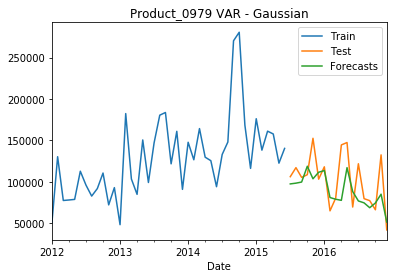

MAPE:  18.173135256879945 MPE:  6.6659817159339925 RMSE:  27427.687194408434


In [ ]:
# Preview

plt.figure()
plt.title("Product_0979 VAR - Gaussian")
df1_combined_monthly_train["Product_0979"].plot(label="Train")
df1_combined_monthly_test["Product_0979"].plot(label="Test")
product_gaussian_VAR_dict["Product_0979"]["forecasts"]["Product_0979"][:-1].plot(label="Forecasts") # The last datapoint is not counted as it's the forecast outside the test dataset
plt.legend()
plt.savefig('C:\\Users\\renal\\Documents\\HEC Supervised Project\\VAR_gaussian.jpg')
plt.show()

print("MAPE: ", mean_absolute_percentage_error(df1_combined_monthly_test["Product_0979"], product_gaussian_VAR_dict["Product_0979"]["forecasts"]["Product_0979"][:-1]),
      "MPE: ", mean_percentage_error(df1_combined_monthly_test["Product_0979"], product_gaussian_VAR_dict["Product_0979"]["forecasts"]["Product_0979"][:-1]),
      "RMSE: ", root_mean_square_error(df1_combined_monthly_test["Product_0979"], product_gaussian_VAR_dict["Product_0979"]["forecasts"]["Product_0979"][:-1]))

#### VMA

In [ ]:
import time
import multiprocessing
from multiprocessing import Process, Queue, Manager
from statsmodels.tsa.statespace.varmax import VARMAX

import varma_func

batch_size = len(significant_product_list)/4
batched_lists = []
for i in range(0,4):
  batched_lists.append(significant_product_list[int(i*batch_size):int((i+1)*batch_size)])

product_gaussian_VMA_dict = {}

for batched_list in batched_lists:
  dataframes_list = []
  for product in batched_list:  
    dataframes_list.append((product, df1_combined_monthly_gaussian[[product] + predictors_dict[product]].astype("float")))

  if __name__ == '__main__':
      manager = multiprocessing.Manager()
      return_dict = manager.dict()

      starttime = time.time()
      processes = []

      for product, dataframe in dataframes_list:
          p = Process(target=varma_func.vma_func, args=(product, dataframe, return_dict))
          processes.append(p)
          p.start()
          
      for process in processes:
          process.join()
      
      print('That took {} seconds'.format(time.time() - starttime))

  for product in return_dict:
    product_gaussian_VMA_dict[product] = return_dict[product]

# Sound Checkpoint
import winsound
duration = 10000  # milliseconds
freq = 777  # Hz
winsound.Beep(freq, duration)

That took 2345.2657902240753 seconds
That took 2419.1139385700226 seconds
That took 2124.1961872577667 seconds
That took 2227.5741832256317 seconds


In [ ]:
forecast_errors_DBSCAN_VMA = pd.DataFrame(columns=["Product", "MAPE", "MPE", "RMSE"])
mape_list = []
mpe_list = []
rmse_list = []

for product in product_DBSCAN_VMA_dict:
  mape = mean_absolute_percentage_error(df1_combined_monthly_test[product],
                                        product_DBSCAN_VMA_dict[product]["forecasts"][product][:-1])
  mpe = mean_percentage_error(df1_combined_monthly_test[product],
                              product_DBSCAN_VMA_dict[product]["forecasts"][product][:-1])
  rmse = root_mean_square_error(df1_combined_monthly_test[product],
                                product_DBSCAN_VMA_dict[product]["forecasts"][product][:-1])
  
  mape_list.append(mape)
  mpe_list.append(mpe)
  rmse_list.append(rmse)

forecast_errors_DBSCAN_VMA["Product"] = significant_product_list
forecast_errors_DBSCAN_VMA["MAPE"] = mape_list
forecast_errors_DBSCAN_VMA["MPE"] = mpe_list
forecast_errors_DBSCAN_VMA["RMSE"] = rmse_list

forecast_errors_DBSCAN_VMA.head()

,Product,MAPE,MPE,RMSE
0,Product_0979,26.692207,-4.161257,59932.351403
1,Product_1938,38.007818,37.134726,93092.960575
2,Product_1451,37.129157,-4.149009,43730.588309
3,Product_1274,51.426149,7.996420,165013.496992
4,Product_1512,38.715002,0.466312,18048.926506


In [ ]:
forecast_errors_gaussian_VMA.MAPE.mean()

90.82069830670257

#### VARMA

In [ ]:
import time
import multiprocessing
from multiprocessing import Process, Queue, Manager
from statsmodels.tsa.statespace.varmax import VARMAX

import varma_func

batch_size = len(significant_product_list)/4
batched_lists = []
for i in range(0,4):
  batched_lists.append(significant_product_list[int(i*batch_size):int((i+1)*batch_size)])

product_gaussian_VARMA_dict = {}

for batched_list in batched_lists:
  dataframes_list = []
  for product in batched_list:  
    dataframes_list.append((product, df1_combined_monthly_gaussian[[product] + predictors_dict[product]].astype("float")))

  if __name__ == '__main__':
      manager = multiprocessing.Manager()
      return_dict = manager.dict()

      starttime = time.time()
      processes = []

      for product, dataframe in dataframes_list:
          p = Process(target=varma_func.varma_func, args=(product, dataframe, return_dict))
          processes.append(p)
          p.start()
          
      for process in processes:
          process.join()
      
      print('That took {} seconds'.format(time.time() - starttime))

  for product in return_dict:
    product_gaussian_VARMA_dict[product] = return_dict[product]

# Sound Checkpoint
import winsound
duration = 10000  # milliseconds
freq = 777  # Hz
winsound.Beep(freq, duration)

That took 677.3899765014648 seconds
That took 682.5009324550629 seconds
That took 669.652515411377 seconds
That took 756.96786236763 seconds


In [ ]:
forecast_errors_gaussian_VARMA = pd.DataFrame(columns=["Product", "MAPE", "MPE", "RMSE"])
mape_list = []
mpe_list = []
rmse_list = []

for product in product_gaussian_VARMA_dict:
  mape = mean_absolute_percentage_error(df1_combined_monthly_test[product],
                                        product_gaussian_VARMA_dict[product]["forecasts"][product][:-1])
  mpe = mean_percentage_error(df1_combined_monthly_test[product],
                              product_gaussian_VARMA_dict[product]["forecasts"][product][:-1])
  rmse = root_mean_square_error(df1_combined_monthly_test[product],
                                product_gaussian_VARMA_dict[product]["forecasts"][product][:-1])
  
  mape_list.append(mape)
  mpe_list.append(mpe)
  rmse_list.append(rmse)

forecast_errors_gaussian_VARMA["Product"] = significant_product_list
forecast_errors_gaussian_VARMA["MAPE"] = mape_list
forecast_errors_gaussian_VARMA["MPE"] = mpe_list
forecast_errors_gaussian_VARMA["RMSE"] = rmse_list

forecast_errors_gaussian_VARMA.head()

,Product,MAPE,MPE,RMSE
0,Product_0979,17.379459,14.166562,286221.438315
1,Product_1938,50.958031,-23.559788,127285.761734
2,Product_1451,36.182772,35.541294,89312.561577
3,Product_1274,49.331612,-27.980236,40013.769987
4,Product_1512,35.710063,-15.082238,72449.432153


In [ ]:
forecast_errors_gaussian_VARMA.MAPE.mean()

98.44075343881649

#### Pickle

In [ ]:
import pickle

# Function of the code below is to save the dictionary/dataframes above
variables_list = [products_dataframe_gaussian, monthly_data_gaussian,
                  product_gaussian_ARIMA_dict, forecast_errors_gaussian_ARIMA,
                  product_gaussian_SARIMA_dict, forecast_errors_gaussian_SARIMA,
                  product_gaussian_VAR_dict, forecast_errors_gaussian_VAR,
                  product_gaussian_VMA_dict, forecast_errors_gaussian_VMA,
                  product_gaussian_VARMA_dict, forecast_errors_gaussian_VARMA]

with open('C:\\Users\\renal\\Documents\\HEC Supervised Project\\workflow2_gaussian.pkl', 'wb') as f:
    pickle.dump(variables_list, f)

### DBSCAN

In [ ]:
import pickle

with open('C:\\Users\\renal\\Documents\\HEC Supervised Project\\workflow2_DBSCAN.pkl', 'rb') as f:
  [products_dataframe_DBSCAN, monthly_data_gaussian,
  product_DBSCAN_ARIMA_dict, forecast_errors_DBSCAN_ARIMA,
  product_DBSCAN_SARIMA_dict, forecast_errors_DBSCAN_SARIMA,
  product_DBSCAN_VAR_dict, forecast_errors_DBSCAN_VAR,
  product_DBSCAN_VMA_dict, forecast_errors_DBSCAN_VMA,
  product_DBSCAN_VARMA_dict, forecast_errors_DBSCAN_VARMA] = pickle.load(f)

#### Data Transformation

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import DBSCAN

products_dataframe_DBSCAN = {}
monthly_data_DBSCAN = {}

# For DBSCAN, the approach is different from iForest or Gaussian
# A rolling window DBSCAN is used to identify anomalies in the data

eps = 0.5
for product in significant_product_list:

  date_indexes = df1_combined_monthly.index

  df1 = products_dataframe[product][["Date", "Order_Demand"]]
  df1 = df1.loc[df1["Date"] <= max_date]

  # Convert Date into scalar date
  scalar_dates = [0] #The first order is the beginning point    
  for i in range(1, len(df1)):
    delta = df1.loc[i,"Date"] - df1.loc[0,"Date"]
    scalar_dates.append(delta/np.timedelta64(1,'D'))
  df1["scalar_dates"] = scalar_dates

  # Extract Data from the first month
  df1_month = df1.loc[df1["Date"] <= date_indexes[0]]

  # Scale the demand and dates on a 0-1 Min-Max Normalisation. This is necessary because the units for Demand and Date is different.
  scaler = MinMaxScaler()
  df1_month["scaled_demand"] = scaler.fit_transform(df1_month[["Order_Demand"]])
  df1_month["scaled_dates"] = scaler.fit_transform(df1_month[["Date"]])

  # Apply DBSCAN
  clustering = DBSCAN(eps=eps, min_samples=int(len(df1_month)/4), metric="euclidean").fit(df1_month[["scaled_demand", "scaled_dates"]])
  anomalies_bool_array = clustering.labels_

  # Do the above steps for the rest of the dataset, one month at a time
  for i in range(1, len(date_indexes)):
    df1_month = df1.loc[(df1["Date"]>date_indexes[i-1]) & (df1["Date"] <= date_indexes[i])]

    scaler = MinMaxScaler()
    df1_month["scaled_demand"] = scaler.fit_transform(df1_month[["Order_Demand"]])
    df1_month["scaled_dates"] = scaler.fit_transform(df1_month[["Date"]])

    # Apply DBSCAN
    clustering = DBSCAN(eps=eps, min_samples=int(len(df1_month)/4), metric="euclidean").fit(df1_month[["scaled_demand", "scaled_dates"]])
    anomalies_bool_array = np.append(anomalies_bool_array, clustering.labels_)

  df1["anomalies"] = anomalies_bool_array
  df1["corrected_values"] = df1.Order_Demand

  for index in df1[2:].index:
    if df1.loc[index, "anomalies"] == -1: # If the order demand is identified to be an anomaly
      df1.loc[index, "corrected_values"] = df1[(index-3):index]["Order_Demand"].mean() # Corrected values is the average of the last 3 orders

  products_dataframe_DBSCAN[product] = df1

  # Next, we group them again monthly based on the timeframe intersection already found
  df1 = df1.loc[df1["Date"] >= min_date]
  df1 = df1.loc[df1["Date"] <= max_date]
  df1 = df1[["Date", "corrected_values"]]
  df1 = df1.groupby([pd.Grouper(key="Date", freq="M")]).sum().reset_index()
  df1 = df1.set_index("Date")
  monthly_data_DBSCAN[product] = df1

In [ ]:
# Combine them into one dataframe
df1_combined_monthly_DBSCAN = pd.DataFrame(index=df1.index)

for product in significant_product_list:
  df1_combined_monthly_DBSCAN[product] = monthly_data_DBSCAN[product].corrected_values.tolist()

ValueError: ignored

In [ ]:
train_percentage = 0.7 # Percentage of train dataset

# Train dataset
df1_combined_monthly_DBSCAN_train = df1_combined_monthly_DBSCAN[:int(train_percentage*len(df1_combined_monthly_DBSCAN))]

# Test dataset
df1_combined_monthly_DBSCAN_test = df1_combined_monthly_DBSCAN[int(train_percentage*len(df1_combined_monthly_DBSCAN)):]

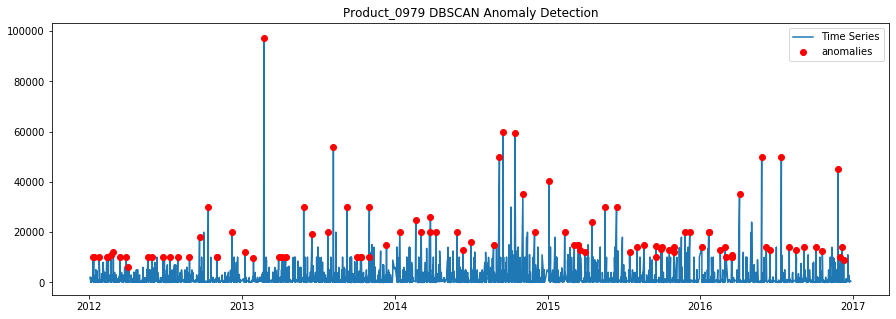

In [ ]:
# Preview of Anomaly Detection
plt.figure(figsize=(15,5))
plt.title("Product_0979 DBSCAN Anomaly Detection")
plt.plot(products_dataframe["Product_0979"].Date, 
         products_dataframe["Product_0979"].Order_Demand,
         zorder=1,
         label="Time Series")

df1_anomalies = products_dataframe_DBSCAN["Product_0979"]
df1_anomalies = df1_anomalies.loc[df1_anomalies["anomalies"] == -1]

plt.scatter(df1_anomalies.Date, 
            df1_anomalies.Order_Demand,
            color="red", 
            zorder=2,
            label="anomalies")

plt.legend()
plt.show()

NameError: ignored

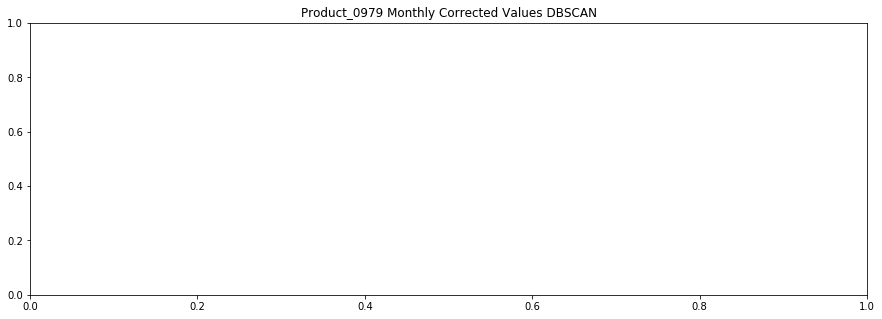

In [ ]:
# Preview of corrected values

plt.figure(figsize=(15,5))
plt.title("Product_0979 Monthly Corrected Values DBSCAN")
df1_train = df1_combined_monthly_train[["Product_0979"]]
df1_test = df1_combined_monthly_test[["Product_0979"]]
df1_corrected = monthly_data_DBSCAN["Product_0979"]

plt.plot(df1_train, label="Train", zorder = 1)
plt.plot(df1_test, label="Test", zorder=1)
plt.plot(df1_corrected, label="Corrected", zorder = -1, linestyle= "--")

plt.legend()
plt.show()

#### Simple Average

In [ ]:
# Preview
df1_train = df1_combined_monthly_DBSCAN_train[["Product_0979"]]
df1_test = df1_combined_monthly_test[["Product_0979"]]
df1_forecasts = pd.DataFrame(index=df1_test.index, columns=["Product_0979"])
df1_forecasts["Product_0979"] = [df1_train.Product_0979.mean() for i in range(len(df1_test))]

plt.figure(figsize=(15,5))
plt.title("Product_0979 - Simple Average")
df1_train.Product_0979.plot(label="Train")
df1_test.Product_0979.plot(label="Test")
df1_forecasts.Product_0979.plot(label="Forecasts")
plt.legend()
plt.show()

print("MAPE: ", mean_absolute_percentage_error(df1_test, df1_train.mean()),
      "MPE: ", mean_percentage_error(df1_test, df1_train.mean()),
      "RMSE: ", root_mean_square_error(df1_test, df1_train.mean())[0])

In [ ]:
# Create Dataframe for each product with Product_Name as index
forecast_errors_DBSCAN_simple_avg = pd.DataFrame(columns=["Product", "MAPE", "MPE", "RMSE"])
forecast_errors_DBSCAN_simple_avg["Product"] = significant_product_list

MAPE_list = []
MPE_list = []
RMSE_list = []
for product in significant_product_list:
  df1_train = df1_combined_monthly_DBSCAN_train[[product]]
  df1_test = df1_combined_monthly_test[[product]]

  # Insert the forecast errors to the dataframe
  MAPE_list.append(mean_absolute_percentage_error(df1_test, df1_train.mean()))
  MPE_list.append(mean_percentage_error(df1_test, df1_train.mean()))
  RMSE_list.append(root_mean_square_error(df1_test, df1_train.mean())[0])

forecast_errors_DBSCAN_simple_avg["MAPE"] = MAPE_list
forecast_errors_DBSCAN_simple_avg["MPE"] = MPE_list
forecast_errors_DBSCAN_simple_avg["RMSE"] = RMSE_list
forecast_errors_DBSCAN_simple_avg.head()

#### Moving Average (n=3)

In [ ]:
# Preview
smoothed_values = [0,0,0]
df1 = df1_combined_monthly_DBSCAN[["Product_0979"]]
for i in range(3, len(df1)):
  smoothed_values.append((df1.iloc[i-3, 0]+
                          df1.iloc[i-2, 0]+
                          df1.iloc[i-1, 0])/3)
df1["forecasts"] = smoothed_values
df1_forecasts = df1[int(train_percentage * len(df1)):][["forecasts"]]

plt.figure(figsize=(15,5))
plt.title("Product_0979 - Moving Average (n=3)")
df1_combined_monthly_train["Product_0979"].plot(label="Train")
df1_combined_monthly_test["Product_0979"].plot(label="Test")
df1_forecasts["forecasts"].plot(label="Forecasts")
plt.legend()
plt.show()

print("MAPE: ", mean_absolute_percentage_error(df1_combined_monthly_test[["Product_0979"]], df1_forecasts),
      "MPE: ", mean_percentage_error(df1_combined_monthly_test[["Product_0979"]], df1_forecasts),
      "RMSE: ", root_mean_square_error(df1_combined_monthly_test[["Product_0979"]], df1_forecasts)[0])

In [ ]:
# Create Dataframe for each product with Product_Name as index
forecast_errors_DBSCAN_moving_average = pd.DataFrame(columns=["Product", "MAPE", "MPE", "RMSE"])
MAPE_list = []
MPE_list = []
RMSE_list = []

n = 3
train_percentage = 0.7
for product in significant_product_list:
  smoothed_values = [0,0,0]
  df1 = df1_combined_monthly_DBSCAN[[product]]
  for i in range(3, len(df1)):
    smoothed_values.append((df1.iloc[i-3, 0]+
                            df1.iloc[i-2, 0]+
                            df1.iloc[i-1, 0])/3)
  df1["forecasts"] = smoothed_values
  train_len = int(train_percentage * len(df1))
  df2 = df1[train_len:]
  MAPE_list.append(mean_absolute_percentage_error(df2[[product]], df2[["forecasts"]]))
  MPE_list.append(mean_percentage_error(df2[[product]], df2[["forecasts"]]))
  RMSE_list.append(root_mean_square_error(df2[[product]], df2[["forecasts"]])[0])

forecast_errors_DBSCAN_moving_average["Product"] = significant_product_list
forecast_errors_DBSCAN_moving_average["RMSE"] = RMSE_list
forecast_errors_DBSCAN_moving_average["MAPE"] = MAPE_list
forecast_errors_DBSCAN_moving_average["MPE"] = MPE_list

forecast_errors_DBSCAN_moving_average.head()

#### Simple Exponential Smoothing

In [ ]:
# Preview
df1_train = df1_combined_monthly_DBSCAN_train[["Product_0979"]]
df1 = df1_combined_monthly[["Product_0979"]]
mod = SimpleExpSmoothing(df1_train)
res = mod.fit(optimized=True)

mod_df1 = SimpleExpSmoothing(df1)
res_df1 = mod_df1.fit(optimized=False, smoothing_level=res.params["smoothing_level"], initial_level=res.params["initial_level"])

forecasts = res_df1.fittedvalues[train_len:] # Fitted values at time t equals to forecast of t-1

plt.figure(figsize=(15,5))
plt.title("Product 0979 Simple Exponential Smoothing")
df1_combined_monthly_train["Product_0979"].plot(label="Train")
df1_combined_monthly_test["Product_0979"].plot(label="Test")
forecasts.plot(label="Forecasts")
plt.legend()
plt.show()

print("MAPE: ", mean_absolute_percentage_error(df1_combined_monthly_test["Product_0979"], forecasts),
      "MPE: ", mean_percentage_error(df1_combined_monthly_test["Product_0979"], forecasts),
      "RMSE: ", root_mean_square_error(df1_combined_monthly_test["Product_0979"], forecasts))

In [ ]:
forecast_errors_DBSCAN_expsmoothing = pd.DataFrame(columns=["Product", "MAPE", "MPE", "RMSE"])
MAPE = []
MPE = []
RMSE = []

for product in significant_product_list:

  df1_train = df1_combined_monthly_DBSCAN_train[[product]]
  df1 = df1_combined_monthly_DBSCAN[[product]]
  mod = SimpleExpSmoothing(df1_train)
  res = mod.fit(optimized=True)
  
  mod_df1 = SimpleExpSmoothing(df1)
  res_df1 = mod_df1.fit(optimized=False, smoothing_level=res.params["smoothing_level"], initial_level=res.params["initial_level"])

  forecasts = res_df1.fittedvalues[train_len:]
  MAPE.append(mean_absolute_percentage_error(df1_combined_monthly_test[product], forecasts))
  MPE.append(mean_percentage_error(df1_combined_monthly_test[product], forecasts))
  RMSE.append(root_mean_square_error(df1_combined_monthly_test[product], forecasts))

forecast_errors_DBSCAN_expsmoothing["Product"] = significant_product_list
forecast_errors_DBSCAN_expsmoothing["MAPE"] = MAPE
forecast_errors_DBSCAN_expsmoothing["MPE"] = MPE
forecast_errors_DBSCAN_expsmoothing["RMSE"] = RMSE

forecast_errors_DBSCAN_expsmoothing.head()

#### Holt's

In [ ]:
# Preview

df1_train = df1_combined_monthly_DBSCAN_train[["Product_0979"]]
df1 = df1_combined_monthly_DBSCAN[["Product_0979"]]
mod = Holt(df1_train)
res = mod.fit(optimized=True)

mod_df1 = Holt(df1)
res_df1 = mod_df1.fit(optimized=False, 
                      smoothing_level=res.params["smoothing_level"],
                      smoothing_trend=res.params["smoothing_trend"],
                      initial_level=res.params["initial_level"],
                      initial_trend=res.params["initial_trend"])

forecasts = res_df1.fittedvalues[train_len:]

plt.figure(figsize=(15,5))
plt.title("Product 0979 Holt's method")
df1_combined_monthly_train["Product_0979"].plot(label="Train")
df1_combined_monthly_test["Product_0979"].plot(label="Test")
forecasts.plot(label="Forecasts")
plt.legend()
plt.show()

print("MAPE: ", mean_absolute_percentage_error(df1_combined_monthly_test["Product_0979"], forecasts),
      "MPE: ", mean_percentage_error(df1_combined_monthly_test["Product_0979"], forecasts),
      "RMSE: ", root_mean_square_error(df1_combined_monthly_test["Product_0979"], forecasts))

In [ ]:
forecast_errors_DBSCAN_Holt = pd.DataFrame(columns=["Product", "MAPE", "MPE", "RMSE"])
MAPE = []
MPE = []
RMSE = []
for product in significant_product_list:

  df1_train = df1_combined_monthly_DBSCAN_train[[product]]
  df1 = df1_combined_monthly_DBSCAN[[product]]
  mod = Holt(df1_train)
  res = mod.fit(optimized=True)
  
  mod_df1 = Holt(df1)
  res_df1 = mod_df1.fit(optimized=False, 
                        smoothing_level=res.params["smoothing_level"],
                        smoothing_trend=res.params["smoothing_trend"],
                        initial_level=res.params["initial_level"],
                        initial_trend=res.params["initial_trend"])

  forecasts = res_df1.fittedvalues[train_len:]
  MAPE.append(mean_absolute_percentage_error(df1_combined_monthly_test[product], forecasts))
  MPE.append(mean_percentage_error(df1_combined_monthly_test[product], forecasts))
  RMSE.append(root_mean_square_error(df1_combined_monthly_test[product], forecasts))

forecast_errors_DBSCAN_Holt["Product"] = significant_product_list
forecast_errors_DBSCAN_Holt["MAPE"] = MAPE
forecast_errors_DBSCAN_Holt["MPE"] = MPE
forecast_errors_DBSCAN_Holt["RMSE"] = RMSE

forecast_errors_DBSCAN_Holt.head()

#### Holt-Winter's (S=12)

In [ ]:
forecast_errors_DBSCAN_HoltWinters = pd.DataFrame(columns=["Product", "MAPE", "MPE", "RMSE"])
MAPE = []
MPE = []
RMSE = []
for product in significant_product_list:

  df1_train = df1_combined_monthly_DBSCAN_train[[product]]
  df1 = df1_combined_monthly_DBSCAN[[product]]
  mod = ExponentialSmoothing(df1_train, trend="add", seasonal_periods=12, seasonal="add")
  res = mod.fit(optimized=True)
  
  mod_df1 = ExponentialSmoothing(df1, trend="add", seasonal_periods=12, seasonal="add",
                                 initialization_method="known",
                                 initial_level=res.params["initial_level"],
                                 initial_trend=res.params["initial_trend"],
                                 initial_seasonal=res.params["initial_seasons"])
  res_df1 = mod_df1.fit(smoothing_level=res.params["smoothing_level"],
                        smoothing_trend=res.params["smoothing_trend"],
                        smoothing_seasonal=res.params["smoothing_seasonal"])

  forecasts = res_df1.fittedvalues[train_len:]
  MAPE.append(mean_absolute_percentage_error(df1_combined_monthly_test[product], forecasts))
  MPE.append(mean_percentage_error(df1_combined_monthly_test[product], forecasts))
  RMSE.append(sm.tools.eval_measures.rmse(df1_combined_monthly_test[product], forecasts))

forecast_errors_DBSCAN_HoltWinters["Product"] = significant_product_list
forecast_errors_DBSCAN_HoltWinters["MAPE"] = MAPE
forecast_errors_DBSCAN_HoltWinters["MPE"] = MPE
forecast_errors_DBSCAN_HoltWinters["RMSE"] = RMSE

forecast_errors_DBSCAN_HoltWinters.head()

#### ARIMA

In [ ]:
# This the ARIMA function. It returns the dictionary of each product to its:
  # Best model Order based on minimum AIC
  # The train AIC
  # Fitted values of the train data
  # The generated Forecasts
  # The prediction intervals

from statsmodels.tsa.arima.model import ARIMA

def arima_func(product, dataframe, return_dict):
    
    # Assign the endogenous model
    endog = dataframe

    # Setup forecasts
    nforecasts = 1
    forecasts = {}

    # Get the number of initial training observations
    train_percentage = 0.7
    nobs = len(endog)
    n_init_training = int(nobs * train_percentage)

    # Dictionary of model order to the fitted model and its corresponding statistics
    ARIMA_model_dict = {}
    aic = 99999999
    
    # Create model for initial training sample, fit parameters
    training_endog = endog.iloc[:n_init_training]
    for p in range(0,4):
      for d in range(0,4):
        for q in range(0,4):
          try:             
            mod = ARIMA(training_endog, order=(p,d,q))
            res = mod.fit()

            if res.aic < aic:
                aic = res.aic

                ARIMA_model_dict["Model_Order"] = (p,d,q)
                ARIMA_model_dict["train_AIC"] = aic
                ARIMA_model_dict["train_fittedvalues"] = res.fittedvalues

                # Initial forecast and prediction interval DataFrame
                df_forecast = res.get_forecast(steps=1).predicted_mean
                df_prediction_interval = res.get_forecast(steps=1).conf_int(alpha=0.05)

                # Iterate through the rest of the sample
                for t in range(n_init_training, nobs):
                    # Update the results by appending the next observation
                    updated_endog = endog.iloc[t:t+1]
                    res = res.append(updated_endog, refit=False)

                    # Save the new set of forecasts and prediction intervals
                    forecast_object = res.get_forecast(1)
                    df_forecast = df_forecast.append(forecast_object.predicted_mean)
                    df_prediction_interval = df_prediction_interval.append(forecast_object.conf_int(alpha=0.05))

                ARIMA_model_dict["forecasts"] = df_forecast
                ARIMA_model_dict["prediction_intervals"] = df_prediction_interval
          except:
            print(product, "Model Order", (p,d,q), "could not be fitted")

    return_dict[product] = ARIMA_model_dict

    return

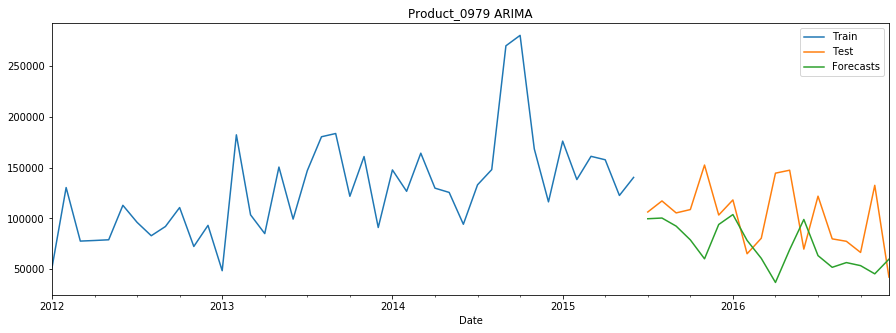

MAPE:  33.030361567543395 MPE:  21.461595614832685 RMSE:  48407.805678210476


In [ ]:
# Preview
product_DBSCAN_ARIMA_dict = {}
arima_func("Product_0979", df1_combined_monthly_DBSCAN[["Product_0979"]], product_DBSCAN_ARIMA_dict)

plt.figure(figsize=(15,5))
plt.title("Product_0979 ARIMA")
df1_combined_monthly_train["Product_0979"].plot(label="Train")
df1_combined_monthly_test["Product_0979"].plot(label="Test")
product_DBSCAN_ARIMA_dict["Product_0979"]["forecasts"][:-1].plot(label="Forecasts") # The last datapoint is not counted as it's the forecast outside the test dataset
plt.legend()
plt.show()

print("MAPE: ", mean_absolute_percentage_error(df1_combined_monthly_test["Product_0979"], product_DBSCAN_ARIMA_dict["Product_0979"]["forecasts"][:-1]),
      "MPE: ", mean_percentage_error(df1_combined_monthly_test["Product_0979"], product_DBSCAN_ARIMA_dict["Product_0979"]["forecasts"][:-1]),
      "RMSE: ", root_mean_square_error(df1_combined_monthly_test["Product_0979"], product_DBSCAN_ARIMA_dict["Product_0979"]["forecasts"][:-1]))

In [ ]:
for product in significant_product_list:
  arima_func(product, df1_combined_monthly_DBSCAN[[product]], product_DBSCAN_ARIMA_dict)

# Sound Ding when done
import winsound
duration = 10000  # milliseconds
freq = 777  # Hz
winsound.Beep(freq, duration)

Product_2138 Model Order (3, 2, 3) could not be fitted


In [ ]:
forecast_errors_DBSCAN_ARIMA = pd.DataFrame(columns=["Product", "MAPE", "MPE", "RMSE"])
mape_list = []
mpe_list = []
rmse_list = []

for product in product_DBSCAN_ARIMA_dict:
  mape = mean_absolute_percentage_error(df1_combined_monthly_test[product],
                                        product_DBSCAN_ARIMA_dict[product]["forecasts"][:-1])
  mpe = mean_percentage_error(df1_combined_monthly_test[product],
                              product_DBSCAN_ARIMA_dict[product]["forecasts"][:-1])
  rmse = root_mean_square_error(df1_combined_monthly_test[product],
                                product_DBSCAN_ARIMA_dict[product]["forecasts"][:-1])
  
  mape_list.append(mape)
  mpe_list.append(mpe)
  rmse_list.append(rmse)

forecast_errors_DBSCAN_ARIMA["Product"] = significant_product_list
forecast_errors_DBSCAN_ARIMA["MAPE"] = mape_list
forecast_errors_DBSCAN_ARIMA["MPE"] = mpe_list
forecast_errors_DBSCAN_ARIMA["RMSE"] = rmse_list

forecast_errors_DBSCAN_ARIMA.head()

,Product,MAPE,MPE,RMSE
0,Product_0979,33.030362,21.461596,48407.805678
1,Product_1938,42.797992,-15.952487,36.359453
2,Product_1451,29.538388,-7.238508,428605.151219
3,Product_1274,25.935932,13.788576,397572.570918
4,Product_1512,40.268878,36.953437,99514.427077


#### SARIMA

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

def sarima_func(product, dataframe, return_dict):
    
    # Assign the endogenous model
    endog = dataframe

    # Setup forecasts
    nforecasts = 1
    forecasts = {}

    # Get the number of initial training observations
    train_percentage = 0.7
    nobs = len(endog)
    n_init_training = int(nobs * train_percentage)

    # Dictionary of model order to the fitted model and its corresponding statistics
    SARIMA_model_dict = {}
    aic = 99999999
    
    # Create model for initial training sample, fit parameters
    training_endog = endog.iloc[:n_init_training]
    for p in range(0,2):
      for d in range(0,2):
        for q in range(0,2):
          for P in range(0,2):
            for D in range(0,2):
              for Q in range(0,2):
                try:             
                  mod = SARIMAX(training_endog, order=(p,d,q), seasonal_order=(P,D,Q,12))
                  res = mod.fit()

                  if res.aic < aic:
                      aic = res.aic

                      SARIMA_model_dict["Model_Order"] = ((p,d,q),(P,D,Q))
                      SARIMA_model_dict["train_AIC"] = aic
                      SARIMA_model_dict["train_fittedvalues"] = res.fittedvalues

                      # Initial forecast and prediction interval DataFrame
                      df_forecast = res.get_forecast(steps=1).predicted_mean
                      df_prediction_interval = res.get_forecast(steps=1).conf_int(alpha=0.05)

                      # Iterate through the rest of the sample
                      for t in range(n_init_training, nobs):
                          # Update the results by appending the next observation
                          updated_endog = endog.iloc[t:t+1]
                          res = res.append(updated_endog, refit=False)

                          # Save the new set of forecasts and prediction intervals
                          forecast_object = res.get_forecast(1)
                          df_forecast = df_forecast.append(forecast_object.predicted_mean)
                          df_prediction_interval = df_prediction_interval.append(forecast_object.conf_int(alpha=0.05))

                      SARIMA_model_dict["forecasts"] = df_forecast
                      SARIMA_model_dict["prediction_intervals"] = df_prediction_interval

                except:
                  None

    return_dict[product] = SARIMA_model_dict

    return

In [ ]:
product_DBSCAN_SARIMA_dict = {}
for product in significant_product_list:
  sarima_func(product, df1_combined_monthly_DBSCAN[[product]], product_DBSCAN_SARIMA_dict)

# Sound Ding when done
import winsound
duration = 10000  # milliseconds
freq = 777  # Hz
winsound.Beep(freq, duration)

In [ ]:
forecast_errors_DBSCAN_SARIMA = pd.DataFrame(columns=["Product", "MAPE", "MPE", "RMSE"])
mape_list = []
mpe_list = []
rmse_list = []

for product in product_DBSCAN_SARIMA_dict:
  mape = mean_absolute_percentage_error(df1_combined_monthly_test[product],
                                        product_DBSCAN_SARIMA_dict[product]["forecasts"][:-1])
  mpe = mean_percentage_error(df1_combined_monthly_test[product],
                              product_DBSCAN_SARIMA_dict[product]["forecasts"][:-1])
  rmse = root_mean_square_error(df1_combined_monthly_test[product],
                                product_DBSCAN_SARIMA_dict[product]["forecasts"][:-1])
  
  mape_list.append(mape)
  mpe_list.append(mpe)
  rmse_list.append(rmse)

forecast_errors_DBSCAN_SARIMA["Product"] = significant_product_list
forecast_errors_DBSCAN_SARIMA["MAPE"] = mape_list
forecast_errors_DBSCAN_SARIMA["MPE"] = mpe_list
forecast_errors_DBSCAN_SARIMA["RMSE"] = rmse_list

forecast_errors_DBSCAN_SARIMA.head()

,Product,MAPE,MPE,RMSE
0,Product_0979,29.978162,15.497286,46718.028288
1,Product_1938,53.589373,-19.236892,42.665837
2,Product_1451,34.132627,-7.655520,483007.451741
3,Product_1274,24.564581,12.357153,380916.906406
4,Product_1512,39.657313,37.315375,96242.639484


In [ ]:
forecast_errors_DBSCAN_SARIMA.MAPE.mean()

204.29322810181264

#### VAR

In [ ]:
import time
import multiprocessing
from multiprocessing import Process, Queue, Manager
from statsmodels.tsa.statespace.varmax import VARMAX

import varma_func

batch_size = len(significant_product_list)/4
batched_lists = []
for i in range(0,4):
  batched_lists.append(significant_product_list[int(i*batch_size):int((i+1)*batch_size)])

product_DBSCAN_VAR_dict = {}

for batched_list in batched_lists:
  dataframes_list = []
  for product in batched_list:  
    dataframes_list.append((product, df1_combined_monthly_DBSCAN[[product] + predictors_dict[product]].astype("float")))

  if __name__ == '__main__':
      manager = multiprocessing.Manager()
      return_dict = manager.dict()

      starttime = time.time()
      processes = []

      for product, dataframe in dataframes_list:
          p = Process(target=varma_func.var_func, args=(product, dataframe, return_dict))
          processes.append(p)
          p.start()
          
      for process in processes:
          process.join()
      
      print('Batch processed. Time elapsed: {} seconds'.format(time.time() - starttime))

  for product in return_dict:
    product_DBSCAN_VAR_dict[product] = return_dict[product]

# Sound Checkpoint
import winsound
duration = 10000  # milliseconds
freq = 777  # Hz
winsound.Beep(freq, duration)

Batch processed. Time elapsed: 2690.3845851421356 seconds
Batch processed. Time elapsed: 2658.0740609169006 seconds
Batch processed. Time elapsed: 2781.760537624359 seconds
Batch processed. Time elapsed: 2898.0198335647583 seconds


In [ ]:
forecast_errors_DBSCAN_VAR = pd.DataFrame(columns=["Product", "MAPE", "MPE", "RMSE"])
mape_list = []
mpe_list = []
rmse_list = []

for product in product_DBSCAN_VAR_dict:
  mape = mean_absolute_percentage_error(df1_combined_monthly_test[product],
                                        product_DBSCAN_VAR_dict[product]["forecasts"][product][:-1])
  mpe = mean_percentage_error(df1_combined_monthly_test[product],
                              product_DBSCAN_VAR_dict[product]["forecasts"][product][:-1])
  rmse = root_mean_square_error(df1_combined_monthly_test[product],
                                product_DBSCAN_VAR_dict[product]["forecasts"][product][:-1])
  
  mape_list.append(mape)
  mpe_list.append(mpe)
  rmse_list.append(rmse)

forecast_errors_DBSCAN_VAR["Product"] = significant_product_list
forecast_errors_DBSCAN_VAR["MAPE"] = mape_list
forecast_errors_DBSCAN_VAR["MPE"] = mpe_list
forecast_errors_DBSCAN_VAR["RMSE"] = rmse_list

forecast_errors_DBSCAN_VAR.head()

,Product,MAPE,MPE,RMSE
0,Product_0979,32.108601,29.790369,2.281075e+04
1,Product_1938,37.818106,0.698511,3.593996e+04
2,Product_1451,23.473440,9.983932,1.418792e+06
3,Product_1274,20.936005,2.516491,3.271498e+05
4,Product_1512,43.764745,42.517530,9.848991e+04


In [ ]:
forecast_errors_DBSCAN_VAR.MAPE.mean()

55.41519031174617

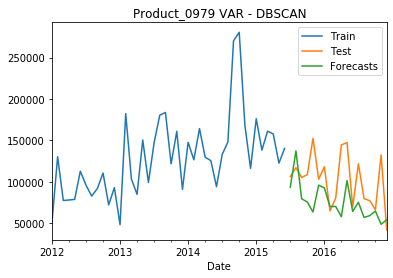

MAPE:  26.34460923139202 MPE:  20.305737136808727 RMSE:  41401.314577249315


In [ ]:
# Preview

plt.figure()
plt.title("Product_0979 VAR - DBSCAN")
df1_combined_monthly_train["Product_0979"].plot(label="Train")
df1_combined_monthly_test["Product_0979"].plot(label="Test")
product_DBSCAN_VAR_dict["Product_0979"]["forecasts"]["Product_0979"][:-1].plot(label="Forecasts") # The last datapoint is not counted as it's the forecast outside the test dataset
plt.legend()
plt.savefig('C:\\Users\\renal\\Documents\\HEC Supervised Project\\VAR_DBSCAN.jpg')
plt.show()

print("MAPE: ", mean_absolute_percentage_error(df1_combined_monthly_test["Product_0979"], product_DBSCAN_VAR_dict["Product_0979"]["forecasts"]["Product_0979"][:-1]),
      "MPE: ", mean_percentage_error(df1_combined_monthly_test["Product_0979"], product_DBSCAN_VAR_dict["Product_0979"]["forecasts"]["Product_0979"][:-1]),
      "RMSE: ", root_mean_square_error(df1_combined_monthly_test["Product_0979"], product_DBSCAN_VAR_dict["Product_0979"]["forecasts"]["Product_0979"][:-1]))

#### VMA

In [ ]:
import time
import multiprocessing
from multiprocessing import Process, Queue, Manager
from statsmodels.tsa.statespace.varmax import VARMAX

import varma_func

batch_size = len(significant_product_list)/4
batched_lists = []
for i in range(0,4):
  batched_lists.append(significant_product_list[int(i*batch_size):int((i+1)*batch_size)])

product_DBSCAN_VMA_dict = {}

for batched_list in batched_lists:
  dataframes_list = []
  for product in batched_list:  
    dataframes_list.append((product, df1_combined_monthly_DBSCAN[[product] + predictors_dict[product]].astype("float")))

  if __name__ == '__main__':
      manager = multiprocessing.Manager()
      return_dict = manager.dict()

      starttime = time.time()
      processes = []

      for product, dataframe in dataframes_list:
          p = Process(target=varma_func.vma_func, args=(product, dataframe, return_dict))
          processes.append(p)
          p.start()
          
      for process in processes:
          process.join()
      
      print('That took {} seconds'.format(time.time() - starttime))

  for product in return_dict:
    product_DBSCAN_VMA_dict[product] = return_dict[product]

# Sound Checkpoint
import winsound
duration = 10000  # milliseconds
freq = 777  # Hz
winsound.Beep(freq, duration)

That took 2365.5467877388 seconds
That took 2160.446704387665 seconds
That took 2199.816385269165 seconds
That took 2259.573164701462 seconds


In [ ]:
forecast_errors_DBSCAN_VMA = pd.DataFrame(columns=["Product", "MAPE", "MPE", "RMSE"])
mape_list = []
mpe_list = []
rmse_list = []

for product in product_DBSCAN_VMA_dict:
  mape = mean_absolute_percentage_error(df1_combined_monthly_test[product],
                                        product_DBSCAN_VMA_dict[product]["forecasts"][product][:-1])
  mpe = mean_percentage_error(df1_combined_monthly_test[product],
                              product_DBSCAN_VMA_dict[product]["forecasts"][product][:-1])
  rmse = root_mean_square_error(df1_combined_monthly_test[product],
                                product_DBSCAN_VMA_dict[product]["forecasts"][product][:-1])
  
  mape_list.append(mape)
  mpe_list.append(mpe)
  rmse_list.append(rmse)

forecast_errors_DBSCAN_VMA["Product"] = significant_product_list
forecast_errors_DBSCAN_VMA["MAPE"] = mape_list
forecast_errors_DBSCAN_VMA["MPE"] = mpe_list
forecast_errors_DBSCAN_VMA["RMSE"] = rmse_list

forecast_errors_DBSCAN_VMA.head()

,Product,MAPE,MPE,RMSE
0,Product_0979,33.797270,16.865921,79538.017599
1,Product_1938,20.075795,4.271752,320702.765294
2,Product_1451,49.559857,39.872066,36649.732381
3,Product_1274,38.801800,-0.023891,36139.720206
4,Product_1512,27.516529,23.239709,42171.220383


In [ ]:
forecast_errors_DBSCAN_VMA.MAPE.mean()

70.84892528272474

#### VARMA

In [ ]:
import time
import multiprocessing
from multiprocessing import Process, Queue, Manager
from statsmodels.tsa.statespace.varmax import VARMAX

import varma_func

batch_size = len(significant_product_list)/4
batched_lists = []
for i in range(0,4):
  batched_lists.append(significant_product_list[int(i*batch_size):int((i+1)*batch_size)])

product_DBSCAN_VARMA_dict = {}

for batched_list in batched_lists:
  dataframes_list = []
  for product in batched_list:  
    dataframes_list.append((product, df1_combined_monthly_DBSCAN[[product] + predictors_dict[product]].astype("float")))

  if __name__ == '__main__':
      manager = multiprocessing.Manager()
      return_dict = manager.dict()

      starttime = time.time()
      processes = []

      for product, dataframe in dataframes_list:
          p = Process(target=varma_func.varma_func, args=(product, dataframe, return_dict))
          processes.append(p)
          p.start()
          
      for process in processes:
          process.join()
      
      print('That took {} seconds'.format(time.time() - starttime))

  for product in return_dict:
    product_DBSCAN_VARMA_dict[product] = return_dict[product]

# Sound Checkpoint
import winsound
duration = 10000  # milliseconds
freq = 777  # Hz
winsound.Beep(freq, duration)

That took 698.2082705497742 seconds
That took 708.9279699325562 seconds
That took 642.8343534469604 seconds
That took 742.1045830249786 seconds


In [ ]:
forecast_errors_DBSCAN_VARMA = pd.DataFrame(columns=["Product", "MAPE", "MPE", "RMSE"])
mape_list = []
mpe_list = []
rmse_list = []

for product in product_DBSCAN_VARMA_dict:
  mape = mean_absolute_percentage_error(df1_combined_monthly_test[product],
                                        product_DBSCAN_VARMA_dict[product]["forecasts"][product][:-1])
  mpe = mean_percentage_error(df1_combined_monthly_test[product],
                              product_DBSCAN_VARMA_dict[product]["forecasts"][product][:-1])
  rmse = root_mean_square_error(df1_combined_monthly_test[product],
                                product_DBSCAN_VARMA_dict[product]["forecasts"][product][:-1])
  
  mape_list.append(mape)
  mpe_list.append(mpe)
  rmse_list.append(rmse)

forecast_errors_DBSCAN_VARMA["Product"] = significant_product_list
forecast_errors_DBSCAN_VARMA["MAPE"] = mape_list
forecast_errors_DBSCAN_VARMA["MPE"] = mpe_list
forecast_errors_DBSCAN_VARMA["RMSE"] = rmse_list

forecast_errors_DBSCAN_VARMA.head()

,Product,MAPE,MPE,RMSE
0,Product_0979,26.078923,1.069996,714184.646917
1,Product_1938,11.763282,-1.936769,204875.501525
2,Product_1451,40.424103,39.889897,95564.493540
3,Product_1274,53.642318,-15.298071,45.230691
4,Product_1512,34.984983,-1.679598,49.172437


In [ ]:
forecast_errors_DBSCAN_VARMA.MAPE.mean()

75.08476055145086

#### Pickle

In [ ]:
import pickle

# Function of the code below is to save the dictionary/dataframes above
variables_list = [products_dataframe_DBSCAN, monthly_data_gaussian,
                  product_DBSCAN_ARIMA_dict, forecast_errors_DBSCAN_ARIMA,
                  product_DBSCAN_SARIMA_dict, forecast_errors_DBSCAN_SARIMA,
                  product_DBSCAN_VAR_dict, forecast_errors_DBSCAN_VAR,
                  product_DBSCAN_VMA_dict, forecast_errors_DBSCAN_VMA,
                  product_DBSCAN_VARMA_dict, forecast_errors_DBSCAN_VARMA]

with open('C:\\Users\\renal\\Documents\\HEC Supervised Project\\workflow2_DBSCAN.pkl', 'wb') as f:
    pickle.dump(variables_list, f)

## Analysis

### Forecasting Methods

#### MAPE

In [ ]:
# Check how many percent of products MAPE improved from original (array1) in the new forecasts from anomaly detection (array2)
def improvement_percentage(array1, array2):
  array = (array2 < array1)
  return sum(array)/len(array)

In [ ]:
original_MAPES = [forecast_errors_simple_avg.MAPE,
                  forecast_errors_moving_average.MAPE,
                  forecast_errors_expsmoothing.MAPE,
                  forecast_errors_Holt.MAPE,
                  forecast_errors_HoltWinters.MAPE,
                  forecast_errors_ARIMA.MAPE,
                  forecast_errors_SARIMA.MAPE,
                  forecast_errors_VAR.MAPE,
                  forecast_errors_VMA.MAPE,
                  forecast_errors_VARMA.MAPE]

isoforest_MAPES = [forecast_errors_isoforest_simple_avg.MAPE,
                  forecast_errors_isoforest_moving_average.MAPE,
                  forecast_errors_isoforest_expsmoothing.MAPE,
                  forecast_errors_isoforest_Holt.MAPE,
                  forecast_errors_isoforest_HoltWinters.MAPE,
                  forecast_errors_isoforest_ARIMA.MAPE,
                  forecast_errors_isoforest_SARIMA.MAPE,
                  forecast_errors_isoforest_VAR.MAPE,
                  forecast_errors_isoforest_VMA.MAPE,
                  forecast_errors_isoforest_VARMA.MAPE]

gaussian_MAPES = [forecast_errors_gaussian_simple_avg.MAPE,
                  forecast_errors_gaussian_moving_average.MAPE,
                  forecast_errors_gaussian_expsmoothing.MAPE,
                  forecast_errors_gaussian_Holt.MAPE,
                  forecast_errors_gaussian_HoltWinters.MAPE,
                  forecast_errors_gaussian_ARIMA.MAPE,
                  forecast_errors_gaussian_SARIMA.MAPE,
                  forecast_errors_gaussian_VAR.MAPE,
                  forecast_errors_gaussian_VMA.MAPE,
                  forecast_errors_gaussian_VARMA.MAPE]                              

DBSCAN_MAPES = [forecast_errors_DBSCAN_simple_avg.MAPE,
                forecast_errors_DBSCAN_moving_average.MAPE,
                forecast_errors_DBSCAN_expsmoothing.MAPE,
                forecast_errors_DBSCAN_Holt.MAPE,
                forecast_errors_DBSCAN_HoltWinters.MAPE,
                forecast_errors_DBSCAN_ARIMA.MAPE,
                forecast_errors_DBSCAN_SARIMA.MAPE,
                forecast_errors_DBSCAN_VAR.MAPE,
                forecast_errors_DBSCAN_VMA.MAPE,
                forecast_errors_DBSCAN_VARMA.MAPE]  

NameError: ignored

In [ ]:
# The function of the code below is to measure the Coefficient of Variation (CV) of each product dataset

from scipy.stats import variation  
CV_dataframe = pd.DataFrame()
CV_dataframe["Product"] = significant_product_list

CV_list = []
for product in significant_product_list:
  # Calculate CV of the monthly demand
  CV_list.append(variation(products_dataframe_monthly[product], axis=0)[0])

CV_dataframe["CV"] = CV_list
CV_dataframe = CV_dataframe.sort_values(by="CV").reset_index(drop=True)

# Insert the MAPE from each method
CV_dataframe["SA"] = [forecast_errors_simple_avg.loc[forecast_errors_simple_avg["Product"] == product, "MAPE"].values[0] for product in CV_dataframe.Product]
CV_dataframe["MA"] = [forecast_errors_moving_average.loc[forecast_errors_moving_average["Product"] == product, "MAPE"].values[0] for product in CV_dataframe.Product]
CV_dataframe["SES"] = [forecast_errors_expsmoothing.loc[forecast_errors_expsmoothing["Product"] == product, "MAPE"].values[0] for product in CV_dataframe.Product]
CV_dataframe["Holt"] = [forecast_errors_Holt.loc[forecast_errors_Holt["Product"] == product, "MAPE"].values[0] for product in CV_dataframe.Product]
CV_dataframe["HW"] = [forecast_errors_HoltWinters.loc[forecast_errors_HoltWinters["Product"] == product, "MAPE"].values[0] for product in CV_dataframe.Product]
CV_dataframe["ARIMA"] = [forecast_errors_ARIMA.loc[forecast_errors_ARIMA["Product"] == product, "MAPE"].values[0] for product in CV_dataframe.Product]
CV_dataframe["SARIMA"] = [forecast_errors_SARIMA.loc[forecast_errors_SARIMA["Product"] == product, "MAPE"].values[0] for product in CV_dataframe.Product]
CV_dataframe["VAR"] = [forecast_errors_VAR.loc[forecast_errors_VAR["Product"] == product, "MAPE"].values[0] for product in CV_dataframe.Product]
CV_dataframe["VMA"] = [forecast_errors_VMA.loc[forecast_errors_VMA["Product"] == product, "MAPE"].values[0] for product in CV_dataframe.Product]
CV_dataframe["VARMA"] = [forecast_errors_VARMA.loc[forecast_errors_VARMA["Product"] == product, "MAPE"].values[0] for product in CV_dataframe.Product]

CV_dataframe.head()

,Product,CV,SA,MA,SES,Holt,HW,ARIMA,SARIMA,VAR,VMA,VARMA
0,Product_1377,0.134680,12.332474,16.102948,15.871809,18.056807,15.972307,18.277571,19.344662,65.976853,63.215785,19.245315
1,Product_1382,0.178255,15.472760,17.797666,17.587279,22.108098,18.600346,20.361829,22.404243,32.979676,19.962033,28.366386
2,Product_1294,0.179483,14.878593,21.131360,19.061266,24.258151,16.720117,25.177254,20.477093,35.642769,43.710394,43.304494
3,Product_1360,0.181218,18.806442,23.459033,20.727469,29.006647,16.527708,25.244336,20.104417,47.351578,27.386805,29.421723
4,Product_1378,0.182923,15.457732,19.338150,18.339430,19.802132,17.227615,21.356810,22.802030,57.200100,18.109566,14.219405


In [ ]:
import statistics

df1 = CV_dataframe.loc[CV_dataframe["CV"] < 0.25]
demand_list = []
ordercount_list = []
for product in df1.Product:
  df2 = products_dataframe[product]
  demand_list.append(list(df2.Order_Demand.values))
  order_count = len(df2)
  ordercount_list.append(order_count)

demand_list = demand_list[0]
sum(demand_list)/len(demand_list)
sum(ordercount_list)/len(ordercount_list)

zero_order_counter = 0
for order in demand_list:
  if order == 0:
    zero_order_counter += 1

print(zero_order_counter/len(demand_list))


print("CV: < 0.25", "\n",
      "Product Count:", len(df1), "\n",
      "Average Demand:", sum(demand_list)/len(demand_list), "\n",
      "Min:", min(demand_list), "\n",
      "Max:", max(demand_list), "\n",
      "Stdev:", np.std(demand_list), "\n",
      "Average Total Orders", sum(ordercount_list)/len(ordercount_list))

0.012195121951219513
CV: < 0.25 
 Product Count: 21 
 Average Demand: 7154.801829268293 
 Min: 0.0 
 Max: 200000.0 
 Stdev: 10130.155 
 Average Total Orders 6701.428571428572


In [ ]:
import statistics

df1 = CV_dataframe.loc[(CV_dataframe["CV"] > 0.25) & (CV_dataframe["CV"] <= 0.5)]
demand_list = []
ordercount_list = []
for product in df1.Product:
  df2 = products_dataframe[product]
  demand_list.append(list(df2.Order_Demand.values))
  order_count = len(df2)
  ordercount_list.append(order_count)

demand_list = demand_list[0]
sum(demand_list)/len(demand_list)
sum(ordercount_list)/len(ordercount_list)

zero_order_counter = 0
for order in demand_list:
  if order == 0:
    zero_order_counter += 1

print(zero_order_counter/len(demand_list))

print("CV: < 0.5", "\n",
      "Product Count:", len(df1), "\n",
      "Average Demand:", sum(demand_list)/len(demand_list), "\n",
      "Min:", min(demand_list), "\n",
      "Max:", max(demand_list), "\n",
      "Stdev:", np.std(demand_list), "\n",
      "Average Total Orders", sum(ordercount_list)/len(ordercount_list))

0.0010240655401945725
CV: < 0.5 
 Product Count: 135 
 Average Demand: 19637.224782386074 
 Min: 0.0 
 Max: 769000.0 
 Stdev: 41710.11 
 Average Total Orders 2297.82962962963


In [ ]:
import statistics

df1 = CV_dataframe.loc[(CV_dataframe["CV"] > 0.5) & (CV_dataframe["CV"] <= 0.75)]
demand_list = []
ordercount_list = []
for product in df1.Product:
  df2 = products_dataframe[product]
  demand_list.append(list(df2.Order_Demand.values))
  order_count = len(df2)
  ordercount_list.append(order_count)

demand_list = demand_list[0]
sum(demand_list)/len(demand_list)
sum(ordercount_list)/len(ordercount_list)

zero_order_counter = 0
for order in demand_list:
  if order == 0:
    zero_order_counter += 1

print(zero_order_counter/len(demand_list))

print("CV: < 0.75", "\n",
      "Product Count:", len(df1), "\n",
      "Average Demand:", sum(demand_list)/len(demand_list), "\n",
      "Min:", min(demand_list), "\n",
      "Max:", max(demand_list), "\n",
      "Stdev:", np.std(demand_list), "\n",
      "Average Total Orders", sum(ordercount_list)/len(ordercount_list))

0.0036923076923076922
CV: < 0.75 
 Product Count: 70 
 Average Demand: 623.2615384615384 
 Min: 0.0 
 Max: 20000.0 
 Stdev: 1427.5402 
 Average Total Orders 1558.4142857142858


In [ ]:
import statistics

df1 = CV_dataframe.loc[(CV_dataframe["CV"] > 0.75) & (CV_dataframe["CV"] <= 1)]
demand_list = []
ordercount_list = []
zeroorder_proportion = []
for product in df1.Product:
  df2 = products_dataframe[product]
  demand_list.append(list(df2.Order_Demand.values))
  order_count = len(df2)
  ordercount_list.append(order_count)

demand_list = demand_list[0]
sum(demand_list)/len(demand_list)
sum(ordercount_list)/len(ordercount_list)

zero_order_counter = 0
for order in demand_list:
  if order == 0:
    zero_order_counter += 1

print(zero_order_counter/len(demand_list))

print("CV: < 1", "\n",
      "Product Count:", len(df1), "\n",
      "Average Demand:", sum(demand_list)/len(demand_list), "\n",
      "Min:", min(demand_list), "\n",
      "Max:", max(demand_list), "\n",
      "Stdev:", np.std(demand_list), "\n",
      "Average Total Orders", sum(ordercount_list)/len(ordercount_list))

0.015037593984962405
CV: < 1 
 Product Count: 12 
 Average Demand: 165.47274436090225 
 Min: 0.0 
 Max: 4894.0 
 Stdev: 355.07947 
 Average Total Orders 1144.3333333333333


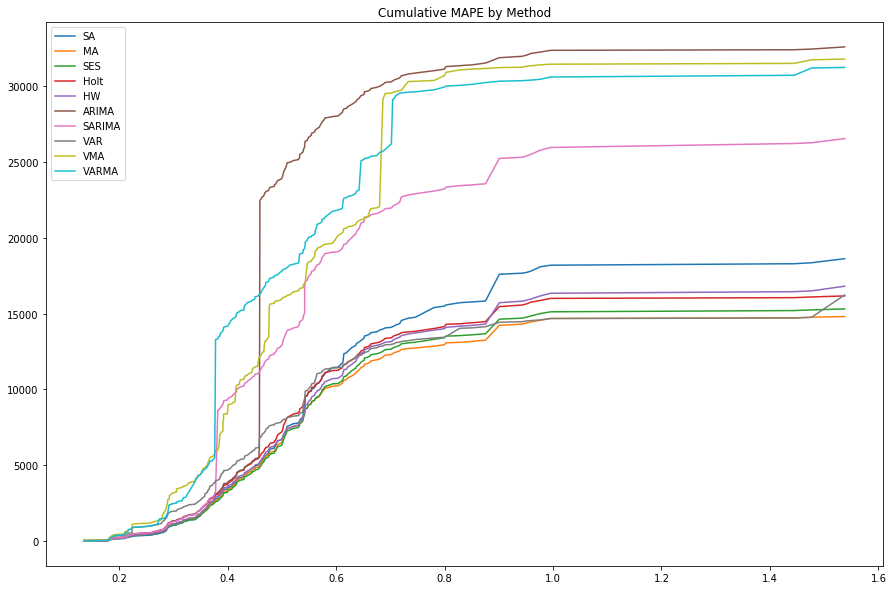

In [ ]:
# Plotting the cumulative MAPE by product CV

plt.figure(figsize=(15,10))
plt.title("Cumulative MAPE by Method")

for method in CV_dataframe.columns[2:]:
  cumulative_MAPE = []
  cumulative_MAPE.append(CV_dataframe.loc[0,method])
  for i in range(1,len(CV_dataframe)):
    cumulative_MAPE.append(cumulative_MAPE[i-1]+CV_dataframe.loc[i,method])
  plt.plot(CV_dataframe.CV, cumulative_MAPE, label=method)

plt.legend()
plt.show()

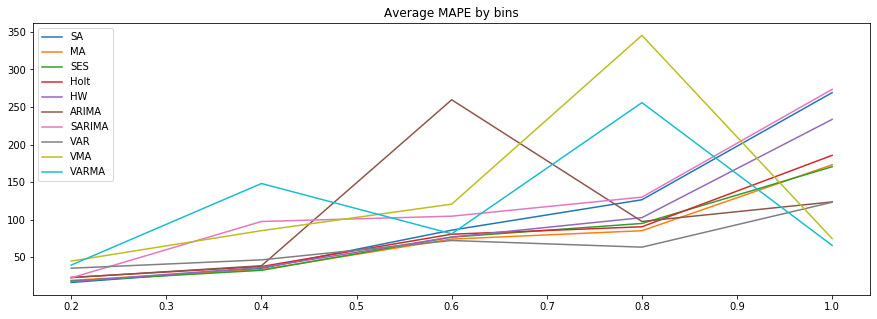

In [ ]:
# Plotting the MAPE in increments 

plt.figure(figsize=(15,5))
plt.title("Average MAPE by bins")

bins = 5
for method in CV_dataframe.columns[2:]:
  x = []
  y = []

  for i in range(bins):
    df1 = CV_dataframe.loc[(CV_dataframe["CV"]>=i/bins) & (CV_dataframe["CV"]<=(i+1)/bins)]
    x.append((i+1)/bins)
    y.append(df1[method].mean())

  plt.plot(x, y, label=method)

plt.legend()
plt.show()

In [ ]:
# This returns the MAPE ranking based on range of CV

bins_list = []
ranking_list = []

bins = 1
for i in range(bins):
  methods = []
  MAPE_list = []
  df1 = CV_dataframe.loc[(CV_dataframe["CV"]>=i/bins) & (CV_dataframe["CV"]<=(i+1)/bins)]

  method_MAPE = pd.DataFrame()
  for method in CV_dataframe.columns[2:]:
    methods.append(method)
    MAPE_list.append(df1[method].mean())
  method_MAPE["Method"] = methods
  method_MAPE["MAPES"] = MAPE_list
  method_MAPE.sort_values(by="MAPES", inplace=True)
  method_ranking = method_MAPE.Method.tolist()

  bins_list.append((i+1)/bins)
  ranking_list.append(method_ranking)

MAPE_ranking = pd.DataFrame()

for i,j in zip(bins_list,ranking_list):
  MAPE_ranking[str(i-1/bins)+"-"+str(i)] = j

MAPE_ranking

,0.0-1.0
0,VAR
1,MA
2,SES
3,Holt
4,HW
5,SA
6,SARIMA
7,VARMA
8,VMA
9,ARIMA


#### MPE

In [ ]:
MPE_comparison = pd.DataFrame()
MPE_comparison["Methods"] = ["SA", "MA", "SES", "Holt", "HW", "ARIMA", "SARIMA", "VAR", "VMA", "VARMA"]
MPE_comparison["MPE_original"] = [forecast_errors_simple_avg.MPE.mean(),
                                    forecast_errors_moving_average.MPE.mean(),
                                    forecast_errors_expsmoothing.MPE.mean(),
                                    forecast_errors_Holt.MPE.mean(),
                                    forecast_errors_HoltWinters.MPE.mean(),
                                    forecast_errors_ARIMA.MPE.mean(),
                                    forecast_errors_SARIMA.MPE.mean(),
                                    forecast_errors_VAR.MPE.mean(),
                                    forecast_errors_VMA.MPE.mean(),
                                    forecast_errors_VARMA.MPE.mean()]

MPE_comparison["iForest"] = [forecast_errors_isoforest_simple_avg.MPE.mean(),
                              forecast_errors_isoforest_moving_average.MPE.mean(),
                              forecast_errors_isoforest_expsmoothing.MPE.mean(),
                              forecast_errors_isoforest_Holt.MPE.mean(),
                              forecast_errors_isoforest_HoltWinters.MPE.mean(),
                              forecast_errors_isoforest_ARIMA.MPE.mean(),
                              forecast_errors_isoforest_SARIMA.MPE.mean(),
                              forecast_errors_isoforest_VAR.MPE.mean(),
                              forecast_errors_isoforest_VMA.MPE.mean(),
                              forecast_errors_isoforest_VARMA.MPE.mean()]

MPE_comparison["Gaussian"] = [forecast_errors_gaussian_simple_avg.MPE.mean(),
                              forecast_errors_gaussian_moving_average.MPE.mean(),
                              forecast_errors_gaussian_expsmoothing.MPE.mean(),
                              forecast_errors_gaussian_Holt.MPE.mean(),
                              forecast_errors_gaussian_HoltWinters.MPE.mean(),
                              forecast_errors_gaussian_ARIMA.MPE.mean(),
                              forecast_errors_gaussian_SARIMA.MPE.mean(),
                              forecast_errors_gaussian_VAR.MPE.mean(),
                              forecast_errors_gaussian_VMA.MPE.mean(),
                              forecast_errors_gaussian_VARMA.MPE.mean()]                              

MPE_comparison["DBSCAN"] = [forecast_errors_DBSCAN_simple_avg.MPE.mean(),
                            forecast_errors_DBSCAN_moving_average.MPE.mean(),
                            forecast_errors_DBSCAN_expsmoothing.MPE.mean(),
                            forecast_errors_DBSCAN_Holt.MPE.mean(),
                            forecast_errors_DBSCAN_HoltWinters.MPE.mean(),
                            forecast_errors_DBSCAN_ARIMA.MPE.mean(),
                            forecast_errors_DBSCAN_SARIMA.MPE.mean(),
                            forecast_errors_DBSCAN_VAR.MPE.mean(),
                            forecast_errors_DBSCAN_VMA.MPE.mean(),
                            forecast_errors_DBSCAN_VARMA.MPE.mean()]      

print("Comparing average MPE with and without anomaly detection:")
MPE_comparison                                                    

Comparing average MPE with and without anomaly detection:


,Methods,MPE_original,iForest,Gaussian,DBSCAN
0,SA,-54.348062,-30.332779,-31.661079,-10.212078
1,MA,-38.394287,-27.095924,-30.683610,-35.814408
2,SES,-44.652846,-9.803224,-20.840806,-2.328855
3,Holt,-39.480798,-2.415086,-15.440429,1.657461
4,HW,-45.419285,-9.481954,-21.747151,-2.855914
5,ARIMA,-102.964369,-41.681734,-16.511791,-157.622120
6,SARIMA,-19.168621,-33.518056,-58.508855,142.937591
7,VAR,-23.303532,-18.176561,-22.880194,3.490081
8,VMA,7.217435,-25.494416,-27.964717,2.529491
9,VARMA,20.697496,-28.779433,-50.093675,-2.946714


In [ ]:
# The function of the code below is to measure the Coefficient of Variation (CV) of each product dataset

from scipy.stats import variation  
CV_dataframe = pd.DataFrame()
CV_dataframe["Product"] = significant_product_list

CV_list = []
for product in significant_product_list:
  # Calculate CV of the monthly demand
  CV_list.append(variation(products_dataframe_monthly[product], axis=0)[0])

CV_dataframe["CV"] = CV_list
CV_dataframe = CV_dataframe.sort_values(by="CV").reset_index(drop=True)

# Insert the MPE from each method
CV_dataframe["SA"] = [forecast_errors_simple_avg.loc[forecast_errors_simple_avg["Product"] == product, "MPE"].values[0] for product in CV_dataframe.Product]
CV_dataframe["MA"] = [forecast_errors_moving_average.loc[forecast_errors_moving_average["Product"] == product, "MPE"].values[0] for product in CV_dataframe.Product]
CV_dataframe["SES"] = [forecast_errors_expsmoothing.loc[forecast_errors_expsmoothing["Product"] == product, "MPE"].values[0] for product in CV_dataframe.Product]
CV_dataframe["Holt"] = [forecast_errors_Holt.loc[forecast_errors_Holt["Product"] == product, "MPE"].values[0] for product in CV_dataframe.Product]
CV_dataframe["HW"] = [forecast_errors_HoltWinters.loc[forecast_errors_HoltWinters["Product"] == product, "MPE"].values[0] for product in CV_dataframe.Product]
CV_dataframe["ARIMA"] = [forecast_errors_ARIMA.loc[forecast_errors_ARIMA["Product"] == product, "MPE"].values[0] for product in CV_dataframe.Product]
CV_dataframe["SARIMA"] = [forecast_errors_SARIMA.loc[forecast_errors_SARIMA["Product"] == product, "MPE"].values[0] for product in CV_dataframe.Product]
CV_dataframe["VAR"] = [forecast_errors_VAR.loc[forecast_errors_VAR["Product"] == product, "MPE"].values[0] for product in CV_dataframe.Product]
CV_dataframe["VMA"] = [forecast_errors_VMA.loc[forecast_errors_VMA["Product"] == product, "MPE"].values[0] for product in CV_dataframe.Product]
CV_dataframe["VARMA"] = [forecast_errors_VARMA.loc[forecast_errors_VARMA["Product"] == product, "MPE"].values[0] for product in CV_dataframe.Product]

CV_dataframe.head()

,Product,CV,SA,MA,SES,Holt,HW,ARIMA,SARIMA,VAR,VMA,VARMA
0,Product_1377,0.134680,-3.592034,-5.707382,-5.637522,-6.269228,-4.970729,-5.742527,-6.863030,-51.901905,-45.639482,4.790625
1,Product_1382,0.178255,9.492666,-4.221039,-4.139689,-5.315017,-9.960638,-4.485252,-6.856835,-17.848093,-4.264790,20.895680
2,Product_1294,0.179483,-3.666158,-5.993519,-5.790857,-6.736593,-6.157548,-6.636477,-6.347492,-7.973669,29.165198,-14.998966
3,Product_1360,0.181218,-0.386347,-6.842357,-6.626454,-7.454748,-7.333143,-5.797128,-8.386214,-31.966388,-10.689340,-16.736590
4,Product_1378,0.182923,6.088810,-4.972075,-4.871030,-3.946519,-9.261178,-5.084090,-7.476873,36.759282,-2.189196,0.378483


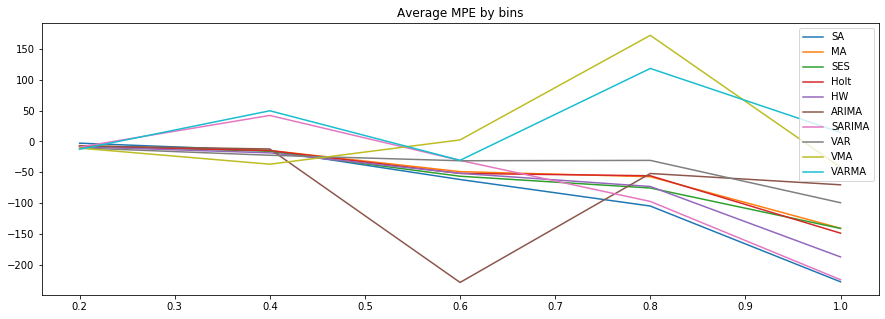

In [ ]:
# Plotting the MPE in increments 

plt.figure(figsize=(15,5))
plt.title("Average MPE by bins")

bins = 5
for method in CV_dataframe.columns[2:]:
  x = []
  y = []

  for i in range(bins):
    df1 = CV_dataframe.loc[(CV_dataframe["CV"]>=i/bins) & (CV_dataframe["CV"]<=(i+1)/bins)]
    x.append((i+1)/bins)
    y.append(df1[method].mean())

  plt.plot(x, y, label=method)

plt.legend()
plt.show()

### Anomaly Detection Methods

In [ ]:
MAPE_comparison = pd.DataFrame()
MAPE_comparison["Methods"] = ["SA", "MA", "SES", "Holt", "HW", "ARIMA", "SARIMA", "VAR", "VMA", "VARMA"]
MAPE_comparison["MAPE_original"] = [forecast_errors_simple_avg.MAPE.mean(),
                                    forecast_errors_moving_average.MAPE.mean(),
                                    forecast_errors_expsmoothing.MAPE.mean(),
                                    forecast_errors_Holt.MAPE.mean(),
                                    forecast_errors_HoltWinters.MAPE.mean(),
                                    forecast_errors_ARIMA.MAPE.mean(),
                                    forecast_errors_SARIMA.MAPE.mean(),
                                    forecast_errors_VAR.MAPE.mean(),
                                    forecast_errors_VMA.MAPE.mean(),
                                    forecast_errors_VARMA.MAPE.mean()]

MAPE_comparison["iForest"] = [forecast_errors_isoforest_simple_avg.MAPE.mean(),
                              forecast_errors_isoforest_moving_average.MAPE.mean(),
                              forecast_errors_isoforest_expsmoothing.MAPE.mean(),
                              forecast_errors_isoforest_Holt.MAPE.mean(),
                              forecast_errors_isoforest_HoltWinters.MAPE.mean(),
                              forecast_errors_isoforest_ARIMA.MAPE.mean(),
                              forecast_errors_isoforest_SARIMA.MAPE.mean(),
                              forecast_errors_isoforest_VAR.MAPE.mean(),
                              forecast_errors_isoforest_VMA.MAPE.mean(),
                              forecast_errors_isoforest_VARMA.MAPE.mean()]

MAPE_comparison["Gaussian"] = [forecast_errors_gaussian_simple_avg.MAPE.mean(),
                              forecast_errors_gaussian_moving_average.MAPE.mean(),
                              forecast_errors_gaussian_expsmoothing.MAPE.mean(),
                              forecast_errors_gaussian_Holt.MAPE.mean(),
                              forecast_errors_gaussian_HoltWinters.MAPE.mean(),
                              forecast_errors_gaussian_ARIMA.MAPE.mean(),
                              forecast_errors_gaussian_SARIMA.MAPE.mean(),
                              forecast_errors_gaussian_VAR.MAPE.mean(),
                              forecast_errors_gaussian_VMA.MAPE.mean(),
                              forecast_errors_gaussian_VARMA.MAPE.mean()]                              

MAPE_comparison["DBSCAN"] = [forecast_errors_DBSCAN_simple_avg.MAPE.mean(),
                            forecast_errors_DBSCAN_moving_average.MAPE.mean(),
                            forecast_errors_DBSCAN_expsmoothing.MAPE.mean(),
                            forecast_errors_DBSCAN_Holt.MAPE.mean(),
                            forecast_errors_DBSCAN_HoltWinters.MAPE.mean(),
                            forecast_errors_DBSCAN_ARIMA.MAPE.mean(),
                            forecast_errors_DBSCAN_SARIMA.MAPE.mean(),
                            forecast_errors_DBSCAN_VAR.MAPE.mean(),
                            forecast_errors_DBSCAN_VMA.MAPE.mean(),
                            forecast_errors_DBSCAN_VARMA.MAPE.mean()]      

print("Comparing MAPE with and without anomaly detection:")
MAPE_comparison                                                    

Comparing MAPE with and without anomaly detection:


,Methods,MAPE_original,iForest,Gaussian,DBSCAN
0,SA,77.227077,63.518289,64.333682,56.475154
1,MA,61.431375,48.583619,53.019821,59.826369
2,SES,63.507689,48.799116,51.583447,47.043998
3,Holt,67.054519,50.118479,53.948997,51.387642
4,HW,69.703205,51.743835,55.423576,51.699047
5,ARIMA,135.104622,91.573537,54.875104,213.870776
6,SARIMA,110.047868,126.422854,100.531018,204.293228
7,VAR,67.301996,55.927825,57.735931,55.415190
8,VMA,131.780172,79.850898,90.820698,70.848925
9,VARMA,129.497148,91.613732,98.440753,75.084761


In [ ]:
MAPE_comparison.to_excel('C:\\Users\\renal\\Documents\\HEC Supervised Project\\MAPE_comparison.xlsx')

In [ ]:
df1 = pd.DataFrame()
df1["Product"] = significant_product_list
df1["SA"] = forecast_errors_simple_avg.MAPE
df1["MA"] = forecast_errors_moving_average.MAPE
df1["SES"] = forecast_errors_expsmoothing.MAPE
df1["Holt"] = forecast_errors_Holt.MAPE
df1["HW"] = forecast_errors_HoltWinters.MAPE
df1["ARIMA"] = forecast_errors_ARIMA.MAPE
df1["SARIMA"] = forecast_errors_SARIMA.MAPE
df1["VAR"] = forecast_errors_VAR.MAPE
df1["VMA"] = forecast_errors_VMA.MAPE
df1["VARMA"] = forecast_errors_VARMA.MAPE

df2 = pd.DataFrame()
df2["Product"] = significant_product_list
df2["SA"] = forecast_errors_isoforest_simple_avg.MAPE
df2["MA"] = forecast_errors_isoforest_moving_average.MAPE
df2["SES"] = forecast_errors_isoforest_expsmoothing.MAPE
df2["Holt"] = forecast_errors_isoforest_Holt.MAPE
df2["HW"] = forecast_errors_isoforest_HoltWinters.MAPE
df2["ARIMA"] = forecast_errors_isoforest_ARIMA.MAPE
df2["SARIMA"] = forecast_errors_isoforest_SARIMA.MAPE
df2["VAR"] = forecast_errors_isoforest_VAR.MAPE
df2["VMA"] = forecast_errors_isoforest_VMA.MAPE
df2["VARMA"] = forecast_errors_isoforest_VARMA.MAPE

df3 = pd.DataFrame()
df3["Product"] = significant_product_list
df3["SA"] = forecast_errors_gaussian_simple_avg.MAPE
df3["MA"] = forecast_errors_gaussian_moving_average.MAPE
df3["SES"] = forecast_errors_gaussian_expsmoothing.MAPE
df3["Holt"] = forecast_errors_gaussian_Holt.MAPE
df3["HW"] = forecast_errors_gaussian_HoltWinters.MAPE
df3["ARIMA"] = forecast_errors_gaussian_ARIMA.MAPE
df3["SARIMA"] = forecast_errors_gaussian_SARIMA.MAPE
df3["VAR"] = forecast_errors_gaussian_VAR.MAPE
df3["VMA"] = forecast_errors_gaussian_VMA.MAPE
df3["VARMA"] = forecast_errors_gaussian_VARMA.MAPE

df4 = pd.DataFrame()
df4["Product"] = significant_product_list
df4["SA"] = forecast_errors_DBSCAN_simple_avg.MAPE
df4["MA"] = forecast_errors_DBSCAN_moving_average.MAPE
df4["SES"] = forecast_errors_DBSCAN_expsmoothing.MAPE
df4["Holt"] = forecast_errors_DBSCAN_Holt.MAPE
df4["HW"] = forecast_errors_DBSCAN_HoltWinters.MAPE
df4["ARIMA"] = forecast_errors_DBSCAN_ARIMA.MAPE
df4["SARIMA"] = forecast_errors_DBSCAN_SARIMA.MAPE
df4["VAR"] = forecast_errors_DBSCAN_VAR.MAPE
df4["VMA"] = forecast_errors_DBSCAN_VMA.MAPE
df4["VARMA"] = forecast_errors_DBSCAN_VARMA.MAPE

with pd.ExcelWriter('C:\\Users\\renal\\Documents\\HEC Supervised Project\\MAPE_comparison_detailed.xlsx') as writer:  
    df1.to_excel(writer, sheet_name='Original')
    df2.to_excel(writer, sheet_name='iForest')
    df3.to_excel(writer, sheet_name='Gaussian')
    df4.to_excel(writer, sheet_name='DBSCAN')

In [ ]:
MAPE_improvement = pd.DataFrame()
MAPE_improvement["Methods"] = ["SA", "MA", "SES", "Holt", "HW", "ARIMA", "SARIMA", "VAR", "VMA", "VARMA"]
MAPE_improvement["iForest"] = [improvement_percentage(i,j) for i,j in zip(original_MAPES, isoforest_MAPES)]
MAPE_improvement["gaussian"] = [improvement_percentage(i,j) for i,j in zip(original_MAPES, gaussian_MAPES)]
MAPE_improvement["DBSCAN"] = [improvement_percentage(i,j) for i,j in zip(original_MAPES, DBSCAN_MAPES)]

print("Percentage of products with improved MAPE after anomaly")
MAPE_improvement

Percentage of products with improved MAPE after anomaly


,Methods,iForest,gaussian,DBSCAN
0,SA,0.767635,0.763485,0.697095
1,MA,0.767635,0.697095,0.452282
2,SES,0.792531,0.867220,0.817427
3,Holt,0.817427,0.829876,0.780083
4,HW,0.817427,0.813278,0.813278
5,ARIMA,0.759336,0.767635,0.730290
6,SARIMA,0.821577,0.829876,0.867220
7,VAR,0.489627,0.493776,0.518672
8,VMA,0.564315,0.526971,0.531120
9,VARMA,0.539419,0.547718,0.518672


### Anomalies

#### Summary

In [ ]:
anomalies_analysis_isoforest = pd.DataFrame(columns=["Product_Name", "Mean_Percentage", "Min_Percentage", "Max_Percentage", "IQR_1", "IQR_3", "Std_Percentage", "Anomalies_Detected"])
for product in significant_product_list:
  df1 = products_dataframe_isoforest[product]
  df2 = df1.loc[df1["anomalies"] == -1]
  anomalies_analysis_isoforest = anomalies_analysis_isoforest.append({"Product_Name":product,
                                                                      "Mean_Percentage":df2.Order_Demand.mean()/df1.Order_Demand.mean(),
                                                                      "Min_Percentage":df2.Order_Demand.min()/df1.Order_Demand.mean(),
                                                                      "Max_Percentage":df2.Order_Demand.max()/df1.Order_Demand.mean(),
                                                                      "IQR_1":np.percentile(df2.Order_Demand,25)/df1.Order_Demand.mean(),
                                                                      "IQR_3":np.percentile(df2.Order_Demand,75)/df1.Order_Demand.mean(),
                                                                      "Std_Percentage":df2.Order_Demand.std()/df1.Order_Demand.mean(),
                                                                      "Anomalies_Detected":df2.anomalies.count()}, ignore_index=True)
  
anomalies_analysis_gaussian = pd.DataFrame(columns=["Product_Name", "Mean_Percentage", "Min_Percentage", "Max_Percentage", "Std_Percentage", "Anomalies_Detected"])
for product in significant_product_list:
  df1 = products_dataframe_gaussian[product]
  df2 = df1.loc[df1["anomalies"] == -1]
  anomalies_analysis_gaussian = anomalies_analysis_gaussian.append({"Product_Name":product,
                                                                    "Mean_Percentage":df2.Order_Demand.mean()/df1.Order_Demand.mean(),
                                                                    "Min_Percentage":df2.Order_Demand.min()/df1.Order_Demand.mean(),
                                                                    "Max_Percentage":df2.Order_Demand.max()/df1.Order_Demand.mean(),
                                                                    "IQR_1":np.percentile(df2.Order_Demand,25)/df1.Order_Demand.mean(),
                                                                    "IQR_3":np.percentile(df2.Order_Demand,75)/df1.Order_Demand.mean(),
                                                                    "Std_Percentage":df2.Order_Demand.std()/df1.Order_Demand.mean(),
                                                                    "Anomalies_Detected":df2.anomalies.count()}, ignore_index=True)
anomalies_analysis_DBSCAN = pd.DataFrame(columns=["Product_Name",   ])
for product in significant_product_list:
  df1 = products_dataframe_DBSCAN[product]
  df2 = df1.loc[df1["anomalies"] == -1]
  anomalies_analysis_DBSCAN = anomalies_analysis_DBSCAN.append({"Product_Name":product,
                                                                "Mean_Percentage":df2.Order_Demand.mean()/df1.Order_Demand.mean(),
                                                                "Min_Percentage":df2.Order_Demand.min()/df1.Order_Demand.mean(),
                                                                "Max_Percentage":df2.Order_Demand.max()/df1.Order_Demand.mean(),
                                                                "IQR_1":np.percentile(df2.Order_Demand,25)/df1.Order_Demand.mean(),
                                                                "IQR_3":np.percentile(df2.Order_Demand,75)/df1.Order_Demand.mean(),
                                                                "Std_Percentage":df2.Order_Demand.std()/df1.Order_Demand.mean(),
                                                                "Anomalies_Detected":df2.anomalies.count()}, ignore_index=True)

In [ ]:
anomalies_descriptive_statistics = pd.DataFrame(columns=["Method", "Mean_Percentage", "Min_Percentage", "Max_Percentage", "IQR_1", "IQR_3", "Std_Percentage", "Anomalies_Detected"])
anomalies_descriptive_statistics = anomalies_descriptive_statistics.append({"Method":"iForest",
                                                                            "Mean_Percentage":anomalies_analysis_isoforest.Mean_Percentage.mean(),
                                                                            "Min_Percentage":anomalies_analysis_isoforest.Min_Percentage.mean(),
                                                                            "Max_Percentage":anomalies_analysis_isoforest.Max_Percentage.mean(),
                                                                            "Std_Percentage":anomalies_analysis_isoforest.Std_Percentage.mean(),
                                                                            "IQR_1":anomalies_analysis_isoforest.IQR_1.mean(),
                                                                            "IQR_3":anomalies_analysis_isoforest.IQR_3.mean(),
                                                                            "Anomalies_Detected":anomalies_analysis_isoforest.Anomalies_Detected.sum()}, ignore_index=True)

anomalies_descriptive_statistics = anomalies_descriptive_statistics.append({"Method":"Gaussian",
                                                                            "Mean_Percentage":anomalies_analysis_gaussian.Mean_Percentage.mean(),
                                                                            "Min_Percentage":anomalies_analysis_gaussian.Min_Percentage.mean(),
                                                                            "Max_Percentage":anomalies_analysis_gaussian.Max_Percentage.mean(),
                                                                            "IQR_1":anomalies_analysis_gaussian.IQR_1.mean(),
                                                                            "IQR_3":anomalies_analysis_gaussian.IQR_3.mean(),
                                                                            "Std_Percentage":anomalies_analysis_gaussian.Std_Percentage.mean(),
                                                                            "Anomalies_Detected":anomalies_analysis_gaussian.Anomalies_Detected.sum()}, ignore_index=True)

anomalies_descriptive_statistics = anomalies_descriptive_statistics.append({"Method":"DBSCAN",
                                                                            "Mean_Percentage":anomalies_analysis_DBSCAN.Mean_Percentage.mean(),
                                                                            "Min_Percentage":anomalies_analysis_DBSCAN.Min_Percentage.mean(),
                                                                            "Max_Percentage":anomalies_analysis_DBSCAN.Max_Percentage.mean(),
                                                                            "IQR_1":anomalies_analysis_DBSCAN.IQR_1.mean(),
                                                                            "IQR_3":anomalies_analysis_DBSCAN.IQR_3.mean(),
                                                                            "Std_Percentage":anomalies_analysis_DBSCAN.Std_Percentage.mean(),
                                                                            "Anomalies_Detected":anomalies_analysis_DBSCAN.Anomalies_Detected.sum()}, ignore_index=True)

In [ ]:
anomalies_descriptive_statistics

,Method,Mean_Percentage,Min_Percentage,Max_Percentage,IQR_1,IQR_3,Std_Percentage,Anomalies_Detected
0,iForest,13.172997,6.742964,34.251476,9.527535,14.722157,6.348307,8449
1,Gaussian,15.013839,9.373242,34.173633,11.096731,16.418115,6.558435,6034
2,DBSCAN,8.009659,1.764652,34.000412,4.460841,9.650612,5.938263,18160


In [ ]:
anomalies_descriptive_statistics.to_excel('C:\\Users\\renal\\Documents\\HEC Supervised Project\\anomalies_analysis.xlsx')

In [ ]:
for product in significant_product_list:
  # Preview of Anomaly Detection
  plt.figure(figsize=(15,5))
  plt.title(product)
  plt.plot(products_dataframe_isoforest[product].Date, 
          products_dataframe_isoforest[product].Order_Demand,
          zorder=1,
          label="Time Series")

  df1_anomalies = products_dataframe_isoforest[product]
  df1_anomalies = df1_anomalies.loc[df1_anomalies["anomalies"] == -1]

  plt.scatter(df1_anomalies.Date, 
              df1_anomalies.Order_Demand,
              color="red", 
              zorder=2,
              label="anomalies")

  plt.legend()
  plt.show()

In [ ]:
for product in significant_product_list:
  # Preview of Anomaly Detection
  plt.figure(figsize=(15,5))
  plt.title(product)
  plt.plot(products_dataframe_gaussian[product].Date, 
          products_dataframe_gaussian[product].Order_Demand,
          zorder=1,
          label="Time Series")

  df1_anomalies = products_dataframe_gaussian[product]
  df1_anomalies = df1_anomalies.loc[df1_anomalies["anomalies"] == -1]

  plt.scatter(df1_anomalies.Date, 
              df1_anomalies.Order_Demand,
              color="red", 
              zorder=2,
              label="anomalies")

  plt.legend()
  plt.show()

In [ ]:
for product in significant_product_list:
  # Preview of Anomaly Detection
  plt.figure(figsize=(15,5))
  plt.title(product)
  plt.plot(products_dataframe_DBSCAN[product].Date, 
          products_dataframe_DBSCAN[product].Order_Demand,
          zorder=1,
          label="Time Series")

  df1_anomalies = products_dataframe_DBSCAN[product]
  df1_anomalies = df1_anomalies.loc[df1_anomalies["anomalies"] == -1]

  plt.scatter(df1_anomalies.Date, 
              df1_anomalies.Order_Demand,
              color="red", 
              zorder=2,
              label="anomalies")

  plt.legend()
  plt.show()

In [ ]:
df1 = products_dataframe_DBSCAN["Product_0071"]
df1.loc[df1["anomalies"] == -1]

,Date,Order_Demand,scalar_dates,anomalies,corrected_values
1,2012-01-09,99000.0,3.0,-1,99000.000000
17,2012-02-15,100000.0,40.0,-1,7666.666504
32,2012-03-15,100000.0,69.0,-1,4000.000000
53,2012-04-23,30000.0,108.0,-1,7333.333496
65,2012-05-24,80000.0,139.0,-1,5666.666504
68,2012-05-28,55000.0,143.0,-1,30000.000000
79,2012-06-20,280000.0,166.0,-1,6000.000000
106,2012-08-30,49000.0,237.0,-1,6666.666504
133,2012-11-12,250000.0,311.0,-1,10333.333008
141,2012-12-04,250000.0,333.0,-1,11000.000000


In [ ]:
df1